## Import libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import chi2_contingency

import gensim
import shap
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from category_encoders import TargetEncoder
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, make_scorer,
                             mean_squared_error, precision_recall_curve, precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_predict, cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier


# Analysis of Dataset selected from AACT. Proportion of missing values per Year

In [3]:
mis_val_data = pd.read_csv('/Users/svetlana/Desktop/studies_db_202405110027.csv')

In [4]:
years_range = mis_val_data.value_counts('registered_in_calendar_year').to_dict().keys()

In [5]:
mis_val_prop_per_year = {}
for y in years_range:
    r, c = mis_val_data[mis_val_data.registered_in_calendar_year == y].shape
    total_num_f = r*c

    num_mis_f = mis_val_data[mis_val_data.registered_in_calendar_year == y].isna().sum().sum()
    prop_mis_f = round(num_mis_f/total_num_f, 2)
    mis_val_prop_per_year[y] = prop_mis_f

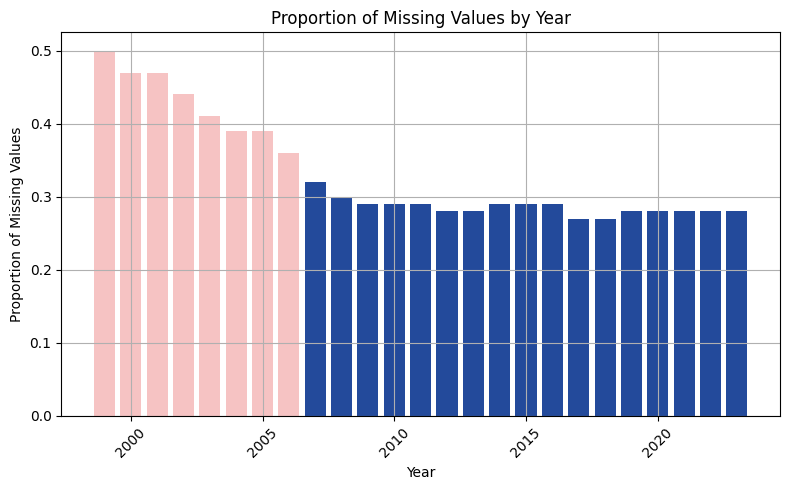

In [309]:
df_mis_val_prop_per_year = pd.DataFrame(list(mis_val_prop_per_year.items()), columns=['Year', 'Missing Proportion'])

# Sort by Year
df_mis_val_prop_per_year = df_mis_val_prop_per_year.sort_values('Year')

colors = ['#234a9b' if year >= 2007 else '#f6c3c3' for year in df_mis_val_prop_per_year['Year']]


# Plotting
plt.figure(figsize=(8, 5))
plt.bar(df_mis_val_prop_per_year['Year'], df_mis_val_prop_per_year['Missing Proportion'], color=colors)
plt.title('Proportion of Missing Values by Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Missing Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Загрузка общего датасета 'data':

## Второй вариант подготовки датасета - data_new и его ОБРАБОТКА:

In [7]:
data_new = pd.read_csv('/Users/svetlana/Desktop/studies_db_202405110027.csv')

#### overall_status distribution:

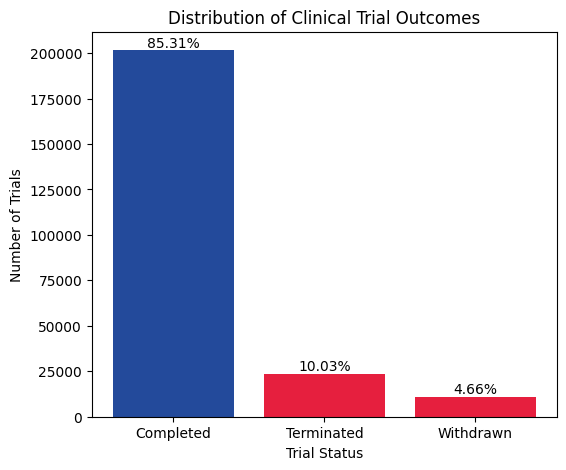

In [302]:
dddd = data_new.overall_status.value_counts().to_dict()

total = sum(dddd.values())

# Create a figure and a set of subplots
plt.figure(figsize=(6,5))

# Plotting the bar chart
bars = plt.bar(dddd.keys(), dddd.values(), color=['#234a9b', '#e61f3e', '#e61f3e'])

# Adding title and labels
plt.title('Distribution of Clinical Trial Outcomes')
plt.xlabel('Trial Status')
plt.ylabel('Number of Trials')

# Calculate and add percentage labels
for bar in bars:
    yval = bar.get_height()
    percentage = f'{(yval / total) * 100:.2f}%'
    plt.text(bar.get_x() + bar.get_width()/2, yval, percentage, va='bottom', ha='center')

# Display the plot
plt.show()

#### data_new_07 filtration:

In [195]:
dddddiffff = data_new.maximum_age_in_years - data_new.minimum_age_in_years
mask10_30 = (dddddiffff < 20) & (data_new.minimum_age_in_years > 10)
mask20_dif = dddddiffff < 20

data_new[mask10_30].overall_status.value_counts(normalize=True)

overall_status
Completed     0.924724
Terminated    0.044551
Withdrawn     0.030725
Name: proportion, dtype: float64

In [196]:
# отфильтровываем исследования 2007 - 2023 года: 
data_new_07 = data_new[data_new['registered_in_calendar_year']>= 2007]

In [197]:
# check of selected years:
selected_years = sorted(data_new_07.value_counts('registered_in_calendar_year').to_dict().keys())
print(selected_years)

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [198]:
# Переименование колонок, чтобы понимать, что они относятся к спонсору 
# + 'allocation' -> 'randomized':
data_new_07 = data_new_07.rename(columns={'industry': 'industry_sponsor',
                                         'nih' : 'nih_sponsor',
                                         'fed' : 'fed_sponsor',
                                         'other_gov' : 'other_gov_sponsor', 
                                         'allocation': 'randomized'})

In [199]:
data_new_07.shape

(208291, 57)

In [822]:
#data_new_07.columns.to_list()

In [823]:
# # на какие колонки отличается второй исходный датасет от первого:
# result = [item for item in data_new_07.columns.to_list() if item not in data.columns.to_list()]
# print(result)

In [578]:
value_counts = data_new_07.overall_status.value_counts()

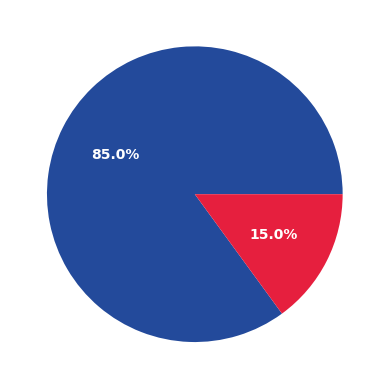

In [602]:
plt.pie(x = value_counts, colors = ['#234a9b', '#e61f3e'], textprops= {'color':'white', 'weight' : 'bold'}, 
        autopct='%1.1f%%')

plt.show()

#, labels = ['Success\n(Completed)', 'Failure\n(Terminated & Withdrawn)']

### Drop ненужных колонок:

In [200]:
columns_to_drop_nan = ['number_of_groups', 'number_of_other_outcomes_to_measure', 'sampling_method']
columns_to_drop_no_info = ['intervention_type', 'registered_in_calendar_year', 'actual_duration', 'nct_id', 'study_type', 'has_single_facility']

In [201]:
was_allready_dropped = []
is_dropped = []

for column in columns_to_drop_nan + columns_to_drop_no_info:
    try:
        data_new_07.drop(column, axis=1, inplace=True)
        is_dropped.append(column)
        #print(f'{column} is dropped.')
    except KeyError:
        was_allready_dropped.append(column)
        #print(f'{column} was allready dropped.')
        
print(f'\033[1mWere allready dropped:\033[0m {was_allready_dropped}.')
print(f'\033[1mWere dropped just now:\033[0m {is_dropped}.')



Were allready dropped: [].
Were dropped just now: ['number_of_groups', 'number_of_other_outcomes_to_measure', 'sampling_method', 'intervention_type', 'registered_in_calendar_year', 'actual_duration', 'nct_id', 'study_type', 'has_single_facility'].


### Предобработка признаков: 

In [202]:
#data_new_07.isna().sum()

In [203]:
#--------------Бинарные: 
binary_features = ['has_expanded_access', 'has_dmc', 'is_fda_regulated_drug', 'randomized', 'has_us_facility', 
                   'healthy_volunteers', 'subject_masked', 'caregiver_masked', 'investigator_masked', 'outcomes_assessor_masked',
                  'superiority_or_other', 'non_inferiority_or_equivalence', 'superiority', 'other_sup_inf_type', 'non_inferiority_or_equivalence_legacy', 
                   'superiority_or_other_legacy', 'non_inferiority', 'equivalence',
                  'experimental_groups', 'active_comparator_groups', 'placebo_comparator_groups', 'no_intervention_groups', 'other_groups',
                   'sham_comparator_groups',
                   'other_sponsor', 'industry_sponsor', 'nih_sponsor', 'fed_sponsor', 'other_gov_sponsor'
                  ]

# 'subject_masked', 'caregiver_masked', 'investigator_masked', 'outcomes_assessor_masked' - по feture analysis они были на 0
# to be: 'randomized', 'healthy_volunteers'


#--------------Категориальные: 
categorical_features = ['source_class', 'intervention_model', 'masking', 'gender', 'responsible_party_type']

categorical_features_target = ['masking', 'responsible_party_type', 'source_class', 'intervention_model']
categorical_features_OHE = ['gender']


#--------------Числовые:
#to be
numeric_features_tobe = ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions', 'criteria']
#is
numeric_features = ['number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 
                    'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries']

numeric_features_all = numeric_features_tobe + numeric_features


#--------------Таргетная переменная: 
'overall_status'
#--------------Для сегментации на поддатасеты
'phase'

other = ['overall_status', 'phase']
None

In [204]:
# Проверка, что я все фичи проанализировала:
set(data_new_07.columns.to_list()) == set(binary_features + categorical_features + numeric_features_all + other)

True

### Преобразование таргетной переменной:

In [205]:
data_new_07.loc[:, 'overall_status'] = data_new_07['overall_status'].map({
    'Completed':1, 
    'Terminated':0, 
    'Withdrawn':0
})

### Подготовка бинарных признаков:

In [206]:
# Проверка, какие значения принимают бинарные переменные:

bin_f_values = {}
for f in binary_features[:11]:
    print(f'\033[1m{f}:\033[0m')
    for item in data_new_07.value_counts(f).to_dict().items():
        print(item)
        bin_f_values[item[0]] = item[1]
    print()

has_expanded_access:
(False, 206545)
(True, 476)

has_dmc:
(False, 115180)
(True, 67732)

is_fda_regulated_drug:
(False, 66300)
(True, 20120)

randomized:
('Randomized', 140575)
('Non-Randomized', 21140)

has_us_facility:
(False, 105540)
(True, 84585)

healthy_volunteers:
('No', 143852)
('Accepts Healthy Volunteers', 63899)

subject_masked:
(True, 73419)

caregiver_masked:
(True, 33864)

investigator_masked:
(True, 59082)

outcomes_assessor_masked:
(True, 51536)

superiority_or_other:
(0.0, 11542)
(1.0, 6240)



In [207]:
# Replace with 0 and 1 values all binary_features:

bin_f_values = {}
for feature in binary_features[:11]:
    data_new_07.loc[:, feature] = data_new_07[feature].map({
        True:1, 
        False:0, 
        'Accepts Healthy Volunteers':1, 
        'No':0,
        'Randomized':1,
        'Non-Randomized':0
    }).astype('Int64')
    #print(data_Phase1[feature].value_counts())

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_90832/826202399.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[<NA>,    0, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>,
 ...
 <NA>,    1, <NA>, <NA>, <NA>, <NA>,    0,    1, <NA>, <NA>]
Length: 208291, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_new_07.loc[:, feature] = data_new_07[feature].map({


In [208]:
# Fillna with 0 for features with NA:
data_new_07.loc[:, binary_features[6:11]] = data_new_07[binary_features[6:11]].fillna(0)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_90832/4107263452.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_new_07.loc[:, binary_features[6:11]] = data_new_07[binary_features[6:11]].fillna(0)


In [209]:
# Replace missing values with mode:

for feature in binary_features:
    mode_value = data_new_07[feature].mode()[0] if not data_new_07[feature].mode().empty else None
    data_new_07[feature] = data_new_07[feature].fillna(mode_value)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_90832/4196277901.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_new_07[feature] = data_new_07[feature].fillna(mode_value)


In [210]:
# Check if any missing values left in binary_features:

if data_new_07[binary_features].isna().sum().sum() == 0:
    print(f'No missing values in binary_features: \033[1m{data_new_07[binary_features].isna().sum().sum() == 0}.\033[0m')
else:
    print('!Some missing values in binary_features:')
    print(data_new_07[binary_features].isna().sum())
    

No missing values in binary_features: True.


In [211]:
data_new_07[binary_features].head()

has_expanded_access  has_dmc  is_fda_regulated_drug  randomized  \
0                    0        0                      0           1   
1                    0        0                      0           1   
2                    0        1                      0           1   
3                    0        0                      0           1   
4                    0        0                      0           1   

   has_us_facility  healthy_volunteers  subject_masked  caregiver_masked  \
0                0                   0               0                 0   
1                1                   1               1                 0   
2                1                   1               1                 0   
3                0                   0               0                 0   
4                0                   0               0                 0   

   investigator_masked  outcomes_assessor_masked  ...  \
0                    0                         0  ...   
1                    0                         0  ...   
2                    1                         1  ...   
3                    0                         0  ...   
4                    0                         0  ...   

   active_comparator_groups  placebo_comparator_groups  \
0                       1.0                        0.0   
1                       0.0                        1.0   
2                       0.0                        1.0   
3                       0.0                        0.0   
4                       0.0                        0.0   

   no_intervention_groups  other_groups  sham_comparator_groups  \
0                     0.0           0.0                     0.0   
1                     0.0           0.0                     0.0   
2                     0.0           0.0                     0.0   
3                     0.0           0.0                     0.0   
4                     0.0           1.0                     0.0   

   other_sponsor  industry_sponsor  nih_sponsor  fed_sponsor  \
0              0                 1            0            0   
1              1                 0            0            0   
2              1                 0            1            0   
3              0                 1            0            0   
4              1                 0            0            0   

   other_gov_sponsor  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 29 columns]

### non_inferiority_type - is categorical:

In [212]:
# Объединяем superiority_or_other и superiority_or_other_legacy:
data_new_07['superiority_or_other'] = data_new_07['superiority_or_other'] + data_new_07['superiority_or_other_legacy']
data_new_07.drop('superiority_or_other_legacy', axis=1, inplace=True)

# Объединяем non_inferiority_or_equivalence и non_inferiority_or_equivalence_legacy:
data_new_07['non_inferiority_or_equivalence'] = data_new_07['non_inferiority_or_equivalence'] + data_new_07['non_inferiority_or_equivalence_legacy']
data_new_07.drop('non_inferiority_or_equivalence_legacy', axis=1, inplace=True)

# Объединяем non_inferiority_or_equivalence и non_inferiority и equivalence:
summ = data_new_07['non_inferiority_or_equivalence'] + data_new_07['non_inferiority'] + data_new_07['equivalence']
summ = summ.map(lambda x: 1 if x==2 else x)
data_new_07['non_inferiority_or_equivalence'] = summ
data_new_07.drop('non_inferiority', axis=1, inplace=True)
data_new_07.drop('equivalence', axis=1, inplace=True)


In [213]:
# убираем лишние фичи: 
binary_features.remove('non_inferiority_or_equivalence_legacy')
binary_features.remove('superiority_or_other_legacy')
binary_features.remove('non_inferiority')
binary_features.remove('equivalence')
print(f'binary_features: {binary_features}')

binary_features: ['has_expanded_access', 'has_dmc', 'is_fda_regulated_drug', 'randomized', 'has_us_facility', 'healthy_volunteers', 'subject_masked', 'caregiver_masked', 'investigator_masked', 'outcomes_assessor_masked', 'superiority_or_other', 'non_inferiority_or_equivalence', 'superiority', 'other_sup_inf_type', 'experimental_groups', 'active_comparator_groups', 'placebo_comparator_groups', 'no_intervention_groups', 'other_groups', 'sham_comparator_groups', 'other_sponsor', 'industry_sponsor', 'nih_sponsor', 'fed_sponsor', 'other_gov_sponsor']


#### Обеспечиваем уникальность значений в non_inferiority_type:

In [214]:
# Создаем маску:
mask_controver = (data_new_07.superiority == data_new_07.non_inferiority_or_equivalence) & (data_new_07.superiority == 1)

# приравниваем все значения:
data_new_07.loc[mask_controver, 'other_sup_inf_type'] = 1
data_new_07.loc[mask_controver, ['non_inferiority_or_equivalence', 'superiority']] = 0


In [215]:
# Создаем маску:
mask_controver2 = (data_new_07.superiority_or_other == data_new_07.non_inferiority_or_equivalence) & (data_new_07.superiority_or_other == 1)

# приравниваем все значения:
data_new_07.loc[mask_controver2, 'other_sup_inf_type'] = 1
data_new_07.loc[mask_controver2, ['superiority_or_other', 'non_inferiority_or_equivalence']] = 0


In [216]:
# Создаем маску где superiority == other_sup_inf_type == 1:
mask_sup_and_other = (data_new_07.superiority == data_new_07.other_sup_inf_type) & (data_new_07.superiority == 1)

# приравниваем все значения superiority к 0 для этой маски:
data_new_07.loc[mask_sup_and_other, 'superiority'] = 0

In [217]:
# Создаем маску, где superiority_or_other и superiority равны единице:
mask_sup = (data_new_07.superiority == data_new_07.superiority_or_other) & (data_new_07.superiority == 1)

# приравниваем все значения superiority_or_other (где superiority_or_other и superiority равны единице) к 0:
data_new_07.loc[mask_sup, 'superiority_or_other'] = 0

In [218]:
# Создаем маску где other = 1:
mask_other = (data_new_07.other_sup_inf_type == 1)

# приравниваем все остальные значения к 0:
data_new_07.loc[mask_other, 'superiority_or_other'] = 0
data_new_07.loc[mask_other, 'non_inferiority_or_equivalence'] = 0
data_new_07.loc[mask_other, 'superiority'] = 0

In [219]:
bin_cat_superiority = ['superiority_or_other', 'non_inferiority_or_equivalence', 'superiority', 'other_sup_inf_type']

In [220]:
# проверка, что больше не осталось двойных значений:  должно быть пусто
mmm = data_new_07[bin_cat_superiority].sum(axis=1) > 1
data_new_07.loc[mmm, bin_cat_superiority]

Empty DataFrame
Columns: [superiority_or_other, non_inferiority_or_equivalence, superiority, other_sup_inf_type]
Index: []

#### non_inferiority_type  from numerical to categorical:

In [221]:
# Создаем новую колонку 'non_inferiority_type', которая будет содержать названия категорий
data_new_07['non_inferiority_type'] = data_new_07[bin_cat_superiority].idxmax(axis=1)

# Drop бинарных колонок:
data_new_07.drop(columns=bin_cat_superiority, axis=1, inplace=True)

In [222]:
categorical_features_OHE

['gender']

In [223]:
categorical_features_target.append('non_inferiority_type')
print(categorical_features_target)

['masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']


In [224]:
categorical_features_all = categorical_features_OHE + categorical_features_target
print(categorical_features_all)

['gender', 'masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']


In [225]:
for f in bin_cat_superiority:
    binary_features.remove(f)
print(binary_features)

['has_expanded_access', 'has_dmc', 'is_fda_regulated_drug', 'randomized', 'has_us_facility', 'healthy_volunteers', 'subject_masked', 'caregiver_masked', 'investigator_masked', 'outcomes_assessor_masked', 'experimental_groups', 'active_comparator_groups', 'placebo_comparator_groups', 'no_intervention_groups', 'other_groups', 'sham_comparator_groups', 'other_sponsor', 'industry_sponsor', 'nih_sponsor', 'fed_sponsor', 'other_gov_sponsor']


### group_type - is categorical: ???

In [665]:
bin_cat_groups = ['experimental_groups',
 'active_comparator_groups',
 'placebo_comparator_groups',
 'no_intervention_groups',
 'other_groups',
 'sham_comparator_groups']

In [666]:
data_new_07[bin_cat_groups]

experimental_groups  active_comparator_groups  \
0                       1.0                       1.0   
1                       1.0                       0.0   
2                       1.0                       0.0   
3                       1.0                       0.0   
4                       0.0                       0.0   
...                     ...                       ...   
236392                  1.0                       0.0   
236393                  1.0                       0.0   
236394                  1.0                       0.0   
236395                  1.0                       0.0   
236396                  0.0                       1.0   

        placebo_comparator_groups  no_intervention_groups  other_groups  \
0                             0.0                     0.0           0.0   
1                             1.0                     0.0           0.0   
2                             1.0                     0.0           0.0   
3                             0.0                     0.0           0.0   
4                             0.0                     0.0           1.0   
...                           ...                     ...           ...   
236392                        0.0                     0.0           0.0   
236393                        0.0                     0.0           0.0   
236394                        1.0                     0.0           0.0   
236395                        0.0                     0.0           0.0   
236396                        0.0                     1.0           0.0   

        sham_comparator_groups  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0  
...                        ...  
236392                     0.0  
236393                     0.0  
236394                     0.0  
236395                     0.0  
236396                     0.0  

[208291 rows x 6 columns]

In [667]:
# проверка, что больше не осталось двойных значений:  должно быть пусто
nnn = data_new_07[bin_cat_groups[1:]].sum(axis=1) > 1
data_new_07.loc[nnn, bin_cat_groups[1:]]

active_comparator_groups  placebo_comparator_groups  \
12                           1.0                        0.0   
14                           1.0                        1.0   
21                           1.0                        0.0   
29                           1.0                        1.0   
37                           1.0                        1.0   
...                          ...                        ...   
236375                       0.0                        0.0   
236381                       1.0                        1.0   
236387                       1.0                        1.0   
236389                       0.0                        1.0   
236396                       1.0                        0.0   

        no_intervention_groups  other_groups  sham_comparator_groups  
12                         1.0           0.0                     0.0  
14                         0.0           0.0                     0.0  
21                         1.0           0.0                     0.0  
29                         0.0           0.0                     0.0  
37                         0.0           0.0                     0.0  
...                        ...           ...                     ...  
236375                     1.0           1.0                     0.0  
236381                     0.0           0.0                     0.0  
236387                     0.0           0.0                     0.0  
236389                     0.0           1.0                     0.0  
236396                     1.0           0.0                     0.0  

[22140 rows x 5 columns]

### sponsor - is categorical: (???)

In [581]:
bin_cat_sponsor = ['other_sponsor',
 'industry_sponsor',
 'nih_sponsor',
 'fed_sponsor',
 'other_gov_sponsor']

In [587]:
# проверка, что больше не осталось двойных значений:  должно быть пусто
mask_several_sponsors = data_new_07[bin_cat_sponsor].sum(axis=1) > 1
data_new_07.loc[mask_several_sponsors, bin_cat_sponsor]

other_sponsor  industry_sponsor  nih_sponsor  fed_sponsor  \
2                   1                 0            1            0   
12                  1                 0            1            0   
13                  1                 1            0            0   
22                  1                 1            0            0   
33                  1                 0            0            1   
...               ...               ...          ...          ...   
236377              1                 1            0            0   
236378              1                 0            0            0   
236388              1                 0            1            0   
236391              1                 1            0            0   
236394              1                 0            1            0   

        other_gov_sponsor  
2                       0  
12                      0  
13                      0  
22                      0  
33                      0  
...                   ...  
236377                  0  
236378                  1  
236388                  0  
236391                  0  
236394                  0  

[35355 rows x 5 columns]

In [ ]:
data_new_07.loc[mask_several_sponsors, 'number_sponsors']

### Анализ категориальных признаков:

In [226]:
# Проверка, какие значения принимают категориальные переменные:

cat_f_values = {}
for f in categorical_features_all:
    print()
    for item in data_new_07.value_counts(f).to_dict().items():
        print(item)
        cat_f_values[item[0]] = item[1]


('All', 176681)
('Female', 19811)
('Male', 11598)

('None (Open Label)', 111237)
('Single', 30214)
('Double', 28608)
('Quadruple', 21861)
('Triple', 15316)

('Sponsor', 116673)
('Principal Investigator', 68791)
('Sponsor-Investigator', 8616)

('OTHER', 132861)
('INDUSTRY', 65254)
('OTHER_GOV', 3967)
('NIH', 2419)
('FED', 2069)
('NETWORK', 1185)
('UNKNOWN', 271)
('INDIV', 265)

('Parallel Assignment', 122445)
('Single Group Assignment', 56156)
('Crossover Assignment', 21795)
('Sequential Assignment', 3944)
('Factorial Assignment', 2904)

('superiority_or_other', 197032)
('superiority', 5570)
('other_sup_inf_type', 3987)
('non_inferiority_or_equivalence', 1702)


In [227]:
# Хи-квадрат для оценки информативности признаков, (насколько от них зависит таргетная переменная):

for feature in categorical_features_all:
    contingency_table=pd.crosstab(data_new_07[feature], data_new_07['overall_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f'\033[1m{feature}:\033[0m')
    print(f"Chi-squared Test Statistic: {chi2}")
    print(f"p-value: {p}")
    print()

gender:
Chi-squared Test Statistic: 251.95056290571173
p-value: 1.948185958324922e-55

masking:
Chi-squared Test Statistic: 1407.8159171642474
p-value: 1.3956940719529641e-303

responsible_party_type:
Chi-squared Test Statistic: 1126.6129379378162
p-value: 2.286172026281707e-245

source_class:
Chi-squared Test Statistic: 256.1485409796454
p-value: 1.3602634915046853e-51

intervention_model:
Chi-squared Test Statistic: 2138.800039293927
p-value: 0.0

non_inferiority_type:
Chi-squared Test Statistic: 536.5608064654193
p-value: 5.6866691418688e-116



In [228]:
# Filling missing values:

data_new_07['gender'] = data_new_07['gender'].astype(str).fillna('All')
data_new_07['gender'] = data_new_07['gender'].map(lambda x: 'All' if x == 'nan' else x)

data_new_07['source_class'] = data_new_07['source_class'].astype(str).fillna('OTHER')
data_new_07['source_class'] = data_new_07['source_class'].map(lambda x: 'OTHER' if x in ['nan', 'UNKNOWN'] else x)

data_new_07['masking'] = data_new_07['masking'].astype(str).fillna('None (Open Label)')
data_new_07['masking'] = data_new_07['masking'].map(lambda x: 'None (Open Label)' if x == 'nan' else x)

data_new_07['intervention_model'] = data_new_07['intervention_model'].astype(str).fillna('Parallel Assignment')
data_new_07['intervention_model'] = data_new_07['intervention_model'].map(lambda x: 'Parallel Assignment' if x == 'nan' else x)

data_new_07['responsible_party_type'] = data_new_07['responsible_party_type'].astype(str).fillna('unknown')
data_new_07['responsible_party_type'] = data_new_07['responsible_party_type'].map(lambda x: 'unknown' if x == 'nan' else x)


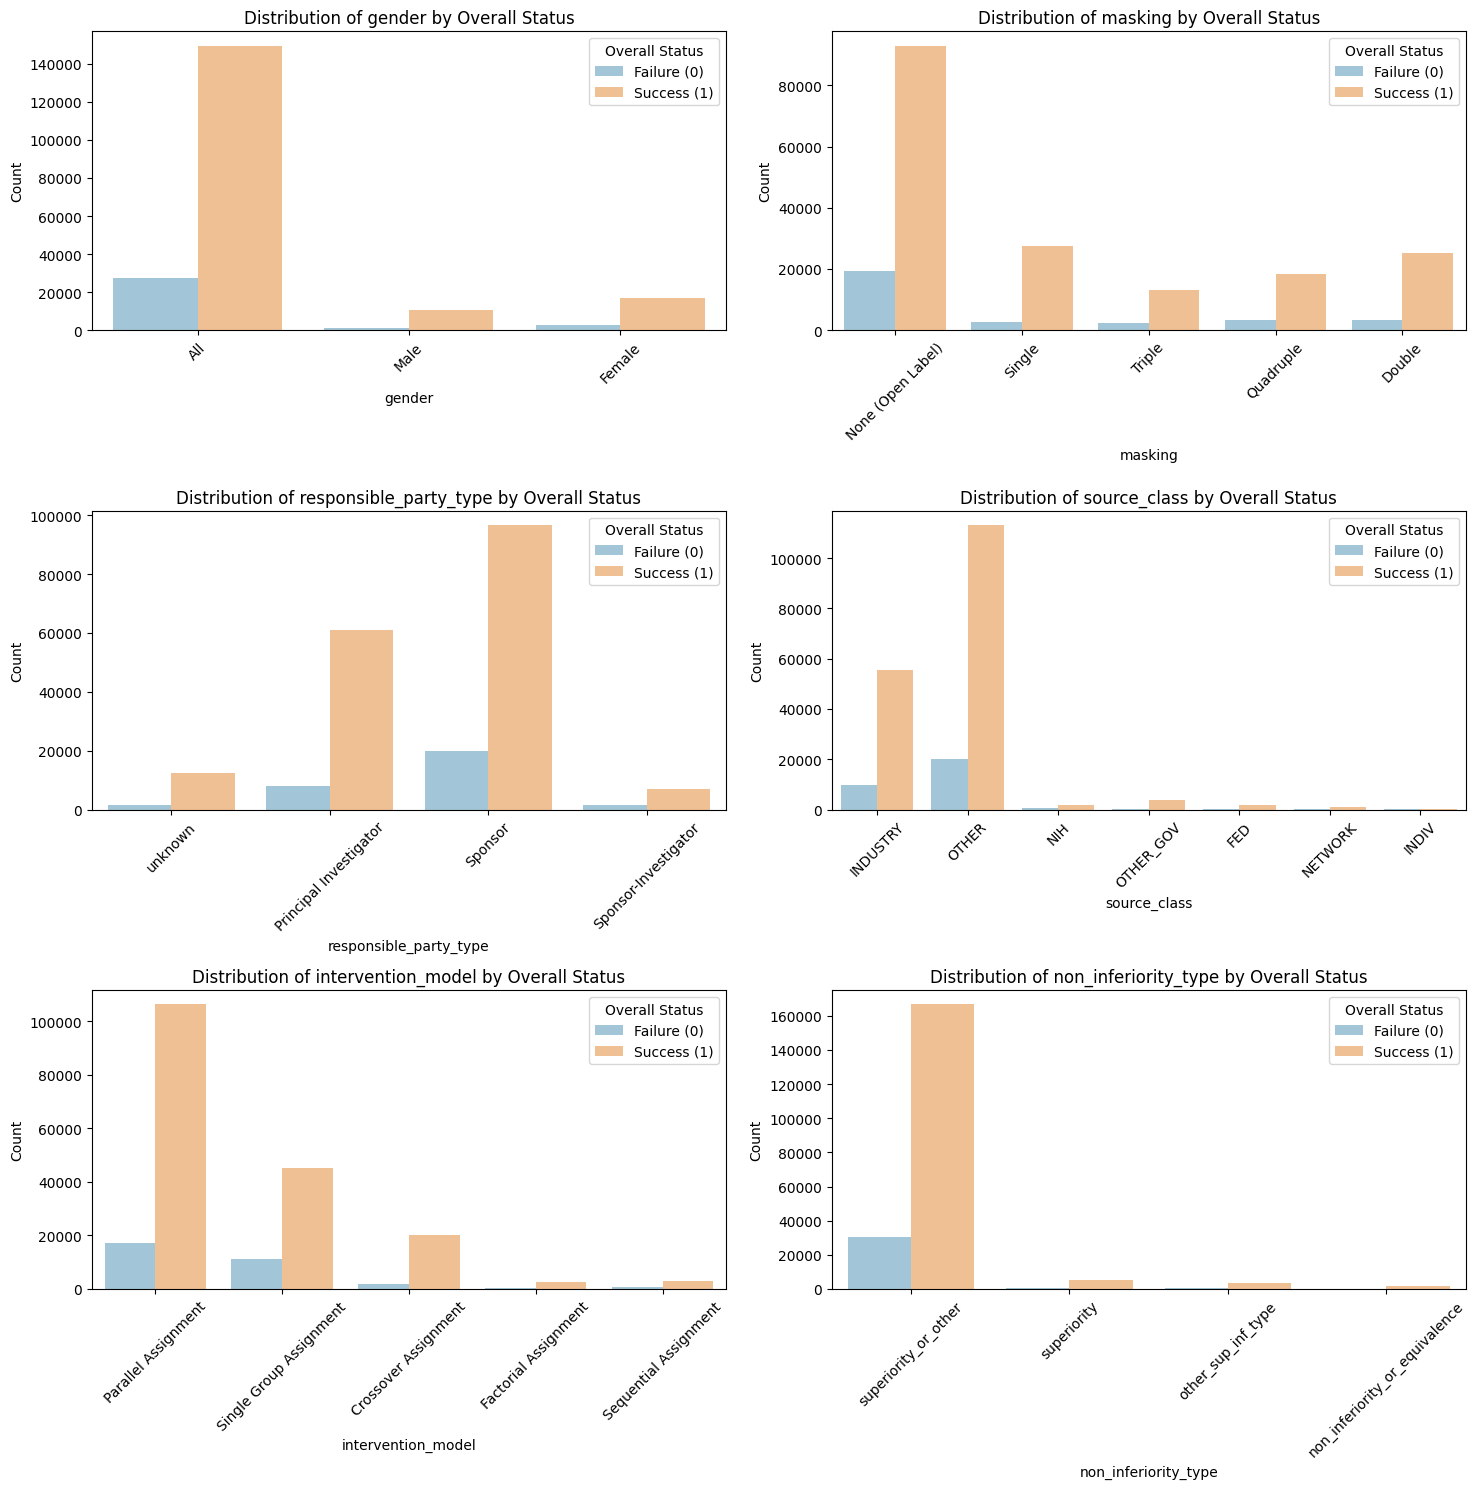

In [229]:
# Количество строк и столбцов для графиков
n_features = len(categorical_features_all)
n_cols = 2  # Два графика в ряд
n_rows = (n_features + n_cols - 1) // n_cols  # Округление вверх для определения количества строк

# Создание фигуры и осей
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))  # Увеличенная ширина фигуры

# Счетчик для итерации по оси
ax_idx = 0

for feature in categorical_features_all:
    ax = axes[ax_idx // n_cols, ax_idx % n_cols]  # Определение текущей оси
    sns.countplot(x=feature, hue='overall_status', data=data_new_07, ax=ax,
                  palette=['#99c9e0', '#ffbf86'])  # Использование заданных цветов
    ax.set_title(f'Distribution of {feature} by Overall Status')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='Overall Status', labels=['Failure (0)', 'Success (1)'])
    ax.tick_params(axis='x', rotation=45)  # Поворот меток
    ax_idx += 1

# Удаляем лишние оси, если они есть
for j in range(ax_idx, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

# Автоматическое корректирование подгонки субплотов
plt.tight_layout()
plt.show()

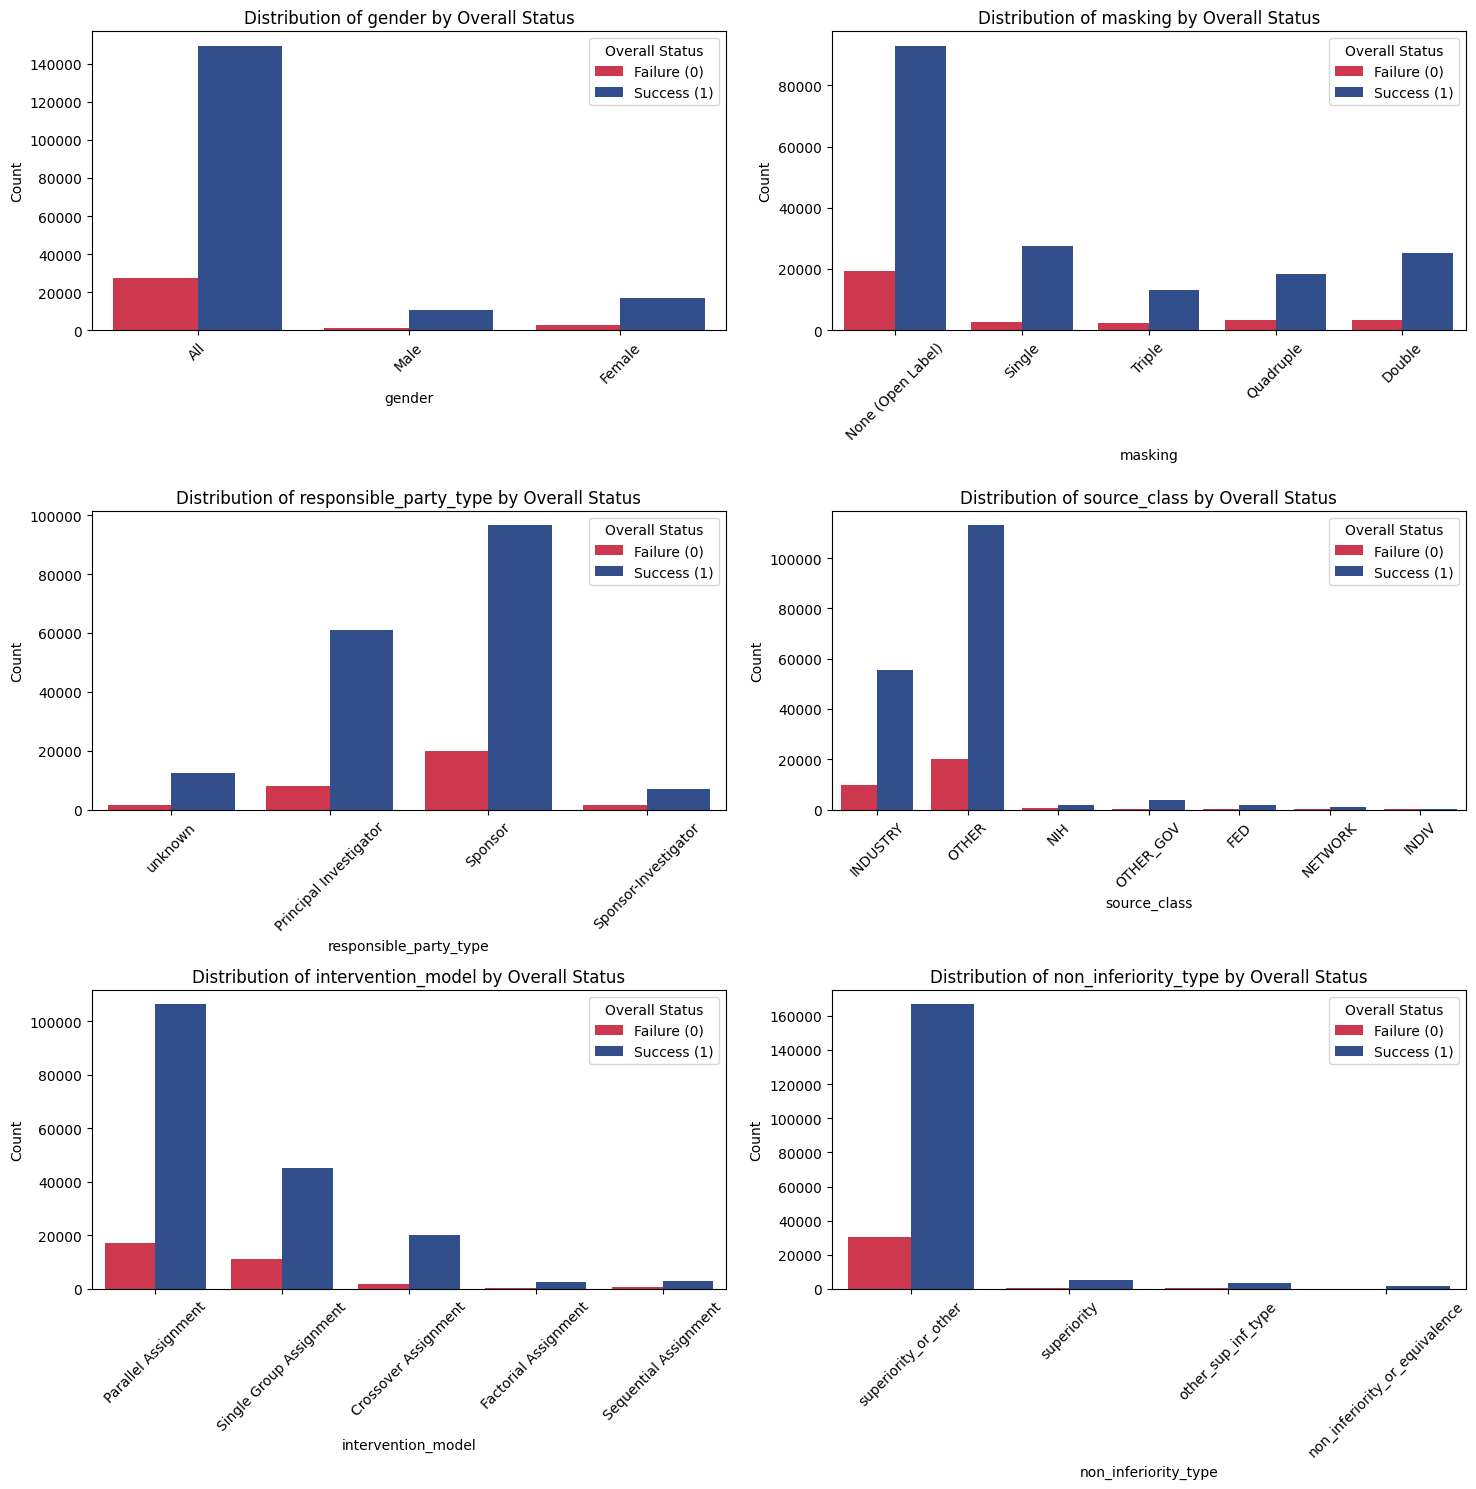

In [486]:
# Количество строк и столбцов для графиков
n_features = len(categorical_features_all)
n_cols = 2  # Два графика в ряд
n_rows = (n_features + n_cols - 1) // n_cols  # Округление вверх для определения количества строк

# Создание фигуры и осей
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))  # Увеличенная ширина фигуры

# Счетчик для итерации по оси
ax_idx = 0

for feature in categorical_features_all:
    ax = axes[ax_idx // n_cols, ax_idx % n_cols]  # Определение текущей оси
    sns.countplot(x=feature, hue='overall_status', data=data_new_07, ax=ax, palette=['#e61f3e', '#234a9b'])
    ax.set_title(f'Distribution of {feature} by Overall Status')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='Overall Status', labels=['Failure (0)', 'Success (1)'])
    ax.tick_params(axis='x', rotation=45)  # Поворот меток
    ax_idx += 1

# Удаляем лишние оси, если они есть
for j in range(ax_idx, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

# Автоматическое корректирование подгонки субплотов
plt.tight_layout()
plt.show()

### Подготовка числовых признаков:

In [231]:
# Преобразование текстовых фичей (названий и описаний) в простую длину текста:
for feature in numeric_features_tobe[:4]:
    data_new_07.loc[pd.notna(data_new_07[feature]), feature] = data_new_07[feature].apply(lambda x: len(str(x)) if pd.notna(x) else x)
    mean_value = data_new_07[feature].mean()
    data_new_07[feature] = data_new_07[feature].fillna(mean_value)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_90832/1872915763.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_new_07[feature] = data_new_07[feature].fillna(mean_value)
/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_90832/1872915763.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_new_07[feature] = data_new_07[feature].fillna(mean_value)
/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_90832/1872915763.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will

In [232]:
# Ф-ция для обработки фичи criteria - извлекаем число критериев включ/исключ:

def extract_num_incl_excl_criteria(criteria):
    parts = criteria.split('Exclusion Criteria:')
    incl_criteria = parts[0].split('Inclusion Criteria:\n\n')[-1].strip()
    # Подсчитываем количество критериев включения
    num_incl_criteria = len([line for line in incl_criteria.split('\n') if line.strip()])
    
    # Получаем часть для критериев исключения, если есть
    if len(parts) > 1:
        excl_criteria = parts[1].strip()
        # Подсчитываем количество критериев исключения
        num_excl_criteria = len([line for line in excl_criteria.split('\n') if line.strip()])
    else:
        num_excl_criteria = 0  # Если нет критериев исключения
    
    return num_incl_criteria, num_excl_criteria


In [233]:
# Обрабатываем колонку criteria функцией извлечения числа критериев включ/исключ и сохраняем их в отдельный np.array:
incl_criteria = []
excl_criteria = []
for i in data_new_07['criteria']:
    try:
        num_incl_criteria, num_excl_criteria = extract_num_incl_excl_criteria(i)
        incl_criteria.append(num_incl_criteria)
        excl_criteria.append(num_excl_criteria)
    except:
        #print(f'for {i} ERROR occurred')
        incl_criteria.append(None)
        excl_criteria.append(None)

# создание np array:
np_incl_criteria = np.array(incl_criteria)
np_excl_criteria = np.array(excl_criteria)

# добавление новых фичей в датасет:
data_new_07['n_inclusion'] = np_incl_criteria
data_new_07['n_exclusion'] = np_excl_criteria



In [234]:
# Вычисляем целочисленное среднее количесво критериев вкл/искл:
mean_n_inclusion = round(data_new_07['n_inclusion'].mean(), 0)
mean_n_exclusion = round(data_new_07['n_exclusion'].mean(), 0)

# Заменяем пропущенные значения на вычисленное среднее:
data_new_07['n_inclusion'] = data_new_07['n_inclusion'].fillna(mean_n_inclusion)
data_new_07['n_exclusion'] = data_new_07['n_exclusion'].fillna(mean_n_exclusion)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_90832/336987535.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_new_07['n_inclusion'] = data_new_07['n_inclusion'].fillna(mean_n_inclusion)
/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_90832/336987535.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_new_07['n_exclusion'] = data_new_07['n_exclusion'].fillna(mean_n_exclusion)


In [235]:
# Удаляем теперь уже лишнюю колонку:
data_new_07.drop('criteria', axis=1, inplace=True)

In [236]:
# Проверяем нет ли MisVal в новых фичах: 
if data_new_07['n_inclusion'].isna().sum() == 0:
    print(f'No miss values in n_inclusion: True.')

if data_new_07['n_exclusion'].isna().sum() == 0:
    print(f'No miss values in n_inclusion: True.')


No miss values in n_inclusion: True.
No miss values in n_inclusion: True.


In [237]:
# Изменяем состав списка numeric_features_tobe и numeric_features_all:
numeric_features_tobe.remove('criteria')
numeric_features_tobe.append('n_inclusion')
numeric_features_tobe.append('n_exclusion')

numeric_features_all = numeric_features_tobe + numeric_features

###### Проверка missing values numeric_features_tobe

In [238]:
# Check if any missing values left in numeric_features_tobe:

if data_new_07[numeric_features_tobe].isna().sum().sum() == 0:
    print(f'No missing values in binary_features: \033[1m{data_new_07[numeric_features_tobe].isna().sum().sum() == 0}.\033[0m')
else:
    print('!Some missing values in newly_numeric_features:')
    print(data_new_07[numeric_features_tobe].isna().sum())

No missing values in binary_features: True.


### Обработка пустых значений для оставшихся числовых признаков (numeric_fatures):

In [239]:
# Fill missing values for age:

mean_min = data_new_07['minimum_age_in_years'].mean()
mean_max = data_new_07['maximum_age_in_years'].mean()
print(mean_min)
print(mean_max)


19.96103495420703
57.18878987172975


In [240]:
# Для минимального возраста
mask_min = (data_new_07['maximum_age_in_years'] < mean_min) & (data_new_07['minimum_age_in_years'].isna())
data_new_07.loc[mask_min, 'minimum_age_in_years'] = 0

# Для максимального возраста
mask_max = (data_new_07['minimum_age_in_years'] > mean_max) & (data_new_07['maximum_age_in_years'].isna())
data_new_07.loc[mask_max, 'maximum_age_in_years'] = 150

# Проверка результатов
# print(data_new_07.loc[mask_min, 'minimum_age_in_years'])
# print(data_new_07.loc[mask_max, 'maximum_age_in_years'])

In [241]:
# Fill missing values in numeric_features with mean_value:
print(f'numeric_features: {numeric_features}')

for feature in numeric_features:
    mean_value = data_new_07[feature].mean()
    data_new_07[feature] = data_new_07[feature].fillna(mean_value)

numeric_features: ['number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries']


In [242]:
# Check if any missing values left in numeric_features:

if data_new_07[numeric_features].isna().sum().sum() == 0:
    print(f'No missing values in numeric_features: \033[1m{data_new_07[numeric_features].isna().sum().sum() == 0}.\033[0m')
else:
    print('!Some missing values in numeric_features:')
    print(data_new_07[numeric_features].isna().sum())

No missing values in numeric_features: True.


### Проверка missing values:

In [243]:
data_new_07.isna().mean()

brief_title                                0.000000
official_title                             0.000000
overall_status                             0.000000
phase                                      0.000288
number_of_arms                             0.000000
has_expanded_access                        0.000000
has_dmc                                    0.000000
is_fda_regulated_drug                      0.000000
source_class                               0.000000
brief_summaries                            0.000000
detailed_descriptions                      0.000000
number_of_facilities                       0.000000
has_us_facility                            0.000000
minimum_age_in_years                       0.000000
maximum_age_in_years                       0.000000
number_of_primary_outcomes_to_measure      0.000000
number_of_secondary_outcomes_to_measure    0.000000
randomized                                 0.000000
intervention_model                         0.000000
masking     

<h2 style="color:lightgrey">Самый первый вариант подготовки датасета data (skip):</h2>

In [30]:
data_pathway = '/Users/svetlana/Desktop/studies_db_202403301855.csv'
data = pd.read_csv(data_pathway, on_bad_lines='warn')

In [32]:
data.shape

(168275, 36)

In [2345]:
data.columns

Index(['nct_id', 'study_type', 'brief_title', 'official_title',
       'overall_status', 'phase', 'number_of_arms', 'number_of_groups',
       'has_expanded_access', 'source_class', 'brief_summaries',
       'detailed_descriptions', 'number_of_facilities',
       'registered_in_calendar_year', 'actual_duration', 'has_us_facility',
       'has_single_facility', 'minimum_age_in_years', 'maximum_age_in_years',
       'number_of_primary_outcomes_to_measure',
       'number_of_secondary_outcomes_to_measure',
       'number_of_other_outcomes_to_measure', 'allocation',
       'intervention_model', 'masking', 'subject_masked', 'caregiver_masked',
       'investigator_masked', 'outcomes_assessor_masked', 'sampling_method',
       'gender', 'healthy_volunteers', 'criteria', 'gender_based',
       'non_inferiority_type', 'responsible_party_type'],
      dtype='object')

In [2347]:
data.value_counts('phase')

phase
Not Applicable     90117
Phase 1            21633
Phase 2            20007
Phase 3            13517
Phase 4            13249
Phase 1/Phase 2     5105
Phase 2/Phase 3     2454
Early Phase 1       2133
Name: count, dtype: int64

# Exploratory Data Analysis:

## phase:

In [317]:
d = data_new_07.phase.value_counts().to_dict()
for k in d.keys():
    print(k)

Not Applicable
Phase 2
Phase 1
Phase 3
Phase 4
Phase 1/Phase 2
Phase 2/Phase 3
Early Phase 1


In [318]:
#p1 = data_new_07[(data_new_07['phase']=='Early Phase 1') | (data_new_07['phase']=='Phase 1') | (data_new_07['phase']=='Phase 1/Phase 2')]

In [159]:
p1 = d['Phase 1'] + d['Phase 1/Phase 2'] + d['Early Phase 1']
p2 = d['Phase 2'] + d['Phase 2/Phase 3']
p3 = d['Phase 3']
p4 = d['Phase 4']

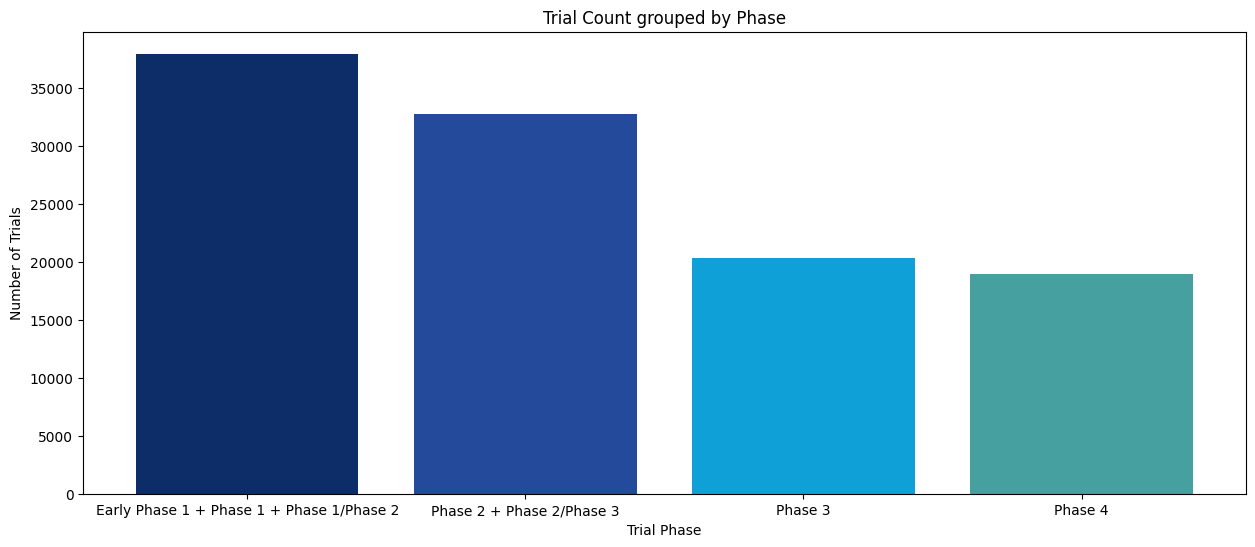

In [315]:
# Data from your calculations
phases = ['Early Phase 1 + Phase 1 + Phase 1/Phase 2', 'Phase 2 + Phase 2/Phase 3', 'Phase 3', 'Phase 4']
counts = [p1, p2, p3, p4]


colors=['#0d2d69', '#234a9b', '#0fa0d7', '#47a0a0']
# Creating the histogram
plt.figure(figsize=(15, 6))  # Set the figure size
plt.bar(phases, counts, color=colors)  # Create a bar chart
plt.title('Trial Count grouped by Phase')  # Set the title of the chart
plt.xlabel('Trial Phase')  # Label for the x-axis
plt.ylabel('Number of Trials')  # Label for the y-axis
plt.show()  # Display the chart


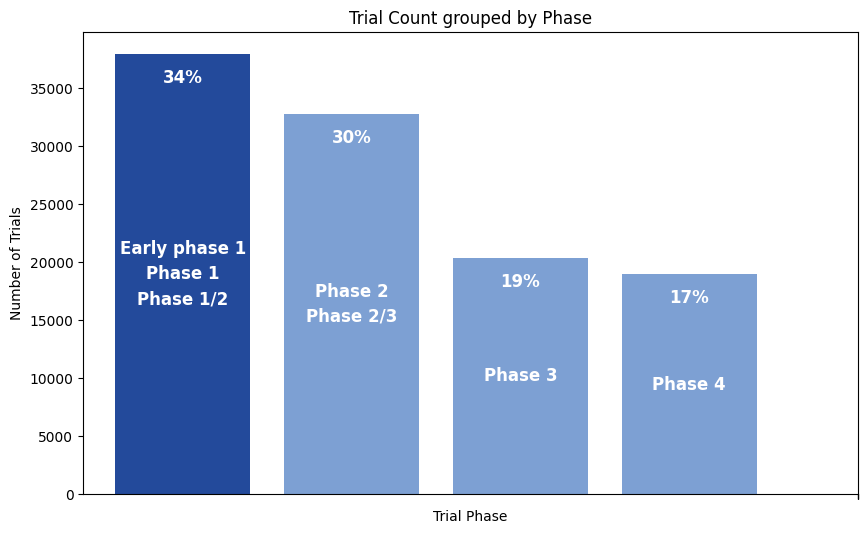

In [418]:
import matplotlib.pyplot as plt

# Your existing data and calculations
p1 = d['Phase 1'] + d['Phase 1/Phase 2'] + d['Early Phase 1']
p2 = d['Phase 2'] + d['Phase 2/Phase 3']
p3 = d['Phase 3']
p4 = d['Phase 4']

total_n = p1+p2+p3+p4
per1 = int(round(p1 / total_n * 100, 0))
per2 = int(round(p2 / total_n * 100, 0))
per3 = int(round(p3 / total_n * 100, 0))
per4 = int(round(p4 / total_n * 100, 0))

# Data from your calculations
phases = ['Early phase 1\nPhase 1\nPhase 1/2', 'Phase 2\nPhase 2/3', 'Phase 3', 'Phase 4']
counts = [p1, p2, p3, p4]
pers = [per1, per2, per3, per4]

# Colors for the bars
colors=['#0d2d69', '#234a9b', '#0fa0d7', '#47a0a0']
colors=['#234a9b', '#7da0d3', '#7da0d3', '#7da0d3']

# Creating the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(phases, counts, color=colors)  # Create a bar chart

# Adding text inside the bars
for bar, label in zip(bars, phases):
    plt.text(
        bar.get_x() + bar.get_width() / 2 ,
        bar.get_height() / 2,
        label,
        ha='center',
        va='center',
        color='white',
        fontweight='bold',
        fontsize=12,
        linespacing=1.5)

colors_num = ['white', 'black', 'black', 'black']
# Adding numbers for the bars:
for bar, per in zip(bars, pers):
    plt.text(
        bar.get_x() + bar.get_width() / 2 ,
        bar.get_height() - 2000,
        f'{per}%',
        ha='center',
        va='center',
        color='white', ##e61f3e
        fontweight='bold',
        fontsize=12
    )

# Setting the title of the chart
plt.title('Trial Count grouped by Phase')
plt.xlabel('Trial Phase')  # Label for the x-axis
plt.ylabel('Number of Trials')  # Label for the y-axis

plt.xticks(['','','',''])
plt.show()  # Display the chart


## numeric features:

In [161]:
num_f_stats = data_new_07[numeric_features_all].describe().astype(int)
num_f_stats.transpose()

count  mean   std  min  25%   50%  \
brief_title                              208291    87    36   16   61    83   
official_title                           208291   143    63   16   97   136   
brief_summaries                          208291   594   562    4  221   388   
detailed_descriptions                    208291  1871  1743    1  937  1871   
n_inclusion                              208291     6     7    0    3     5   
n_exclusion                              208291     8     7    0    3     6   
number_of_arms                           208291     2     1    1    2     2   
number_of_facilities                     208291     7    29    1    1     1   
minimum_age_in_years                     208291    19    10    0   18    18   
maximum_age_in_years                     208291    59    22    0   59    59   
number_of_primary_outcomes_to_measure    208291     1     3    1    1     1   
number_of_secondary_outcomes_to_measure  208291     5     6    1    2     5   
number_of_countries                      208291     1     2    0    1     1   

                                          75%    max  
brief_title                               107    300  
official_title                            180    598  
brief_summaries                           753   4993  
detailed_descriptions                    1871  31865  
n_inclusion                                 8    144  
n_exclusion                                11     90  
number_of_arms                              2     44  
number_of_facilities                        4   1746  
minimum_age_in_years                       18     90  
maximum_age_in_years                       65    150  
number_of_primary_outcomes_to_measure       2    217  
number_of_secondary_outcomes_to_measure     5    324  
number_of_countries                         1     62

In [171]:
# Определяем фичи и таргет:
features = data_new_07[numeric_features_all]
# target = data_new_07['overall_status'].map({
#     'Completed':1, 
#     'Terminated':0, 
#     'Withdrawn':0
# })
target = data_new_07['overall_status']

/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test for brief_title: Statistic=0.9314701557159424, p-value=0.0
Shapiro-Wilk Test for official_title: Statistic=0.9521975517272949, p-value=0.0
Shapiro-Wilk Test for brief_summaries: Statistic=0.7611908912658691, p-value=0.0
Shapiro-Wilk Test for detailed_descriptions: Statistic=0.6092560291290283, p-value=0.0
Shapiro-Wilk Test for n_inclusion: Statistic=0.6409070491790771, p-value=0.0
Shapiro-Wilk Test for n_exclusion: Statistic=0.8475099802017212, p-value=0.0
Shapiro-Wilk Test for number_of_arms: Statistic=0.6039186716079712, p-value=0.0
Shapiro-Wilk Test for number_of_facilities: Statistic=0.18992704153060913, p-value=0.0
Shapiro-Wilk Test for minimum_age_in_years: Statistic=0.6289418935775757, p-value=0.0
Shapiro-Wilk Test for maximum_age_in_years: Statistic=0.8349893093109131, p-value=0.0
Shapiro-Wilk Test for number_of_primary_outcomes_to_measure: Statistic=0.29803192615509033, p-value=0.0
Shapiro-Wilk Test for number_of_secondary_outcomes_to_measure: Statistic=0.525

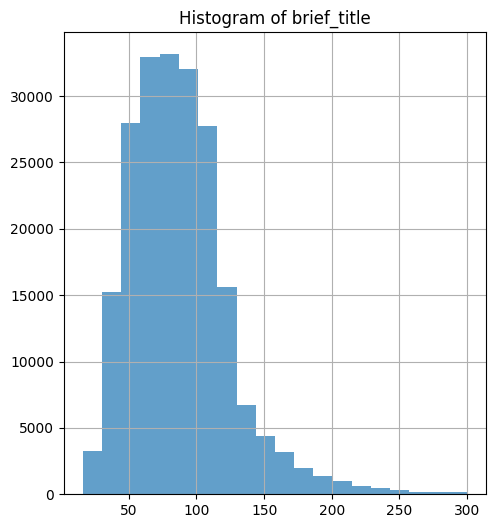

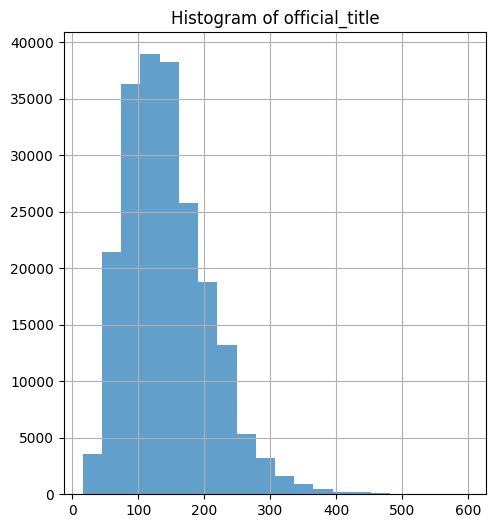

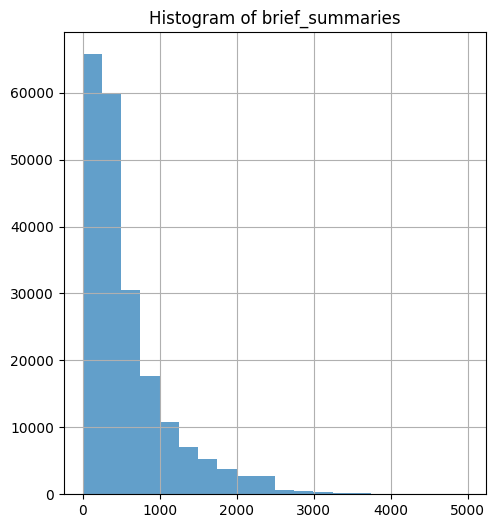

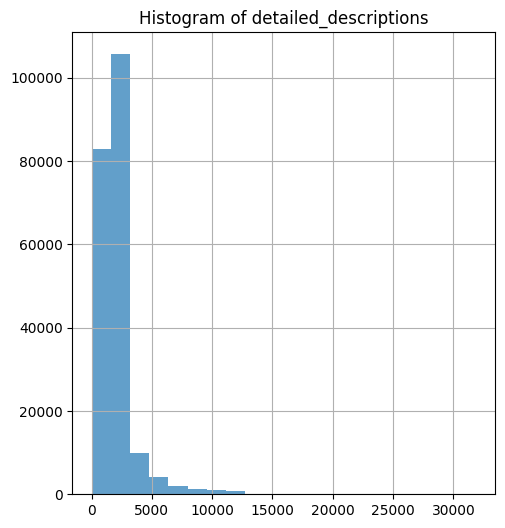

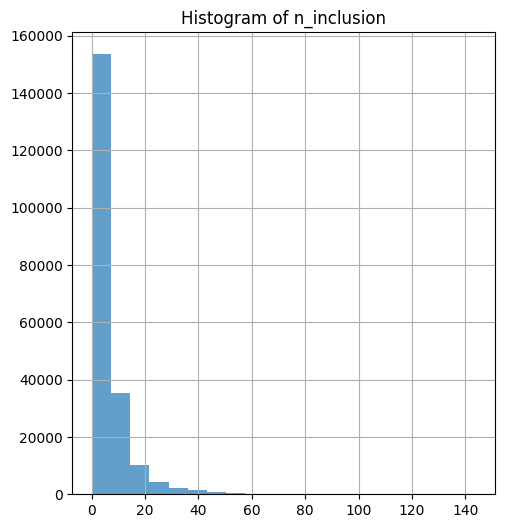

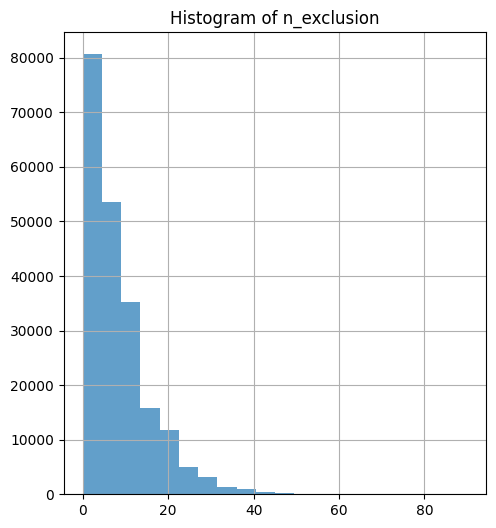

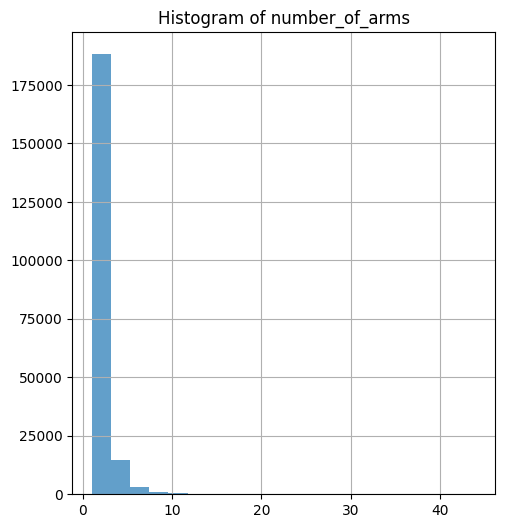

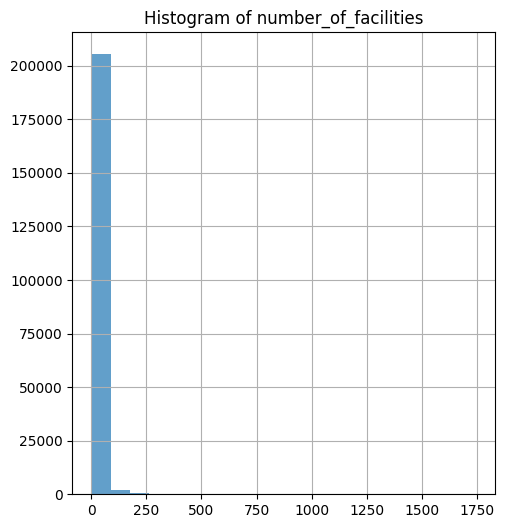

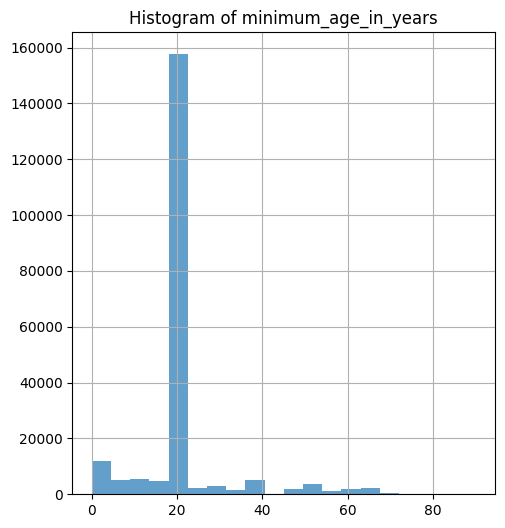

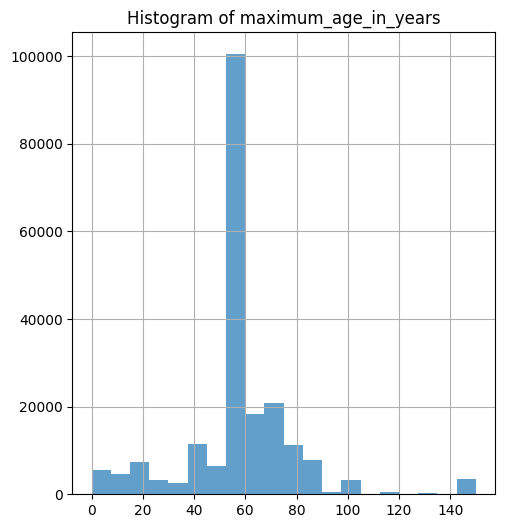

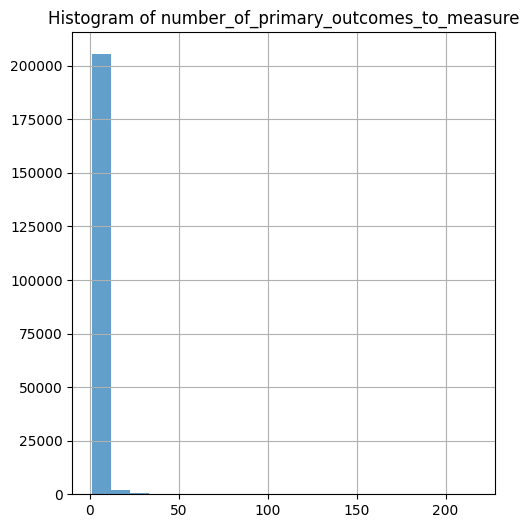

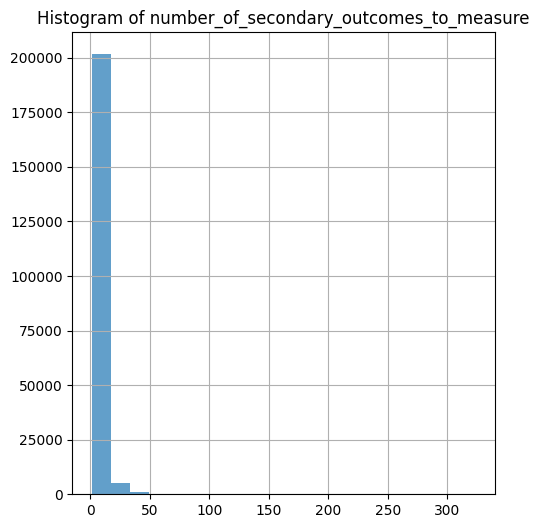

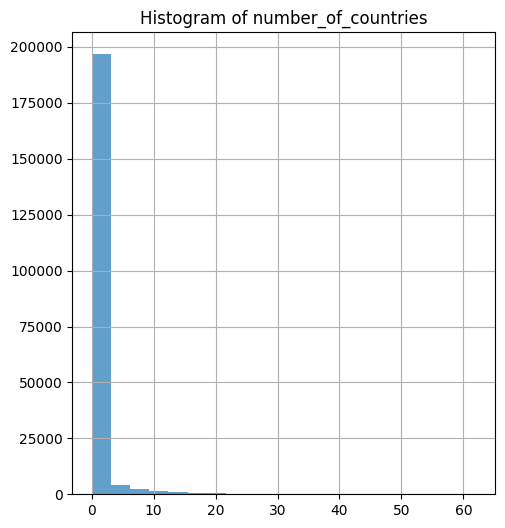

In [172]:
for column in features.columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    features[column].hist(bins=20, alpha=0.7)
    plt.title('Histogram of ' + column)
    plt.savefig(f'{column}_hist.png')
    
    # # QQ-график
    # plt.subplot(1, 2, 2)
    # stats.probplot(features[column], dist="norm", plot=plt)
    # plt.title('QQ plot of ' + column)

    # plt.tight_layout()
    # plt.show()

    # Тест Шапиро-Уилка
    shapiro_test = stats.shapiro(features[column])
    print(f"Shapiro-Wilk Test for {column}: Statistic={shapiro_test[0]}, p-value={shapiro_test[1]}")

    # Вывод результатов теста (примерный порог значимости p-value < 0.05)
    # if shapiro_test[1] < 0.05:
    #     print(f"{column} is not normally distributed (reject H0)")
    # else:
    #     print(f"{column} is normally distributed (fail to reject H0)")

In [173]:
# Траснформер скаляр для нумерик фичей:
st_scaler_transformer = ColumnTransformer(transformers = [
    ('st_scaler', StandardScaler(), numeric_features_all)
], remainder = 'passthrough'
)

In [174]:
# Трансформация:
features_transformed = st_scaler_transformer.fit_transform(features, target)
features_transformed = pd.DataFrame(features_transformed, columns=features.columns)


In [178]:
from scipy.stats import pointbiserialr

# Оценка корреляции между нумерик фичами и таргетом:
correlations = {}
for column in features.columns:
    corr, _ = pointbiserialr(features_transformed[column], target)
    correlations[column] = corr

correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation with Target'])

# Сортировка по абсолютным значениям корреляции:
correlation_df['abs_correlation'] = correlation_df['Correlation with Target'].abs()
correlation_df_sorted = correlation_df.sort_values('abs_correlation', ascending=True).drop('abs_correlation', axis=1)

#print(correlation_df_sorted)

In [179]:

# Оценка корреляции между числовыми фичами и таргетом
correlations = {}
p_values = {}
for column in features.columns:
    corr, p_value = pointbiserialr(features_transformed[column], target)
    correlations[column] = corr
    p_values[column] = p_value

# Создание DataFrame с корреляциями и p-значениями
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation with Target'])
correlation_df['p-value'] = correlation_df['Feature'].map(p_values)

# Сортировка по абсолютным значениям корреляции
correlation_df['abs_correlation'] = correlation_df['Correlation with Target'].abs()
correlation_df_sorted = correlation_df.sort_values('abs_correlation', ascending=True)
correlation_df_sorted = correlation_df_sorted.drop('abs_correlation', axis=1)

# Вывод отсортированного DataFrame
print(correlation_df_sorted)


                                    Feature  Correlation with Target  \
2                           brief_summaries                 0.000195   
11  number_of_secondary_outcomes_to_measure                 0.003162   
3                     detailed_descriptions                 0.008831   
7                      number_of_facilities                -0.010648   
12                      number_of_countries                -0.019694   
8                      minimum_age_in_years                 0.020741   
1                            official_title                -0.024606   
0                               brief_title                -0.027930   
10    number_of_primary_outcomes_to_measure                 0.032549   
9                      maximum_age_in_years                -0.040492   
6                            number_of_arms                 0.049189   
5                               n_exclusion                -0.074744   
4                               n_inclusion                -0.10

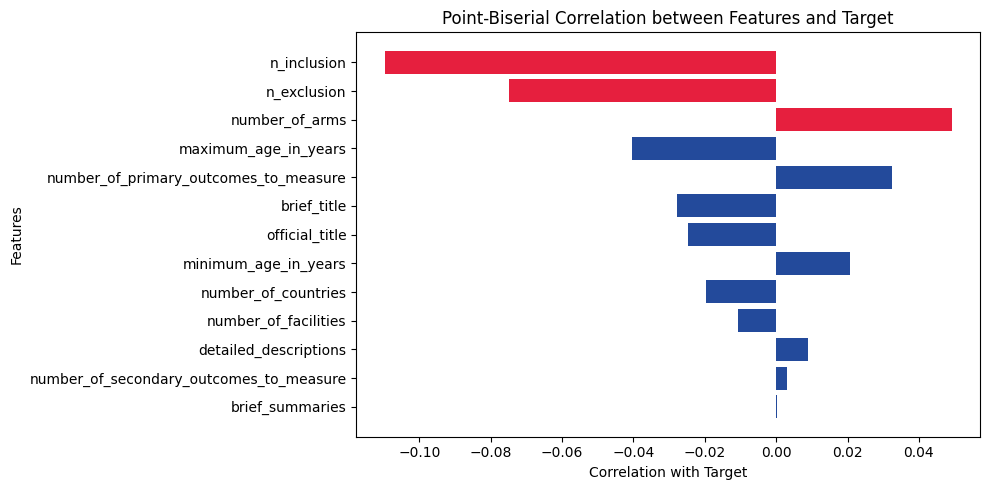

In [466]:
# Визаулизация корреляции
colors=['#234a9b', '#234a9b', '#234a9b', '#234a9b', '#234a9b', '#234a9b', '#234a9b', '#234a9b', '#234a9b', '#234a9b', '#e61f3e', '#e61f3e', '#e61f3e']

plt.figure(figsize=(10, 5))
plt.barh(correlation_df_sorted['Feature'], correlation_df_sorted['Correlation with Target'], color=colors)
plt.xlabel('Correlation with Target')
plt.ylabel('Features')
plt.title('Point-Biserial Correlation between Features and Target')
plt.tight_layout()
plt.show()

### Исследование для возрастных фичей:

In [427]:
# data_new_07[data_new_07.age_gap<20]['maximum_age_in_years'].describe()
# data_new_07[data_new_07.age_gap<20]['minimum_age_in_years'].describe()

In [428]:
# Создаем отдельную копию датасета, чтобы эксперементировать далее не нем:
data_new_copy = data_new_07.copy()

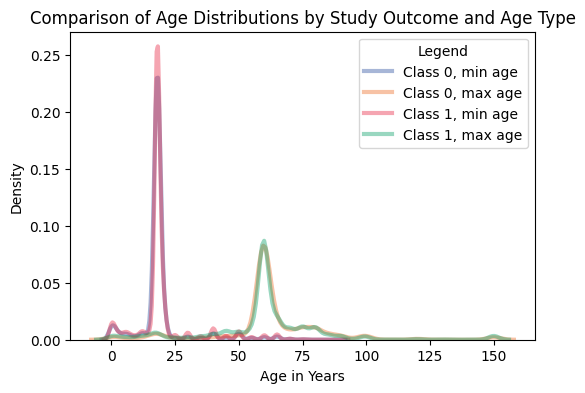

In [464]:
# Визуализация распределения мин и макс возрастов для 0 и 1 классов:

min_ages = data_new_copy['minimum_age_in_years']
max_ages = data_new_copy['maximum_age_in_years']
outcomes = data_new_copy['overall_status']

# Create a DataFrame
plot_data = pd.DataFrame({
    'Age': pd.concat([min_ages, max_ages]),
    'Age Type': [', min age']*len(min_ages) + [', max age']*len(max_ages),
    'Outcome': pd.concat([outcomes, outcomes])  # Repeat 'overall_status' twice
})

plt.figure(figsize=(6, 4))

# Define color mappings
colors = {
    (0,', min age'): '#234a9b',     # Class 0, Min Age 
    (0, ', max age'): '#eb681f',    # Class 0, Max Age 
    (1, ', min age'): '#e61f3e',    # Class 1, Min Age
    (1, ', max age'): '#019c63'   # Class 1, Max Age
}

# Plot KDE for each subset
for (outcome, age_type), color in colors.items():
    subset = plot_data[(plot_data['Outcome'] == outcome) & (plot_data['Age Type'] == age_type)]
    sns.kdeplot(data=subset, x='Age', color=color, linewidth=3,  alpha=0.4, label=f'Class {outcome}{age_type}')

plt.title('Comparison of Age Distributions by Study Outcome and Age Type')
plt.xlabel('Age in Years')
plt.ylabel('Density')
plt.legend(title='Legend')
plt.show()


In [184]:
# # Визуализация распределения разницы мин/макс возрастов для 0 и 1 классов:

# plt.figure(figsize=(12, 8))

# # Plot KDE for the 'age_gap' for each outcome class
# sns.kdeplot(data=data_new_copy[data_new_copy['overall_status'] == 0], x='age_gap', color="red", label='Class 0', alpha=0.5)
# sns.kdeplot(data=data_new_copy[data_new_copy['overall_status'] == 1], x='age_gap', color="blue", label='Class 1', alpha=0.5)

# plt.title('Comparison of Age Gap Distribution by Class')
# plt.xlabel('Age Gap')
# plt.ylabel('Density')
# plt.legend(title='Outcome Class')
# plt.show()

### Исследование для number_of_facilities:

In [189]:
# Создаем отдельную копию датасета, чтобы эксперементировать далее не нем:
data_new_copy = data_new_07.copy()

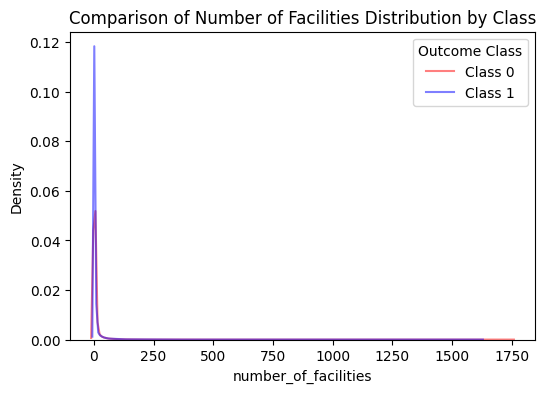

In [190]:
# Визуализация распределения разницы мин/макс возрастов для 0 и 1 классов:

plt.figure(figsize=(6, 4))

# Plot KDE for the 'age_gap' for each outcome class
sns.kdeplot(data=data_new_copy[data_new_copy['overall_status'] == 0], x='number_of_facilities', color="red", label='Class 0', alpha=0.5)
sns.kdeplot(data=data_new_copy[data_new_copy['overall_status'] == 1], x='number_of_facilities', color="blue", label='Class 1', alpha=0.5)

plt.title('Comparison of Number of Facilities Distribution by Class')
plt.xlabel('number_of_facilities')
plt.ylabel('Density')
plt.legend(title='Outcome Class')
plt.show()

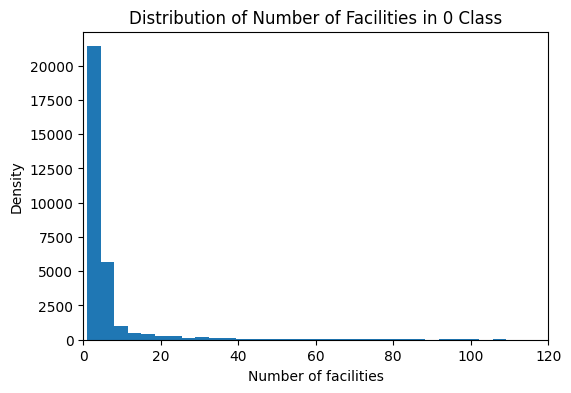

In [191]:
# Визуализация 0 класс: 
number_of_facilities_0 = data_new_copy[data_new_copy['overall_status'] == 0]['number_of_facilities']

plt.figure(figsize=(6, 4))
plt.hist(number_of_facilities_0, bins=500)

plt.title('Distribution of Number of Facilities in 0 Class')
plt.xlabel('Number of facilities')
plt.ylabel('Density')
plt.xlim(0, 120)
plt.show()

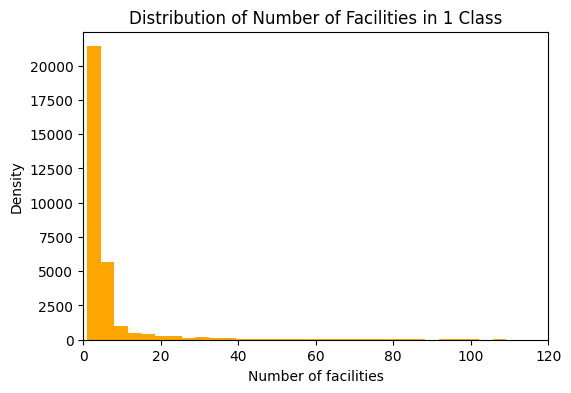

In [192]:
# Визуализация 1 класс: 
number_of_facilities_1 = data_new_copy[data_new_copy['overall_status'] == 1]['number_of_facilities']

plt.figure(figsize=(6, 4))
plt.hist(number_of_facilities_0, bins=500, color='orange')

plt.title('Distribution of Number of Facilities in 1 Class')
plt.xlabel('Number of facilities')
plt.ylabel('Density')
plt.xlim(0, 120)
plt.show()

## Binary features:

In [470]:
numeric_features_all

['brief_title',
 'official_title',
 'brief_summaries',
 'detailed_descriptions',
 'n_inclusion',
 'n_exclusion',
 'number_of_arms',
 'number_of_facilities',
 'minimum_age_in_years',
 'maximum_age_in_years',
 'number_of_primary_outcomes_to_measure',
 'number_of_secondary_outcomes_to_measure',
 'number_of_countries']

In [246]:
binary_features

['has_expanded_access',
 'has_dmc',
 'is_fda_regulated_drug',
 'randomized',
 'has_us_facility',
 'healthy_volunteers',
 'subject_masked',
 'caregiver_masked',
 'investigator_masked',
 'outcomes_assessor_masked',
 'experimental_groups',
 'active_comparator_groups',
 'placebo_comparator_groups',
 'no_intervention_groups',
 'other_groups',
 'sham_comparator_groups',
 'other_sponsor',
 'industry_sponsor',
 'nih_sponsor',
 'fed_sponsor',
 'other_gov_sponsor']

In [474]:
data_new_07[(data_new_07.overall_status == 0) & (data_new_07.has_us_facility == 1)]['number_of_facilities'].describe()

count    16495.000000
mean        10.775750
std         44.507137
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1746.000000
Name: number_of_facilities, dtype: float64

In [475]:
data_new_07[(data_new_07.overall_status == 1) & (data_new_07.has_us_facility == 1)]['number_of_facilities'].describe()

count    68090.000000
mean        12.057116
std         43.087111
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       1621.000000
Name: number_of_facilities, dtype: float64

In [476]:
from scipy import stats

gr1 = data_new_07[(data_new_07.overall_status == 0) & (data_new_07.has_us_facility == 1)]['number_of_facilities']
gr2 = data_new_07[(data_new_07.overall_status == 1) & (data_new_07.has_us_facility == 1)]['number_of_facilities']

t_stat, p_value = stats.ttest_ind(gr1, gr2)

print(t_stat)
print(p_value)

-3.404693576015421
0.000662690727727397


In [249]:
# Хи-квадрат для оценки информативности признаков, (насколько от них зависит таргетная переменная):
chi2_dict = {}

for feature in binary_features:
    contingency_table=pd.crosstab(data_new_07[feature], data_new_07['overall_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.05:
        chi2_dict[feature] = (chi2, p)

        # if chi2 > 900:
        print(f'\033[1m{feature}:\033[0m')
        print(f"Chi-squared Test Statistic: {round(chi2,2)}")
        print(f"p-value: {p}")
        print()

has_dmc:
Chi-squared Test Statistic: 999.42
p-value: 2.3983825443540912e-219

is_fda_regulated_drug:
Chi-squared Test Statistic: 3042.39
p-value: 0.0

randomized:
Chi-squared Test Statistic: 103.05
p-value: 3.265953186508036e-24

has_us_facility:
Chi-squared Test Statistic: 2303.19
p-value: 0.0

healthy_volunteers:
Chi-squared Test Statistic: 3985.06
p-value: 0.0

subject_masked:
Chi-squared Test Statistic: 232.14
p-value: 2.035509122082742e-52

caregiver_masked:
Chi-squared Test Statistic: 8.2
p-value: 0.004185025722646118

investigator_masked:
Chi-squared Test Statistic: 68.78
p-value: 1.1004849491871229e-16

outcomes_assessor_masked:
Chi-squared Test Statistic: 458.59
p-value: 9.726679637069698e-102

experimental_groups:
Chi-squared Test Statistic: 26.91
p-value: 2.129899356174147e-07

active_comparator_groups:
Chi-squared Test Statistic: 268.22
p-value: 2.772878551956152e-60

placebo_comparator_groups:
Chi-squared Test Statistic: 4.18
p-value: 0.040865422530639135

no_intervention_

In [250]:
# Сортировка словаря по значениям chi2:
sorted_chi2_dict = sorted(chi2_dict.items(), key=lambda item: item[1][0], reverse=True)
sorted_chi2_dict

[('healthy_volunteers', (3985.058159808843, 0.0)),
 ('is_fda_regulated_drug', (3042.392916621569, 0.0)),
 ('has_us_facility', (2303.192594549842, 0.0)),
 ('has_dmc', (999.4219256724277, 2.3983825443540912e-219)),
 ('outcomes_assessor_masked', (458.59352919153486, 9.726679637069698e-102)),
 ('no_intervention_groups', (353.268736071719, 8.228777651992349e-79)),
 ('other_gov_sponsor', (275.72928117458764, 6.4015466808953485e-62)),
 ('active_comparator_groups', (268.2196619174723, 2.772878551956152e-60)),
 ('industry_sponsor', (256.49077802271273, 9.98762861380859e-58)),
 ('subject_masked', (232.13991015041864, 2.035509122082742e-52)),
 ('randomized', (103.05121424868457, 3.265953186508036e-24)),
 ('investigator_masked', (68.78062638587616, 1.1004849491871229e-16)),
 ('fed_sponsor', (31.321901654611597, 2.185996251229774e-08)),
 ('other_groups', (29.58427835216002, 5.353742264305052e-08)),
 ('experimental_groups', (26.911480548011184, 2.129899356174147e-07)),
 ('nih_sponsor', (13.021464368

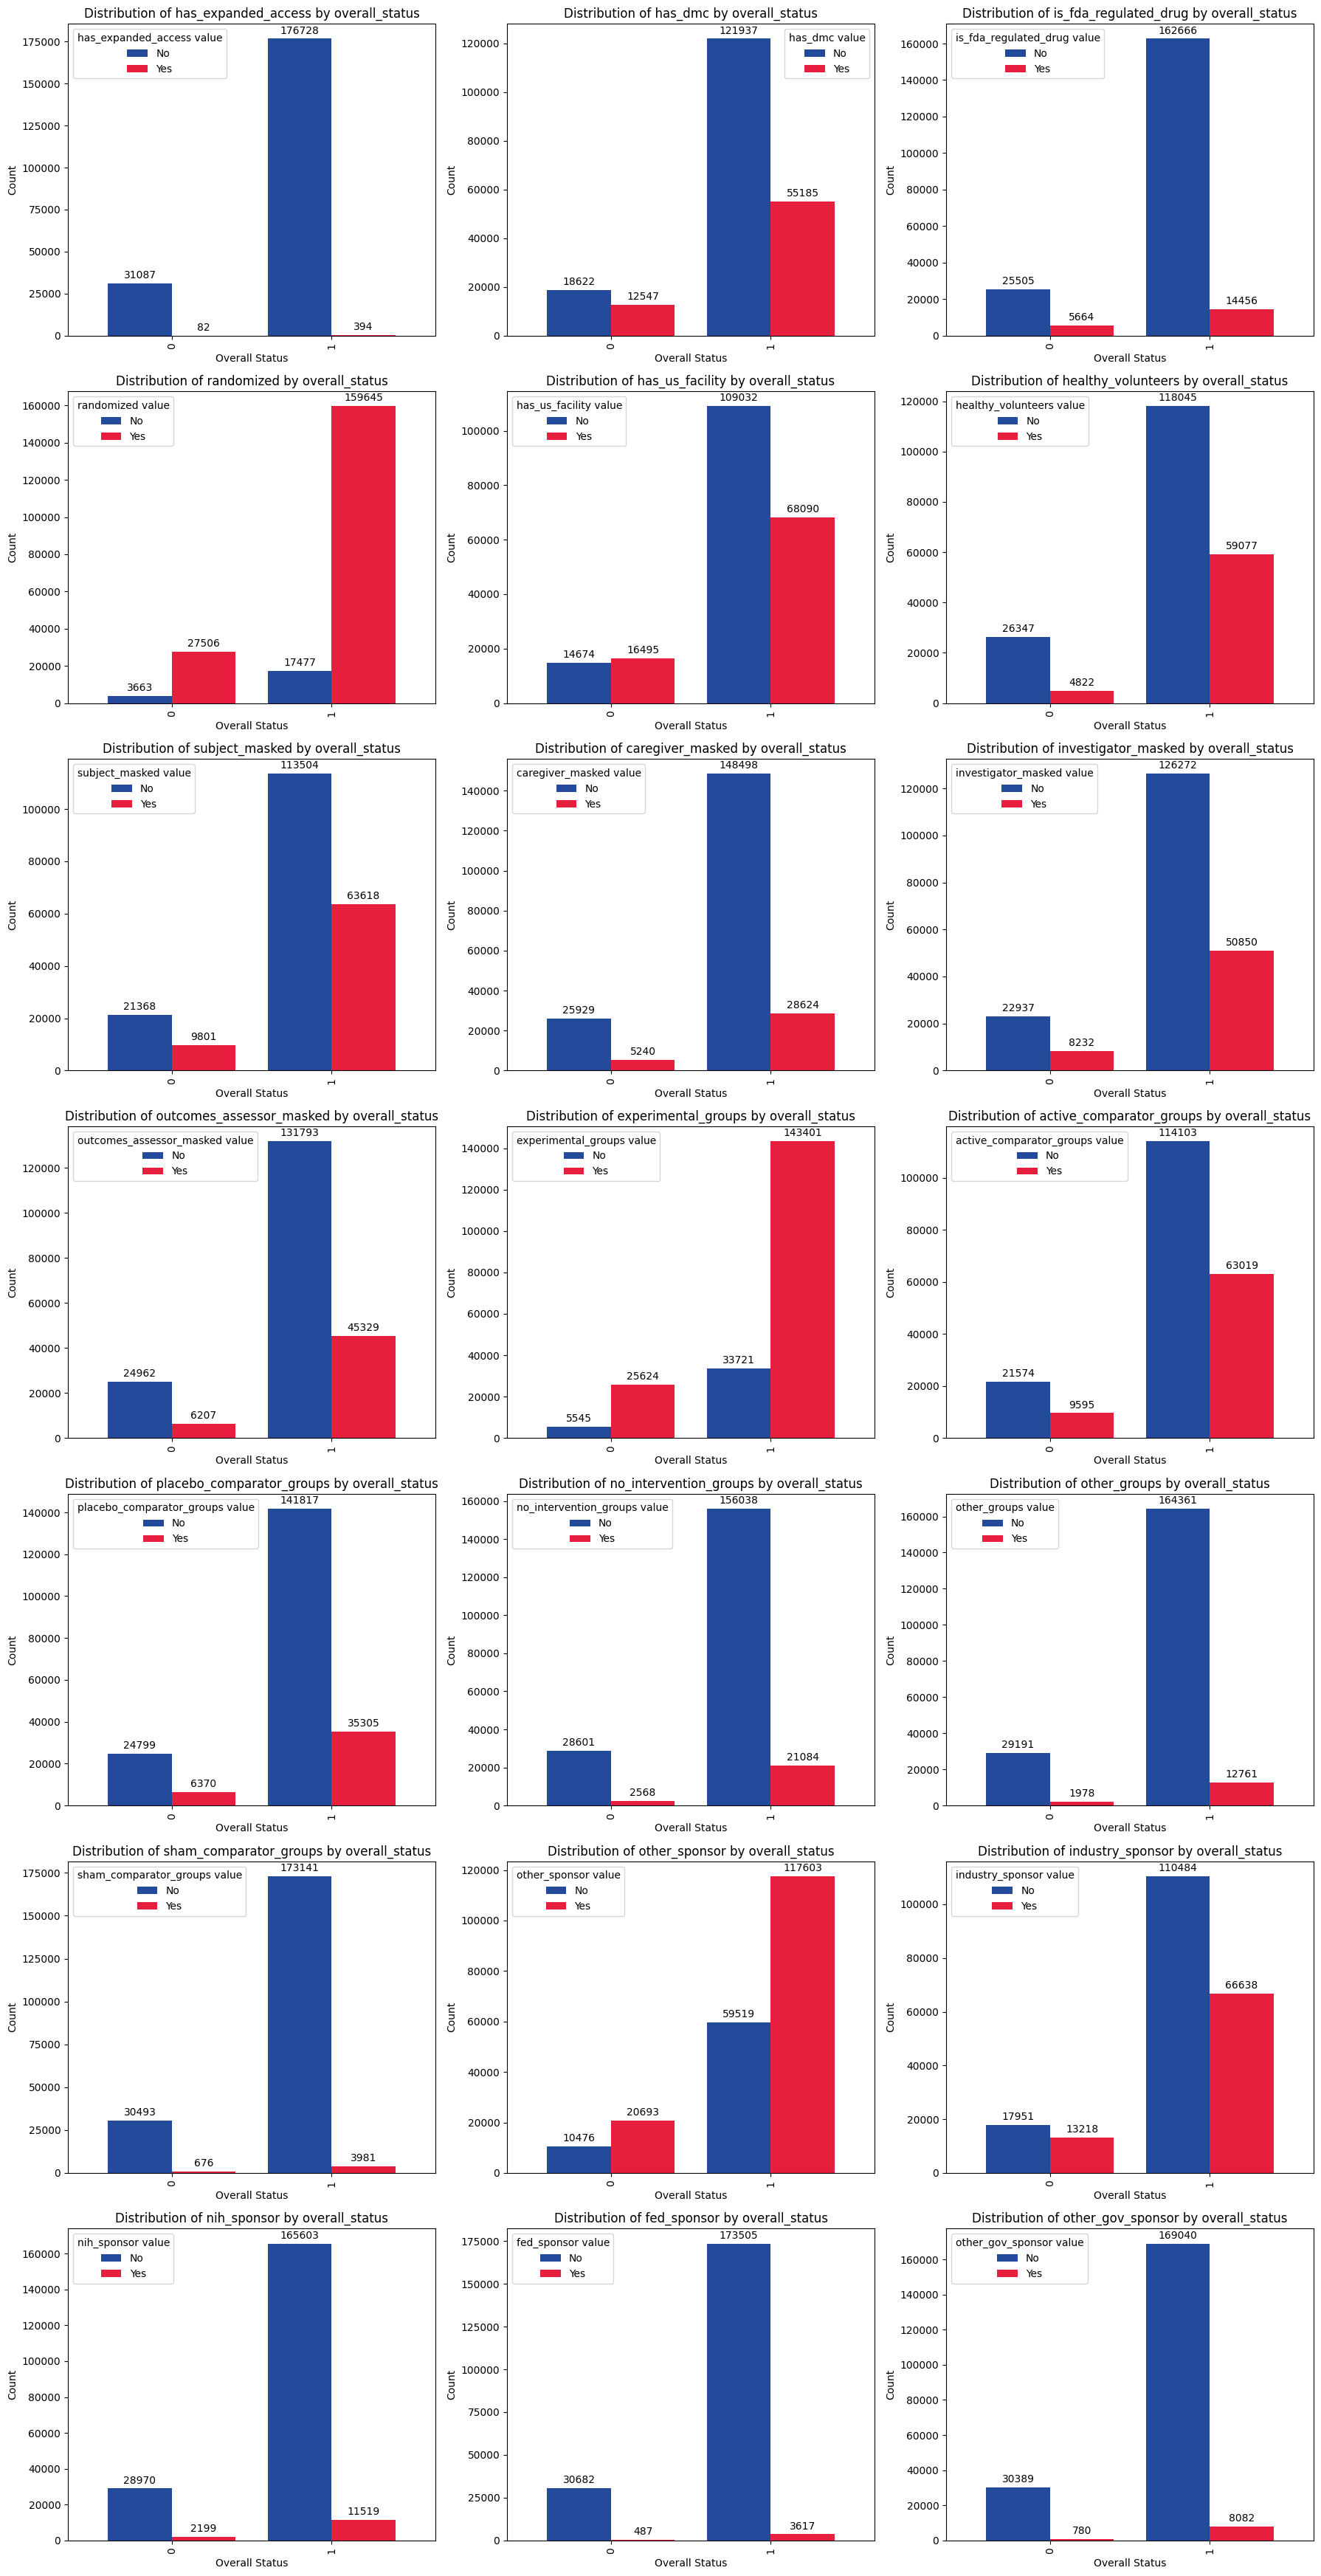

In [484]:
# Количество строк и столбцов для графиков
n_features = len(binary_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Создание фигуры и осей
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

def add_value_labels(ax, spacing=5):
    """Добавление меток к каждому бару в столбчатой диаграмме."""
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Номер, который будет отображаться на метке
        label = "{:.0f}".format(y_value)

        # Создание аннотации
        ax.annotate(
            label,                      # Используйте `label` как метку
            (x_value, y_value),         # Разместите метку на вершине столбца
            textcoords="offset points", # Интерпретируйте xytext как смещение в точках
            xytext=(0,spacing),         # Смещение метки на некоторое расстояние выше бара
            ha='center')                # Выровнять метку по центру столбца

for i, feature in enumerate(binary_features):
    # Подсчёт количества по каждой комбинации таргета и признака
    counts = data_new_07.groupby(['overall_status', feature]).size().unstack(fill_value=0)

    # Построение столбчатой диаграммы
    counts.plot(kind='bar', ax=axes[i], width=0.8, color=['#234a9b', '#e61f3e'])  # Мягкие цвета
    axes[i].set_title(f'Distribution of {feature} by overall_status')
    axes[i].set_xlabel('Overall Status')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=f'{feature} value', labels=['No', 'Yes'])

    # Добавление меток на столбцы
    add_value_labels(axes[i])

# Удаляем лишние оси, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Отображение графика
plt.tight_layout()
plt.show()

In [252]:
# Отделяем настоящие бинарные от категориальных:
true_binary = binary_features[:10]
bin_cat_groups = binary_features[10:16]
bin_cat_sponsor = binary_features[16:]

In [253]:
# Проверка:
len(binary_features) == len(true_binary) + len(bin_cat_groups) + len(bin_cat_sponsor)

True

### Group types:

In [258]:
bin_cat_groups

['experimental_groups',
 'active_comparator_groups',
 'placebo_comparator_groups',
 'no_intervention_groups',
 'other_groups',
 'sham_comparator_groups']

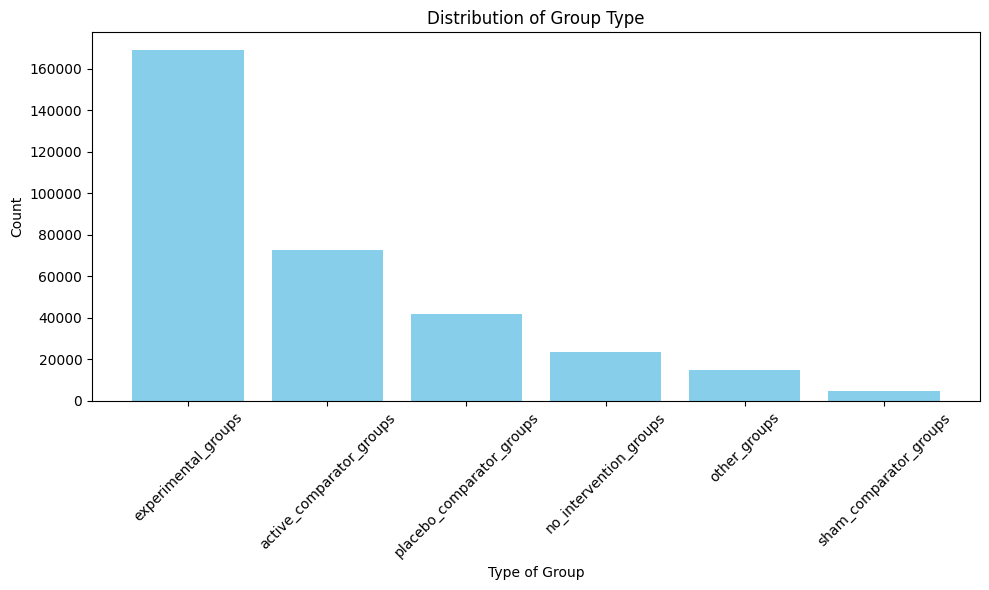

In [259]:
# Подсчет количества единиц в каждой колонке
counts = data_new_07[bin_cat_groups].sum()

# Создание барплота
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, color='skyblue')
plt.title('Distribution of Group Type')
plt.xlabel('Type of Group')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Поворот подписей оси X для лучшей читаемости
plt.tight_layout()  # Авто-регулировка для предотвращения наложения элементов
plt.show()

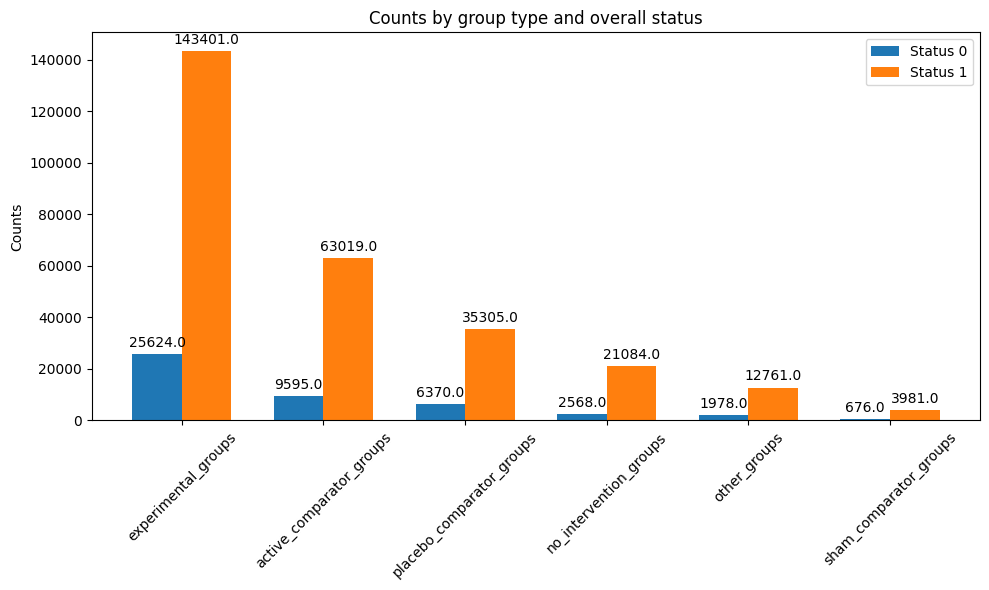

In [260]:
# Суммируем количество для каждой категории с разделением по overall_status
counts = data_new_07.groupby('overall_status')[bin_cat_groups].sum().T

# Строим график
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  # ширина столбцов
x = np.arange(len(bin_cat_groups))  # метки по оси X

# Создаем столбцы для каждого статуса
rects1 = ax.bar(x - width/2, counts[0], width, label='Status 0')
rects2 = ax.bar(x + width/2, counts[1], width, label='Status 1')

# Добавляем подписи, заголовок и легенду
ax.set_ylabel('Counts')
ax.set_title('Counts by group type and overall status')
ax.set_xticks(x)
ax.set_xticklabels(bin_cat_groups, rotation=45)
ax.legend()

# Функция для добавления подписей над столбцами
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

### Sponsor:

In [261]:
bin_cat_sponsor

['other_sponsor',
 'industry_sponsor',
 'nih_sponsor',
 'fed_sponsor',
 'other_gov_sponsor']

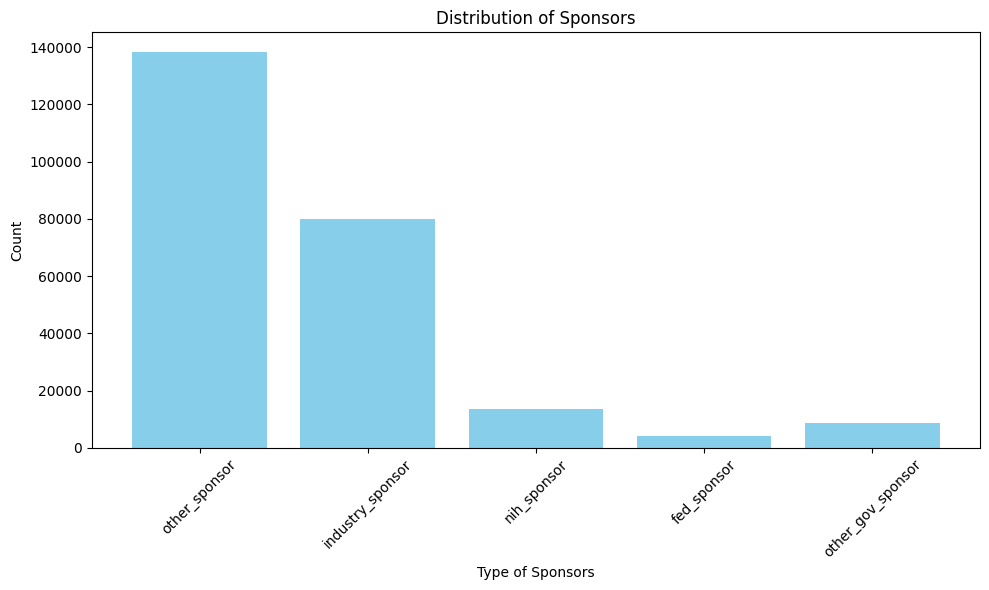

In [262]:
# Подсчет количества единиц в каждой колонке
counts = data_new_07[bin_cat_sponsor].sum()

# Создание барплота
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, color='skyblue')
plt.title('Distribution of Sponsors')
plt.xlabel('Type of Sponsors')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Поворот подписей оси X для лучшей читаемости
plt.tight_layout()  # Авто-регулировка для предотвращения наложения элементов
plt.show()

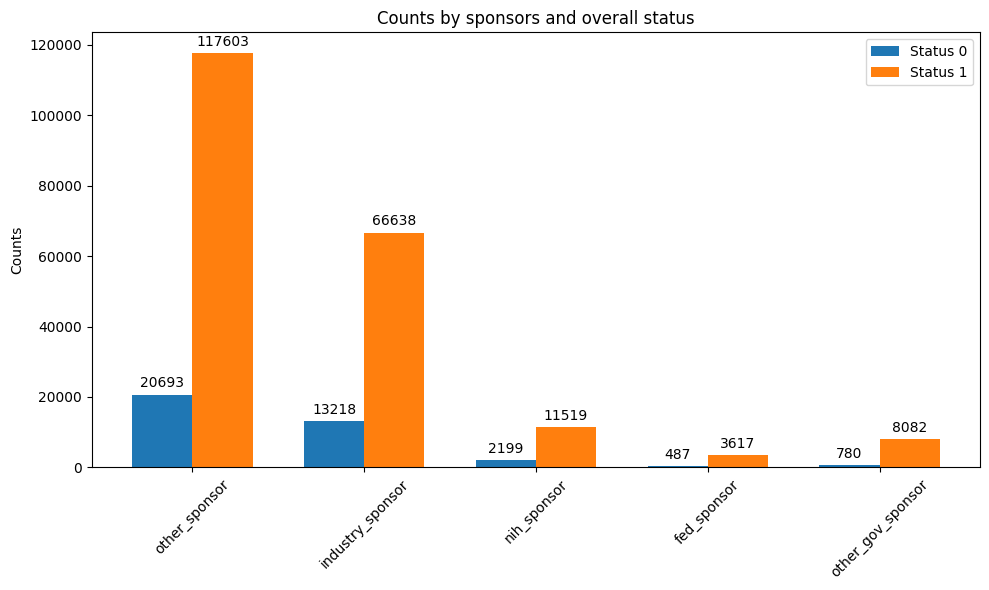

In [263]:
# Суммируем количество для каждой категории с разделением по overall_status
counts = data_new_07.groupby('overall_status')[bin_cat_sponsor].sum().T

# Строим график
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  # ширина столбцов
x = np.arange(len(bin_cat_sponsor))  # метки по оси X

# Создаем столбцы для каждого статуса
rects1 = ax.bar(x - width/2, counts[0], width, label='Status 0')
rects2 = ax.bar(x + width/2, counts[1], width, label='Status 1')

# Добавляем подписи, заголовок и легенду
ax.set_ylabel('Counts')
ax.set_title('Counts by sponsors and overall status')
ax.set_xticks(x)
ax.set_xticklabels(bin_cat_sponsor, rotation=45)
ax.legend()

# Функция для добавления подписей над столбцами
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Создание поддатасетов data_Phase:

## data_Phase1:

In [264]:
#data_Phase1 = data_new_07[(data_new_07.phase=='Phase 1')]
data_Phase1 = data_new_07[(data_new_07.phase=='Phase 1') | (data_new_07.phase=='Phase 1/Phase 2') | (data_new_07.phase=='Early Phase 1')]

In [265]:
# Убираем колонку с фазами: 
data_Phase1.drop('phase', axis=1, inplace=True)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_90832/3989206563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Phase1.drop('phase', axis=1, inplace=True)


In [266]:
data_Phase1.head()
data_Phase1.shape

(37931, 41)

In [267]:
data_Phase1.head()

brief_title  official_title overall_status  number_of_arms  \
3            95           140.0              1             1.0   
8            70           145.0              1             1.0   
9            80           123.0              1             2.0   
11          101           157.0              1             3.0   
14           69           159.0              1             4.0   

    has_expanded_access  has_dmc  is_fda_regulated_drug source_class  \
3                     0        0                      0     INDUSTRY   
8                     0        0                      0     INDUSTRY   
9                     0        0                      0     INDUSTRY   
11                    0        0                      0     INDUSTRY   
14                    0        1                      0     INDUSTRY   

    brief_summaries  detailed_descriptions  ...  sham_comparator_groups  \
3               201            1871.889101  ...                     0.0   
8               290            1871.889101  ...                     0.0   
9              1006            1963.000000  ...                     0.0   
11              723            1871.889101  ...                     0.0   
14              206             836.000000  ...                     0.0   

    number_of_countries  other_sponsor  industry_sponsor  nih_sponsor  \
3                   1.0              0                 1            0   
8                   1.0              0                 1            0   
9                   1.0              0                 1            0   
11                  1.0              0                 1            0   
14                  1.0              0                 1            0   

    fed_sponsor  other_gov_sponsor  non_inferiority_type n_inclusion  \
3             0                  0  superiority_or_other         4.0   
8             0                  0  superiority_or_other         1.0   
9             0                  0  superiority_or_other        11.0   
11            0                  0  superiority_or_other         5.0   
14            0                  0  superiority_or_other         7.0   

    n_exclusion  
3           9.0  
8           1.0  
9           5.0  
11         10.0  
14         14.0  

[5 rows x 41 columns]

## data_Phase 2:

In [958]:
data_Phase2 = data_new_07[(data_new_07.phase=='Phase 2') | (data_new_07.phase=='Phase 2/Phase 3')]

In [959]:
# Убираем колонку с фазами: 
data_Phase2.drop('phase', axis=1, inplace=True)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_32092/3148317025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Phase2.drop('phase', axis=1, inplace=True)


In [960]:
data_Phase2.head()
data_Phase2.shape

(32751, 41)

## data_Phase 3:

In [893]:
data_Phase3 = data_new_07[(data_new_07.phase=='Phase 3')]

In [894]:
# Убираем колонку с фазами: 
data_Phase3.drop('phase', axis=1, inplace=True)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_32092/1515890740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Phase3.drop('phase', axis=1, inplace=True)


In [895]:
data_Phase3.head()
data_Phase3.shape

(20345, 41)

## data_Phase 4:

In [896]:
data_Phase4 = data_new_07[(data_new_07.phase=='Phase 4')]

In [897]:
# Убираем колонку с фазами: 
data_Phase4.drop('phase', axis=1, inplace=True)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_32092/339438176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Phase4.drop('phase', axis=1, inplace=True)


In [898]:
data_Phase4.head()
data_Phase4.shape

(18928, 41)

# Таргетная переменная:

### data_Phase1:

In [268]:
data_Phase1.overall_status.value_counts(normalize=True)

overall_status
1    0.837099
0    0.162901
Name: proportion, dtype: float64

In [269]:
data_Phase1.overall_status.value_counts()

overall_status
1    31752
0     6179
Name: count, dtype: int64

In [270]:
data_Phase1.overall_status.value_counts()[0] / (data_Phase1.overall_status.value_counts()[1] + data_Phase1.overall_status.value_counts()[0])

0.16290105718277925

### data_Phase3:

In [2408]:
data_Phase3.overall_status.value_counts(normalize=True)

overall_status
Completed     0.823054
Terminated    0.120406
Withdrawn     0.056540
Name: proportion, dtype: float64

In [2410]:
data_Phase3.overall_status.value_counts()

overall_status
1    13145
0     2826
Name: count, dtype: int64

In [2411]:
data_Phase3.overall_status.value_counts()[0] / (data_Phase3.overall_status.value_counts()[1] + data_Phase3.overall_status.value_counts()[0])

0.1769457141068186

# Machine Learning

## Сохранение модели, преодобработки, параметров и полученных результатов:

In [60]:
results_df = pd.DataFrame(columns=['Model',
                                   'Hyperparameters',
                                   'Classification threshold',
                                   'ROC-AUC',
                                   'F1 Score',
                                   'Balanced Accuracy',
                                   'Recall for Class 0',
                                   'Accuracy for Class 0',
                                   'Accuracy for Class 1',
                                   'Recall for Class 1'
                                  ])

<h1 style="color:Blue">LogRegression:</h1>


In [272]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase1.drop('overall_status', axis=1)
y = data_Phase1['overall_status']

y = y.astype(int)

## Разделение на обучающую и валидационную выборки:

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Транформер, модель, catboost_pipeline:

In [274]:
# напоминание про состав списков колонок:
print(f'categorical_features_all: {categorical_features_all}')
print(f'categorical_features_OHE: {categorical_features_OHE}')
print(f'categorical_features_target: {categorical_features_target}')

print(f'numeric_features_all: {numeric_features_all}')

categorical_features_all: ['gender', 'masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
categorical_features_OHE: ['gender']
categorical_features_target: ['masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
numeric_features_all: ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions', 'n_inclusion', 'n_exclusion', 'number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries']


In [275]:
# Трансформер:
transformer_logreg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_all),
        ('ohr', OneHotEncoder(), categorical_features_OHE),
        ('target', TargetEncoder(), categorical_features_target)
    ],
    remainder='passthrough'
)

In [276]:
# Model:
logreg_model = LogisticRegression(
    penalty='l2',         # Specifies the norm used in the penalization (l2 is the standard Ridge regression)
    C=1.0,                # Inverse of regularization strength; smaller values specify stronger regularization
    solver='lbfgs',       # Algorithm to use in the optimization problem; 'lbfgs' is good for large datasets
    max_iter=100,         # Maximum number of iterations taken for the solvers to converge
    random_state=None,    # Seed of the pseudo random number generator to use when shuffling the data
    verbose=100             # For liblinear and lbfgs solvers, set verbose to any positive number for verbosity
)

In [277]:

# Transformer setup
transformer_logreg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_all),
        ('ohr', OneHotEncoder(), categorical_features_OHE),
        ('target', TargetEncoder(), categorical_features_target)
    ],
    remainder='passthrough'
)

# Correctly setting up the logistic regression model
logreg_model = LogisticRegression(
    penalty='l2',         # Specifies the norm used in the penalization
    C=1.0,                # Inverse of regularization strength
    solver='lbfgs',       # Algorithm to use in the optimization problem
    max_iter=300,         # Maximum number of iterations
    random_state=None,    # Seed for random number generator
    verbose=0           # Verbosity level
)

# Pipeline using the specified logistic regression model
logreg_pipeline = Pipeline([
    ('preprocessor', transformer_logreg),
    ('classifier', logreg_model)  # Use the configured model here
])


In [278]:
# обучение модели
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['brief_title',
                                                   'official_title',
                                                   'brief_summaries',
                                                   'detailed_descriptions',
                                                   'n_inclusion', 'n_exclusion',
                                                   'number_of_arms',
                                                   'number_of_facilities',
                                                   'minimum_age_in_years',
                                                   'maximum_age_in_years',
                                                   'number_of_primary_outcomes_to_measure',
                                                   'number_of_secondary_outcomes_to_measure',
                                                   'number_of_countries']),
                                                 ('ohr', OneHotEncoder(),
                                                  ['gender']),
                                                 ('target', TargetEncoder(),
                                                  ['masking',
                                                   'responsible_party_type',
                                                   'source_class',
                                                   'intervention_model',
                                                   'non_inferiority_type'])])),
                ('classifier', LogisticRegression(max_iter=300))])

### Подбор гиперпараметров: 

In [279]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'classifier__penalty' : ['l2'], #'l1'
    'classifier__C' : [1.0], # 1.0 2
    'classifier__max_iter': [300, 400], 
    'classifier__solver': ['lbfgs', 'liblinear'], #'lbfgs', 'liblinear', class_weight='balanced'
    'classifier__class_weight': ['balanced']
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=40
)

# Обучение с поиском по сетке
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший score: {grid_search.best_score_}")

# Получение лучшей модели
best_logreg_pipeline = grid_search.best_estimator_

# Лучшие параметры: {'classifier__C': 2.0, 'classifier__max_iter': 200, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
# Лучший score: 0.910721187867641

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START classifier__C=1.0, classifier__class_weight=balanced, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs
[CV 1/3; 1/4] END classifier__C=1.0, classifier__class_weight=balanced, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.734 total time=   1.6s
[CV 2/3; 1/4] START classifier__C=1.0, classifier__class_weight=balanced, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs
[CV 2/3; 1/4] END classifier__C=1.0, classifier__class_weight=balanced, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=0.733 total time=   1.8s
[CV 3/3; 1/4] START classifier__C=1.0, classifier__class_weight=balanced, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs
[CV 3/3; 1/4] END classifier__C=1.0, classifier__class_weight=balanced, classifier__max_iter=300, classifier__penalty=l2, classifier_

### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [280]:
# Предсказание модели с порогом 0.5:
pred_prob = best_logreg_pipeline.predict_proba(X_train)

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [281]:
# Предсказания для разных порогов классификкации:
thresholds = [0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_train'] = np.array(y_train)

In [282]:
#print(df_probs_threshs.to_string())

In [283]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

# For threshold 0.8:
# Accuracy Score: 0.71
# Recall Score_0: 0.66
# Precision Score_0: 0.31
# Recall Score_1: 0.72
# Precision Score_1: 0.92
# F1 Score: 0.81
# ROC-AUC: 0.69

For threshold 0.7:
Accuracy Score: 0.46
Recall Score_0: 0.91
Precision Score_0: 0.22
Recall Score_1: 0.37
Precision Score_1: 0.95
F1 Score: 0.53
ROC-AUC: 0.64

For threshold 0.71:
Accuracy Score: 0.44
Recall Score_0: 0.92
Precision Score_0: 0.22
Recall Score_1: 0.35
Precision Score_1: 0.96
F1 Score: 0.51
ROC-AUC: 0.63

For threshold 0.72:
Accuracy Score: 0.43
Recall Score_0: 0.92
Precision Score_0: 0.21
Recall Score_1: 0.33
Precision Score_1: 0.96
F1 Score: 0.49
ROC-AUC: 0.63

For threshold 0.73:
Accuracy Score: 0.41
Recall Score_0: 0.93
Precision Score_0: 0.21
Recall Score_1: 0.31
Precision Score_1: 0.96
F1 Score: 0.47
ROC-AUC: 0.62

For threshold 0.74:
Accuracy Score: 0.4
Recall Score_0: 0.94
Precision Score_0: 0.21
Recall Score_1: 0.29
Precision Score_1: 0.96
F1 Score: 0.45
ROC-AUC: 0.61

For threshold 0.75:
Accuracy Score: 0.38
Recall Score_0: 0.94
Precision Score_0: 0.2
Recall Score_1: 0.27
Precision Score_1: 0.96
F1 Score: 0.43
ROC-AUC: 0.61

For threshold 0.76:
Accuracy Score: 0

In [284]:
# Выбранный лучший порог:
best_tresh = 0.75

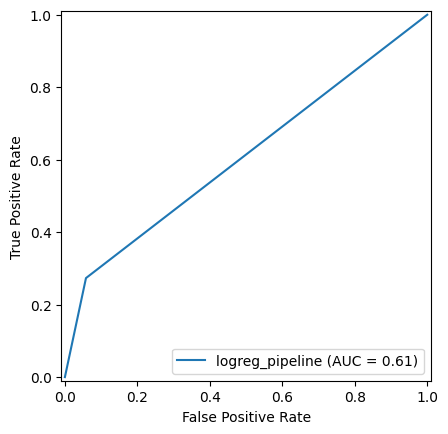

In [285]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_train, df_probs_threshs[best_tresh])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

## Предсказания с лучшим порогом классификации:

In [286]:
probs_test = best_logreg_pipeline.predict_proba(X_test)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds = (probs_test >= best_tresh).astype(int)


## Оценка предсказаний (с лучшим порогом классификации):

In [287]:
recall0 = round(recall_score(y_test, preds, pos_label=0), 2)
recall1 = round(recall_score(y_test, preds, pos_label=1), 2)
acc = round(accuracy_score(y_test, preds), 2)
balanced_acc = round(balanced_accuracy_score(y_test, preds), 2)

f1 = round(f1_score(y_test, preds), 2)
rocauc = round(roc_auc_score(y_test, preds), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_test, preds)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

Recall Score0: 0.95
Recall Score1: 0.28

Balanced Accuracy Score: 0.61
F1 Score: 0.43
ROC-AUC: 0.61

Accuracy Score: 0.39
Accuracy for Class 0: 0.95
Accuracy for Class 1: 0.28


#### Оценка для обучающего сета:

In [288]:
probs_train = best_logreg_pipeline.predict_proba(X_train)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds_train = (probs_train >= best_tresh).astype(int)

In [289]:
recall0 = round(recall_score(y_train, preds_train, pos_label=0), 2)
recall1 = round(recall_score(y_train, preds_train, pos_label=1), 2)
acc = round(accuracy_score(y_train, preds_train), 2)
balanced_acc = round(balanced_accuracy_score(y_train, preds_train), 2)

f1 = round(f1_score(y_train, preds_train), 2)
rocauc = round(roc_auc_score(y_train, preds_train), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_train, preds_train)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

Recall Score0: 0.94
Recall Score1: 0.27

Balanced Accuracy Score: 0.61
F1 Score: 0.43
ROC-AUC: 0.61

Accuracy Score: 0.38
Accuracy for Class 0: 0.94
Accuracy for Class 1: 0.27


## crossvalidation:

In [290]:
from sklearn.model_selection import cross_validate

In [291]:
# Выполнение кросс-валидации
y_probas = cross_val_predict(best_logreg_pipeline, X, y, cv=5, method='predict_proba')
y_scores = y_probas[:, 1]  # Вероятности для класса 1


y_pred = cross_val_predict(best_logreg_pipeline, X, y, cv=5, method='predict')

In [292]:
# предсказания с учетом порога:
y_pred = (y_scores >= best_tresh).astype(int)


In [293]:
cm = confusion_matrix(y, y_pred)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])



In [294]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_scores)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()




ROC-AUC: 0.74
F1 Score: 0.44

Balanced Accuracy: 0.61

Recall for Class 0: 0.94

Accuracy for Class 0: 0.94
Accuracy for Class 1: 0.29
Recall for Class 1: 0.29



## Save results:

In [85]:
params = grid_search.best_params_
to_safe = ''
for key, value in params.items():
    name = key.split('__')[-1]
    #print(f'{name}={value}')
    to_safe += f'{name}={value}, '

to_safe = to_safe[:-2]
print(to_safe)

C=3.0, max_iter=300, penalty=l2, solver=lbfgs


In [89]:
# Значения, которые нужно добавить:
model_results = {
    "Model": "Logistic Regression",
    "Hyperparameters": to_safe,
    "Classification threshold": best_tresh,
    "ROC-AUC": round(rocauc, 2),
    "F1 Score": round(f1, 2),
    "Balanced Accuracy": round(balanced_acc, 2),
    "Recall for Class 0": round(recall0, 2),
    "Accuracy for Class 0": round(accuracy_class_0, 2),
    "Accuracy for Class 1": round(accuracy_class_1, 2),
    "Recall for Class 1": round(recall1, 2)
    }

# Вычисление следующего индекса для новой строки
next_index = len(results_df)

# Добавление новой строки в DataFrame
#results_df.loc[next_index] = model_results

In [90]:
results_df

Model                                Hyperparameters  \
0  Logistic Regression  C=3.0, max_iter=300, penalty=l2, solver=lbfgs   

   Classification threshold  ROC-AUC  F1 Score  Balanced Accuracy  \
0                      0.84     0.74      0.73               0.68   

   Recall for Class 0  Accuracy for Class 0  Accuracy for Class 1  \
0                0.75                  0.75                   0.6   

   Recall for Class 1  
0                 0.6

## feature analysis:

In [91]:
# достаем название фичей из трансформированных данных:
name_f_after_trans = logreg_pipeline[:-1].get_feature_names_out()

In [92]:
model = logreg_pipeline.named_steps['classifier']
coefficients = model.coef_[0]  # This extracts the coefficients for the model

# Get feature names after transformations
feature_names = logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for better visibility of features and their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance.sort_values(by='Coefficient', key=abs, ascending=False, inplace=True)  # Sorting by absolute values


In [93]:
# Assuming your pipeline and model have already been fit:
model = logreg_pipeline.named_steps['classifier']
feature_names = logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Coefficients from logistic regression
coefficients = model.coef_[0]


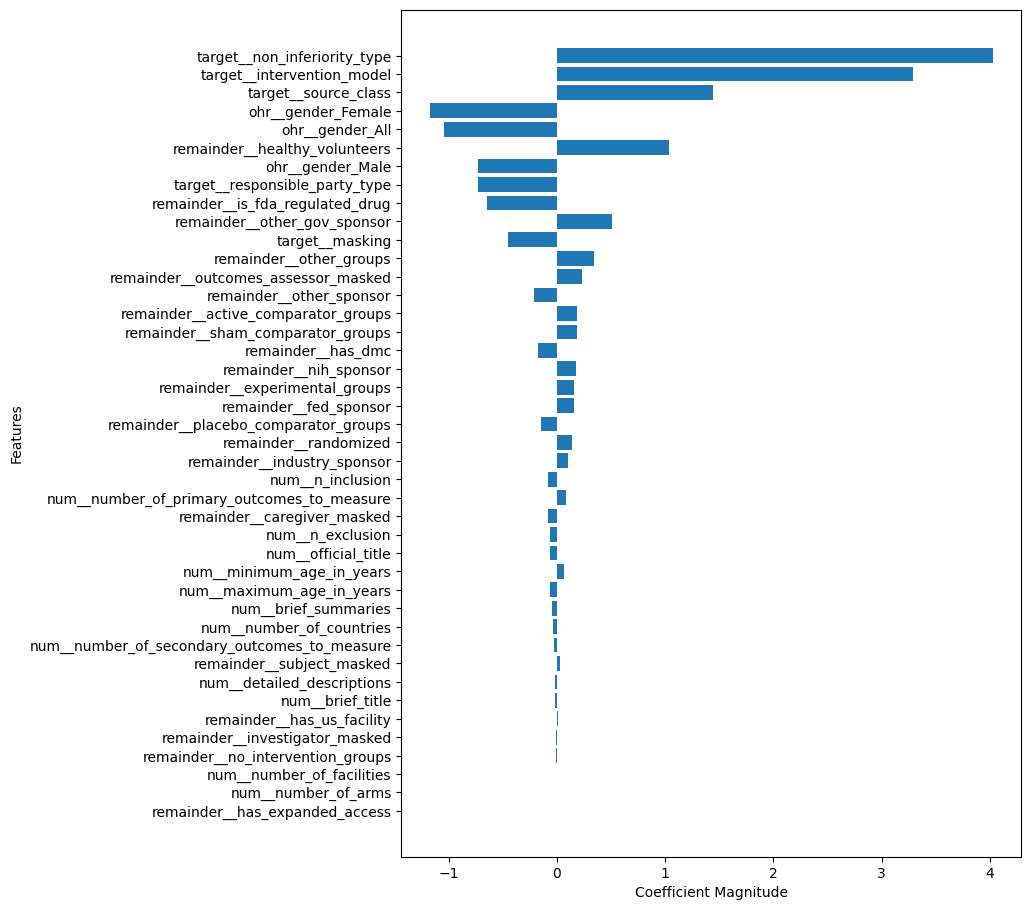

In [378]:

# Sorting the coefficients along with their corresponding feature names
sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # Sorting by absolute value for impact
sorted_importances = coefficients[sorted_indices]
sorted_names = feature_names[sorted_indices]

# Visualization of feature importances (or in this case, coefficient magnitudes)
fig = plt.figure(figsize=(8, 11))
plt.barh(sorted_names, sorted_importances)  # Using horizontal bar chart for better readability
plt.xlabel('Coefficient Magnitude')  # Change label to reflect that these are coefficients, not importances
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Inverts y-axis so highest values are at the top
plt.show()


/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


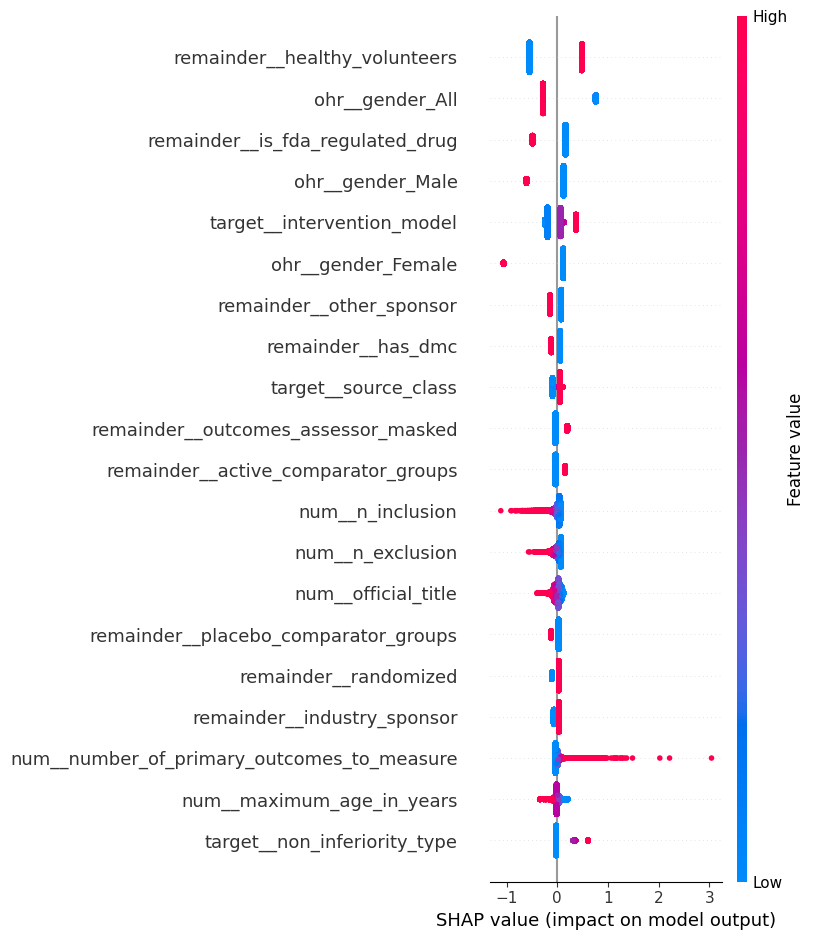

In [377]:
import shap

# Assuming 'model' is your trained Logistic Regression model and X_train is your training dataset
model = logreg_pipeline.named_steps['classifier']
X_train_transformed = logreg_pipeline.named_steps['preprocessor'].transform(X_train)

# Use LinearExplainer for logistic regression
explainer = shap.LinearExplainer(model, X_train_transformed, feature_perturbation="interventional")

shap_values = explainer.shap_values(X_train_transformed)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)
# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_transformed[0,:], feature_names=feature_names)


<h1 style="color:orange">Random Forest:</h1>



In [1014]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase2.drop('overall_status', axis=1)
y = data_Phase2['overall_status']

y = y.astype(int)

## Разделение на обучающий и тестовый датасеты:

In [1015]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Транформер, модель, rf_pipeline:

In [1016]:
# напоминание про состав списков колонок:
print(f'categorical_features_all: {categorical_features_all}')
print(f'categorical_features_OHE: {categorical_features_OHE}')
print(f'categorical_features_target: {categorical_features_target}')

print(f'numeric_features_all: {numeric_features_all}')

categorical_features_all: ['gender', 'masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
categorical_features_OHE: ['gender']
categorical_features_target: ['masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
numeric_features_all: ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions', 'n_inclusion', 'n_exclusion', 'number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries']


In [1017]:
# Трансформер:
transformer_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_all),
        ('ohr', OneHotEncoder(), categorical_features_OHE),
        ('target', TargetEncoder(), categorical_features_target)
    ],
    remainder='passthrough'
)

In [1018]:
# Model:
rf_model = RandomForestClassifier(
        n_estimators=1000,
        max_depth=5,
        class_weight='balanced',
        min_samples_split=2,
        min_samples_leaf=5,
        max_leaf_nodes=2400,
        verbose=0
    )

In [1019]:
# Pipeline:
rf_pipeline = Pipeline([
    ('preprocessor', transformer_rf),
    ('classifier', rf_model) 
])


In [1020]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['brief_title',
                                                   'official_title',
                                                   'brief_summaries',
                                                   'detailed_descriptions',
                                                   'n_inclusion', 'n_exclusion',
                                                   'number_of_arms',
                                                   'number_of_facilities',
                                                   'minimum_age_in_years',
                                                   'maximum_age_in_years',
                                                   'number_of_primary_outcomes_to_measure',
                                                   'number_of_secondary_outcomes_to_measure',
                                                   'number_of_countries']),
                                                 ('ohr', OneHotEncoder(),
                                                  ['gender']),
                                                 ('target', TargetEncoder(),
                                                  ['masking',
                                                   'responsible_party_type',
                                                   'source_class',
                                                   'intervention_model',
                                                   'non_inferiority_type'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        max_leaf_nodes=2400, min_samples_leaf=5,
                                        n_estimators=1000))])

### Подбор гиперпараметров: 

In [1023]:
param_grid = {
    'classifier__n_estimators' : [700, 800], #1300, 
    'classifier__max_depth' : [5, 4], #3 4
    'classifier__min_samples_split' : [2, 1], # 3,4
    'classifier__min_samples_leaf' : [5, None], #1,3,7,6,4
    'classifier__max_leaf_nodes' : [2000, 2100] #100,500,1000,2500, 2000, 2100, 2200, 2300, 
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=10
)

# Обучение с поиском по сетке
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший score: {grid_search.best_score_}")

# Получение лучшей модели
best_rf_pipeline = grid_search.best_estimator_



# {'classifier__max_depth': 5, 'classifier__max_leaf_nodes': 1000, 'classifier__min_samples_leaf': 5, 
#  'classifier__min_samples_split': 2, 'classifier__n_estimators': 1000}

# 'classifier__n_estimators' : [1000, 1100], 
#     'classifier__max_depth' : [3, 4, 5],
#     'classifier__min_samples_split' : [2,3,4],
#     'classifier__min_samples_leaf' : [1,3,5],
#     'classifier__max_leaf_nodes' : [100,500,1000]

# {'classifier__max_depth': 5, 'classifier__max_leaf_nodes': 2000, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 
#  'classifier__n_estimators': 1000}

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3; 1/32] START classifier__max_depth=5, classifier__max_leaf_nodes=2000, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=700
[CV 1/3; 1/32] END classifier__max_depth=5, classifier__max_leaf_nodes=2000, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=700;, score=0.745 total time=   4.2s
[CV 2/3; 1/32] START classifier__max_depth=5, classifier__max_leaf_nodes=2000, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=700
[CV 2/3; 1/32] END classifier__max_depth=5, classifier__max_leaf_nodes=2000, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=700;, score=0.749 total time=   4.0s
[CV 3/3; 1/32] START classifier__max_depth=5, classifier__max_leaf_nodes=2000, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=700
[CV 3/3; 1/3

/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
72 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/pipeline.p

Лучшие параметры: {'classifier__max_depth': 5, 'classifier__max_leaf_nodes': 2100, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 800}
Лучший score: 0.7514046042542555


### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [1024]:
# Предсказание модели с порогом 0.5:
pred_prob = best_rf_pipeline.predict_proba(X_train)

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [1025]:
# Предсказания для разных порогов классификкации:
thresholds = [0.4, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.6, 0.7, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_train'] = np.array(y_train)

In [1026]:
#print(df_probs_threshs.to_string())

In [1027]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

For threshold 0.4:
Accuracy Score: 0.77
Recall Score_0: 0.22
Precision Score_0: 0.5
Recall Score_1: 0.93
Precision Score_1: 0.8
F1 Score: 0.86
ROC-AUC: 0.58

For threshold 0.42:
Accuracy Score: 0.76
Recall Score_0: 0.29
Precision Score_0: 0.48
Recall Score_1: 0.9
Precision Score_1: 0.81
F1 Score: 0.85
ROC-AUC: 0.6

For threshold 0.43:
Accuracy Score: 0.75
Recall Score_0: 0.33
Precision Score_0: 0.46
Recall Score_1: 0.88
Precision Score_1: 0.81
F1 Score: 0.84
ROC-AUC: 0.61

For threshold 0.44:
Accuracy Score: 0.74
Recall Score_0: 0.38
Precision Score_0: 0.44
Recall Score_1: 0.85
Precision Score_1: 0.82
F1 Score: 0.83
ROC-AUC: 0.62

For threshold 0.45:
Accuracy Score: 0.73
Recall Score_0: 0.43
Precision Score_0: 0.42
Recall Score_1: 0.82
Precision Score_1: 0.82
F1 Score: 0.82
ROC-AUC: 0.62

For threshold 0.46:
Accuracy Score: 0.72
Recall Score_0: 0.47
Precision Score_0: 0.41
Recall Score_1: 0.8
Precision Score_1: 0.83
F1 Score: 0.81
ROC-AUC: 0.63

For threshold 0.47:
Accuracy Score: 0.71

/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

For threshold 0.79:
Accuracy Score: 0.23
Recall Score_0: 1.0
Precision Score_0: 0.23
Recall Score_1: 0.0
Precision Score_1: 0.0
F1 Score: 0.0
ROC-AUC: 0.5

For threshold 0.8:
Accuracy Score: 0.23
Recall Score_0: 1.0
Precision Score_0: 0.23
Recall Score_1: 0.0
Precision Score_1: 0.0
F1 Score: 0.0
ROC-AUC: 0.5

For threshold 0.81:
Accuracy Score: 0.23
Recall Score_0: 1.0
Precision Score_0: 0.23
Recall Score_1: 0.0
Precision Score_1: 0.0
F1 Score: 0.0
ROC-AUC: 0.5

For threshold 0.82:
Accuracy Score: 0.23
Recall Score_0: 1.0
Precision Score_0: 0.23
Recall Score_1: 0.0
Precision Score_1: 0.0
F1 Score: 0.0
ROC-AUC: 0.5

For threshold 0.83:
Accuracy Score: 0.23
Recall Score_0: 1.0
Precision Score_0: 0.23
Recall Score_1: 0.0
Precision Score_1: 0.0
F1 Score: 0.0
ROC-AUC: 0.5

For threshold 0.84:
Accuracy Score: 0.23
Recall Score_0: 1.0
Precision Score_0: 0.23
Recall Score_1: 0.0
Precision Score_1: 0.0
F1 Score: 0.0
ROC-AUC: 0.5

For threshold 0.85:
Accuracy Score: 0.23
Recall Score_0: 1.0
Prec

/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [400]:
# Выбранный лучший порог:
best_tresh = 0.45

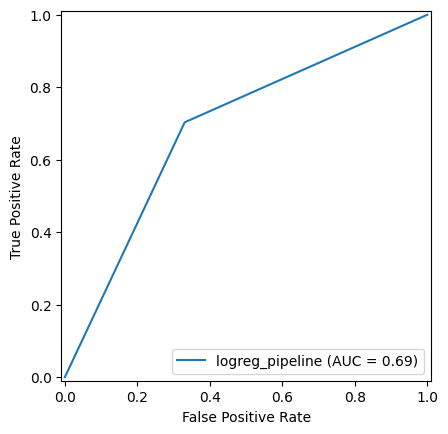

In [109]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_train, df_probs_threshs[best_tresh])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

## Предсказания с лучшим порогом классификации:

In [401]:
probs_test = best_rf_pipeline.predict_proba(X_test)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds = (probs_test >= best_tresh).astype(int)


## Оценка предсказаний (с лучшим порогом классификации):

In [402]:
recall0 = round(recall_score(y_test, preds, pos_label=0), 2)
recall1 = round(recall_score(y_test, preds, pos_label=1), 2)
acc = round(accuracy_score(y_test, preds), 2)
balanced_acc = round(balanced_accuracy_score(y_test, preds), 2)

f1 = round(f1_score(y_test, preds), 2)
rocauc = round(roc_auc_score(y_test, preds), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_test, preds)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

# if balanced:
# Accuracy Score:0.72
# Recall Score:0.66
# F1 Score: 0.82
# ROC-AUC: 0.7

# if not balanced:
# Accuracy Score:0.84
# Recall Score:0.0
# F1 Score: 0.91
# ROC-AUC: 0.5

Recall Score0: 0.69
Recall Score1: 0.71

Balanced Accuracy Score: 0.7
F1 Score: 0.8
ROC-AUC: 0.7

Accuracy Score: 0.71
Accuracy for Class 0: 0.69
Accuracy for Class 1: 0.71


#### Оценка для обучающего сета:

In [403]:
probs_train = best_rf_pipeline.predict_proba(X_train)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds_train = (probs_train >= best_tresh).astype(int)

In [404]:
recall0 = round(recall_score(y_train, preds_train, pos_label=0), 2)
recall1 = round(recall_score(y_train, preds_train, pos_label=1), 2)
acc = round(accuracy_score(y_train, preds_train), 2)
balanced_acc = round(balanced_accuracy_score(y_train, preds_train), 2)

f1 = round(f1_score(y_train, preds_train), 2)
rocauc = round(roc_auc_score(y_train, preds_train), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_train, preds_train)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

# if balanced:
# Accuracy Score:0.71
# Recall Score:0.64
# F1 Score: 0.81
# ROC-AUC: 0.68

# if not balanced:
# Accuracy Score:0.71
# Recall Score:0.64
# F1 Score: 0.81
# ROC-AUC: 0.68

Recall Score0: 0.67
Recall Score1: 0.7

Balanced Accuracy Score: 0.69
F1 Score: 0.79
ROC-AUC: 0.69

Accuracy Score: 0.7
Accuracy for Class 0: 0.67
Accuracy for Class 1: 0.70


## crossvalidation:

In [405]:
from sklearn.model_selection import cross_validate

In [1028]:
# Выполнение кросс-валидации
y_probas = cross_val_predict(best_rf_pipeline, X, y, cv=5, method='predict_proba')
y_scores = y_probas[:, 1]  # Вероятности для класса 1

y_pred = cross_val_predict(best_rf_pipeline, X, y, cv=5, method='predict')

In [407]:
# предсказания с учетом порога:
y_pred = (y_scores >= best_tresh).astype(int)


In [1031]:
cm = confusion_matrix(y, y_pred)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [1032]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_scores)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()




ROC-AUC: 0.69
F1 Score: 0.74

Balanced Accuracy: 0.63

Recall for Class 0: 0.60

Accuracy for Class 0: 0.60
Accuracy for Class 1: 0.66
Recall for Class 1: 0.66



## Save results:

In [126]:
params = grid_search.best_params_
to_safe = ''
for key, value in params.items():
    name = key.split('__')[-1]
    #print(f'{name}={value}')
    to_safe += f'{name}={value}, '

to_safe = to_safe[:-2]
print(to_safe)

max_depth=5, max_leaf_nodes=2400, min_samples_leaf=5, min_samples_split=2, n_estimators=1000


In [129]:
# Значения, которые нужно добавить:
model_results = {
    "Model": "Random Forest",
    "Hyperparameters": to_safe,
    "Classification threshold": best_tresh,
    "ROC-AUC": round(rocauc, 2),
    "F1 Score": round(f1, 2),
    "Balanced Accuracy": round(balanced_acc, 2),
    "Recall for Class 0": round(recall0, 2),
    "Accuracy for Class 0": round(accuracy_class_0, 2),
    "Accuracy for Class 1": round(accuracy_class_1, 2),
    "Recall for Class 1": round(recall1, 2)
    }

# Вычисление следующего индекса для новой строки
next_index = len(results_df)

model_results
# Добавление новой строки в DataFrame
#results_df.loc[next_index] = model_results

{'Model': 'Random Forest',
 'Hyperparameters': 'max_depth=5, max_leaf_nodes=2400, min_samples_leaf=5, min_samples_split=2, n_estimators=1000',
 'Classification threshold': 0.45,
 'ROC-AUC': 0.75,
 'F1 Score': 0.79,
 'Balanced Accuracy': 0.68,
 'Recall for Class 0': 0.66,
 'Accuracy for Class 0': 0.66,
 'Accuracy for Class 1': 0.7,
 'Recall for Class 1': 0.7}

In [130]:
results_df

Model                                    Hyperparameters  \
0  Logistic Regression      C=3.0, max_iter=300, penalty=l2, solver=lbfgs   
1        Random Forest  max_depth=5, max_leaf_nodes=2400, min_samples_...   

   Classification threshold  ROC-AUC  F1 Score  Balanced Accuracy  \
0                      0.84     0.74      0.73               0.68   
1                      0.45     0.75      0.79               0.68   

   Recall for Class 0  Accuracy for Class 0  Accuracy for Class 1  \
0                0.75                  0.75                   0.6   
1                0.66                  0.66                   0.7   

   Recall for Class 1  
0                 0.6  
1                 0.7

## feature analysis:

In [1033]:
# достаем название фичей из трансформированных данных:
name_f_after_trans = best_rf_pipeline[:-1].get_feature_names_out()
#name_f_after_trans

In [1034]:
# достаем важность фичей из обученной модели:
feature_importance = best_rf_pipeline[-1].feature_importances_

In [1035]:
# сортируем их попарно в порядке убывания важности фичи для модели:
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importances = feature_importance[sorted_indices]
sorted_names = name_f_after_trans[sorted_indices]

In [1036]:
# importances_names = zip(name_f_after_trans, feature_importance)
# print(sorted(importances_names, key=lambda x: x[1], reverse=True))

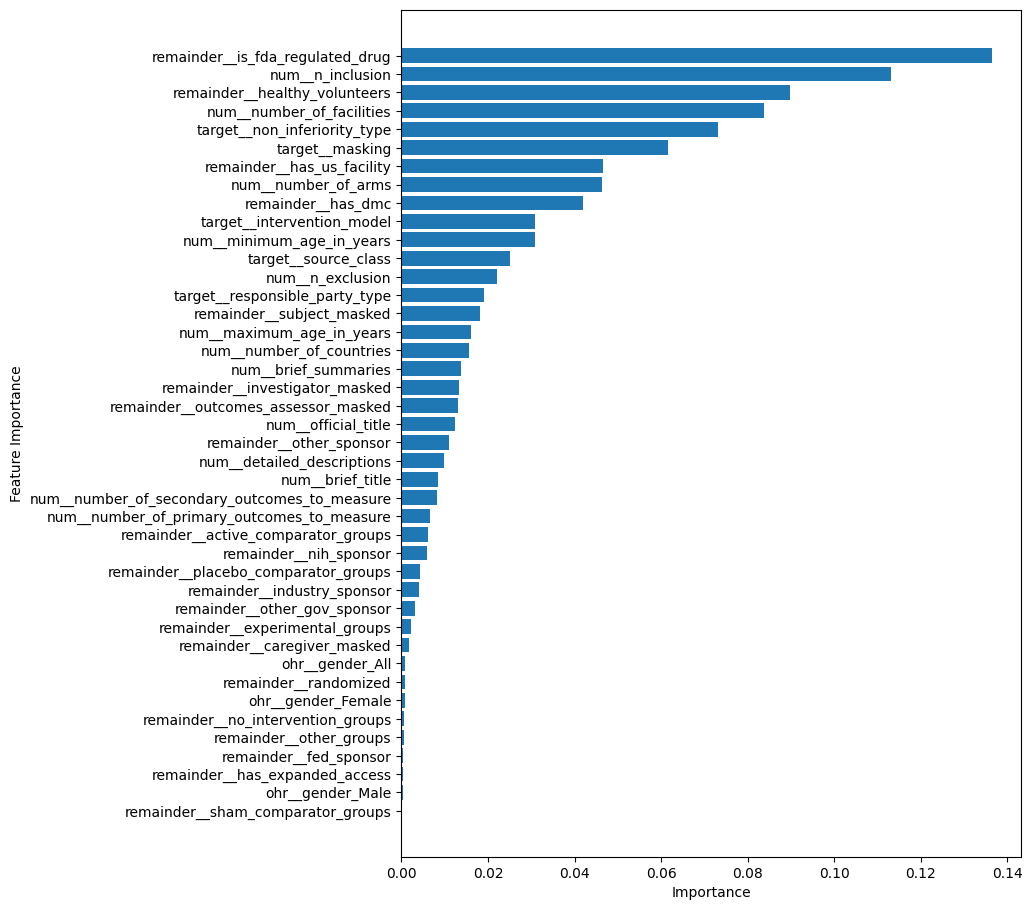

In [1037]:
# визуализация важности признаков для предсказания
fig = plt.figure(figsize=(8, 11))
plt.barh(sorted_names, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

100%|===================| 52381/52400 [17:38<00:00]        

TypeError: only integer scalar arrays can be converted to a scalar index

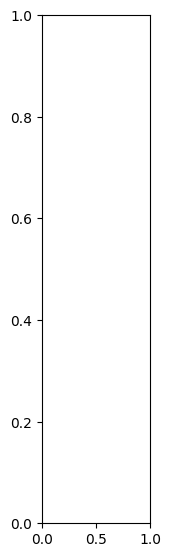

In [1038]:
model = best_rf_pipeline.named_steps['classifier']
X_train_transformed = best_rf_pipeline.named_steps['preprocessor'].transform(X_train)

explainer = shap.TreeExplainer(model, X_train_transformed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_transformed[0,:], feature_names=feature_names)

100%|===================| 60655/60688 [37:22<00:01]        

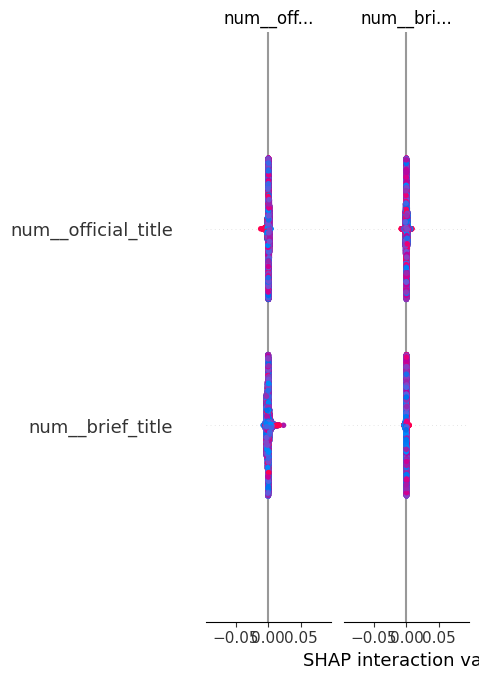

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [136]:
model = best_rf_pipeline.named_steps['classifier']
X_train_transformed = best_rf_pipeline.named_steps['preprocessor'].transform(X_train)

explainer = shap.TreeExplainer(model, X_train_transformed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_transformed[0,:], feature_names=feature_names)


#####
explainer = shap.TreeExplainer(model, X_train_transformed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train_transformed)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_transformed[0,:], feature_names=feature_names)

<h1 style="color:green">XGBoost_final:</h1>


In [1039]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase2.drop('overall_status', axis=1)
y = data_Phase2['overall_status']

y = y.astype(int)

## Разделение на обучающий и тестовый датасеты:

In [1040]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Транформер, модель, XGBoost_pipeline:

In [1041]:
# напоминание про состав списков колонок:
print(f'categorical_features_all: {categorical_features_all}')
print(f'categorical_features_OHE: {categorical_features_OHE}')
print(f'categorical_features_target: {categorical_features_target}')

print(f'numeric_features_all: {numeric_features_all}')

categorical_features_all: ['gender', 'masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
categorical_features_OHE: ['gender']
categorical_features_target: ['masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
numeric_features_all: ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions', 'n_inclusion', 'n_exclusion', 'number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries']


In [1042]:
scale_pos_weight = y.value_counts()[1] / y.value_counts()[0]

In [1043]:
# Трансформер:
transformer_xgb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_all),
        ('ohr', OneHotEncoder(), categorical_features_OHE),
        ('target', TargetEncoder(), categorical_features_target)
    ],
    remainder='passthrough'
)

In [1044]:
# Model:
xgb_model = XGBClassifier(
        objective= 'binary:logistic',
        eval_metric='logloss',
        learning_rate = 0.05,
        n_estimators = 1000,
        max_depth = 2,
        scale_pos_weight = 3
    )

In [1045]:
# Pipeline:
xgb_pipeline = Pipeline([
    ('preprocessor', transformer_xgb),
    ('classifier', xgb_model)  # Use the configured model here
])


In [1046]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['brief_title',
                                                   'official_title',
                                                   'brief_summaries',
                                                   'detailed_descriptions',
                                                   'n_inclusion', 'n_exclusion',
                                                   'number_of_arms',
                                                   'number_of_facilities',
                                                   'minimum_age_in_years',
                                                   'maximum_age_in_years',
                                                   'number_of_primary_outcomes_to_measure',
                                                   'number_of...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

### Подбор гиперпараметров: 

In [1068]:
param_grid = {
    'classifier__n_estimators' : [700], #2000, 2500, 1600 , 1300 900 , 1100
    'classifier__max_depth' : [4], #3 4 1 5
    'classifier__learning_rate': [0.05], #
    'classifier__scale_pos_weight': [2], #,3,5 
    'classifier__min_split_loss': [1], #5
    'classifier__min_child_weight': [5], #1 5
    'classifier__max_delta_step': [4] #1,2, 3
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=10
)

# Обучение с поиском по сетке
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший score: {grid_search.best_score_}")

# Получение лучшей модели
best_xgb_pipeline = grid_search.best_estimator_

# Лучшие параметры: {'classifier__learning_rate': 0.05, 'classifier__max_delta_step': 3, 'classifier__max_depth': 5, 'classifier__min_child_weight': 5, 'classifier__min_split_loss': 1, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 1}
# Лучший score: 0.9156902063450112

# Лучшие параметры: {'classifier__learning_rate': 0.05, 'classifier__max_delta_step': 3, 'classifier__max_depth': 5, 'classifier__min_child_weight': 5, 'classifier__min_split_loss': 1, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 1}
# Лучший score: 0.9156902063450112

# Лучшие параметры: {'classifier__learning_rate': 0.05, 'classifier__max_delta_step': 4, 'classifier__max_depth': 4, 'classifier__min_child_weight': 4, 'classifier__min_split_loss': 1, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 1}
# Лучший score: 0.9157545557099148

# Лучшие параметры: {'classifier__learning_rate': 0.05, 'classifier__max_delta_step': 4, 'classifier__max_depth': 4, 'classifier__min_child_weight': 4, 'classifier__min_split_loss': 1, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 1}
# Лучший score: 0.9157545557099148


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START classifier__learning_rate=0.05, classifier__max_delta_step=4, classifier__max_depth=4, classifier__min_child_weight=5, classifier__min_split_loss=1, classifier__n_estimators=700, classifier__scale_pos_weight=2
[CV 1/5; 1/4] END classifier__learning_rate=0.05, classifier__max_delta_step=4, classifier__max_depth=4, classifier__min_child_weight=5, classifier__min_split_loss=1, classifier__n_estimators=700, classifier__scale_pos_weight=2;, score=0.872 total time=   0.7s
[CV 2/5; 1/4] START classifier__learning_rate=0.05, classifier__max_delta_step=4, classifier__max_depth=4, classifier__min_child_weight=5, classifier__min_split_loss=1, classifier__n_estimators=700, classifier__scale_pos_weight=2
[CV 2/5; 1/4] END classifier__learning_rate=0.05, classifier__max_delta_step=4, classifier__max_depth=4, classifier__min_child_weight=5, classifier__min_split_loss=1, classifier__n_estimators=700, classifier__scale_pos_

### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [1069]:
# Предсказание модели с порогом 0.5:
pred_prob = best_xgb_pipeline.predict_proba(X_train)

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [1070]:
# Предсказания для разных порогов классификкации:
thresholds = [0.7, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.99]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_train'] = np.array(y_train)

In [1071]:
#print(df_probs_threshs.to_string())

In [1072]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

For threshold 0.7:
Accuracy Score: 0.79
Recall Score_0: 0.25
Precision Score_0: 0.66
Recall Score_1: 0.96
Precision Score_1: 0.81
F1 Score: 0.88
ROC-AUC: 0.6

For threshold 0.75:
Accuracy Score: 0.79
Recall Score_0: 0.35
Precision Score_0: 0.6
Recall Score_1: 0.93
Precision Score_1: 0.83
F1 Score: 0.87
ROC-AUC: 0.64

For threshold 0.76:
Accuracy Score: 0.79
Recall Score_0: 0.38
Precision Score_0: 0.58
Recall Score_1: 0.92
Precision Score_1: 0.83
F1 Score: 0.87
ROC-AUC: 0.65

For threshold 0.77:
Accuracy Score: 0.79
Recall Score_0: 0.4
Precision Score_0: 0.57
Recall Score_1: 0.91
Precision Score_1: 0.83
F1 Score: 0.87
ROC-AUC: 0.65

For threshold 0.78:
Accuracy Score: 0.79
Recall Score_0: 0.43
Precision Score_0: 0.56
Recall Score_1: 0.9
Precision Score_1: 0.84
F1 Score: 0.87
ROC-AUC: 0.66

For threshold 0.79:
Accuracy Score: 0.79
Recall Score_0: 0.45
Precision Score_0: 0.55
Recall Score_1: 0.89
Precision Score_1: 0.84
F1 Score: 0.86
ROC-AUC: 0.67

For threshold 0.8:
Accuracy Score: 0.78

In [1073]:
# Выбранный лучший порог:
best_tresh = 0.86

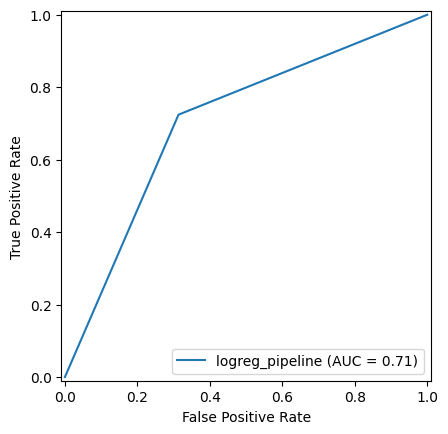

In [1074]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_train, df_probs_threshs[best_tresh])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

## Предсказания с лучшим порогом классификации:

In [674]:
probs_test = best_xgb_pipeline.predict_proba(X_test)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds = (probs_test >= best_tresh).astype(int)


## Оценка предсказаний (с лучшим порогом классификации):

In [675]:
recall0 = round(recall_score(y_test, preds, pos_label=0), 2)
recall1 = round(recall_score(y_test, preds, pos_label=1), 2)
acc = round(accuracy_score(y_test, preds), 2)
balanced_acc = round(balanced_accuracy_score(y_test, preds), 2)

f1 = round(f1_score(y_test, preds), 2)
rocauc = round(roc_auc_score(y_test, preds), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_test, preds)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

Recall Score0: 0.62
Recall Score1: 0.79

Balanced Accuracy Score: 0.7
F1 Score: 0.85
ROC-AUC: 0.7

Accuracy Score: 0.76
Accuracy for Class 0: 0.62
Accuracy for Class 1: 0.79


#### Оценка для обучающего сета:

In [676]:
probs_train = best_xgb_pipeline.predict_proba(X_train)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds_train = (probs_train >= best_tresh).astype(int)

In [677]:
recall0 = round(recall_score(y_train, preds_train, pos_label=0), 2)
recall1 = round(recall_score(y_train, preds_train, pos_label=1), 2)
acc = round(accuracy_score(y_train, preds_train), 2)
balanced_acc = round(balanced_accuracy_score(y_train, preds_train), 2)

f1 = round(f1_score(y_train, preds_train), 2)
rocauc = round(roc_auc_score(y_train, preds_train), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_train, preds_train)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

Recall Score0: 0.65
Recall Score1: 0.79

Balanced Accuracy Score: 0.72
F1 Score: 0.85
ROC-AUC: 0.72

Accuracy Score: 0.77
Accuracy for Class 0: 0.65
Accuracy for Class 1: 0.79


## crossvalidation:

In [678]:
from sklearn.model_selection import cross_validate

In [1082]:
# Выполнение кросс-валидации
y_probas = cross_val_predict(best_xgb_pipeline, X, y, cv=5, method='predict_proba')
y_scores = y_probas[:, 1]  # Вероятности для класса 1

#y_pred = cross_val_predict(best_xgb_pipeline, X, y, cv=5, method='predict')

In [1083]:
# предсказания с учетом порога:
y_pred = (y_scores >= best_tresh).astype(int)


In [1084]:
cm = confusion_matrix(y, y_pred)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')


Accuracy for Class 0: 0.62
Accuracy for Class 1: 0.69


In [1085]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_scores)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()




ROC-AUC: 0.72
F1 Score: 0.76

Balanced Accuracy: 0.66

Recall for Class 0: 0.62

Accuracy for Class 0: 0.62
Accuracy for Class 1: 0.69
Recall for Class 1: 0.69



## Save results:

In [391]:
params = grid_search.best_params_
to_safe = ''
for key, value in params.items():
    name = key.split('__')[-1]
    #print(f'{name}={value}')
    to_safe += f'{name}={value}, '

to_safe = to_safe[:-2]
print(to_safe)

learning_rate=0.05, max_delta_step=4, max_depth=4, min_child_weight=4, min_split_loss=1, n_estimators=300, scale_pos_weight=1


In [395]:
# Значения, которые нужно добавить:
model_results = {
    "Model": "XGBoost",
    "Hyperparameters": to_safe,
    "Classification threshold": best_tresh,
    "ROC-AUC": round(rocauc, 2),
    "F1 Score": round(f1, 2),
    "Balanced Accuracy": round(balanced_acc, 2),
    "Recall for Class 0": round(recall0, 2),
    "Accuracy for Class 0": round(accuracy_class_0, 2),
    "Accuracy for Class 1": round(accuracy_class_1, 2),
    "Recall for Class 1": round(recall1, 2)
    }

# Вычисление следующего индекса для новой строки
next_index = len(results_df)

model_results
# Добавление новой строки в DataFrame
#results_df.loc[next_index] = model_results

{'Model': 'XGBoost',
 'Hyperparameters': 'learning_rate=0.05, max_delta_step=4, max_depth=4, min_child_weight=4, min_split_loss=1, n_estimators=300, scale_pos_weight=1',
 'Classification threshold': 0.79,
 'ROC-AUC': 0.77,
 'F1 Score': 0.83,
 'Balanced Accuracy': 0.69,
 'Recall for Class 0': 0.61,
 'Accuracy for Class 0': 0.61,
 'Accuracy for Class 1': 0.76,
 'Recall for Class 1': 0.76}

In [394]:
results_df

Model                                    Hyperparameters  \
0  Logistic Regression      C=3.0, max_iter=300, penalty=l2, solver=lbfgs   
1        Random Forest  max_depth=5, max_leaf_nodes=2400, min_samples_...   
2              XGBoost  learning_rate=0.05, max_delta_step=4, max_dept...   

   Classification threshold  ROC-AUC  F1 Score  Balanced Accuracy  \
0                      0.80     0.74      0.80               0.67   
1                      0.43     0.75      0.82               0.67   
2                      0.79     0.77      0.83               0.69   

   Recall for Class 0  Accuracy for Class 0  Accuracy for Class 1  \
0                0.63                  0.63                  0.71   
1                0.60                  0.60                  0.75   
2                0.61                  0.61                  0.76   

   Recall for Class 1  
0                0.71  
1                0.75  
2                0.76

## feature analysis:

In [1086]:
# достаем название фичей из трансформированных данных:
name_f_after_trans = best_xgb_pipeline[:-1].get_feature_names_out()
#name_f_after_trans

In [1087]:
# достаем важность фичей из обученной модели:
feature_importance = best_xgb_pipeline[-1].feature_importances_

In [1088]:
# сортируем их попарно в порядке убывания важности фичи для модели:
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importances = feature_importance[sorted_indices]
sorted_names = name_f_after_trans[sorted_indices]

In [1089]:
# importances_names = zip(name_f_after_trans, feature_importance)
# print(sorted(importances_names, key=lambda x: x[1], reverse=True))

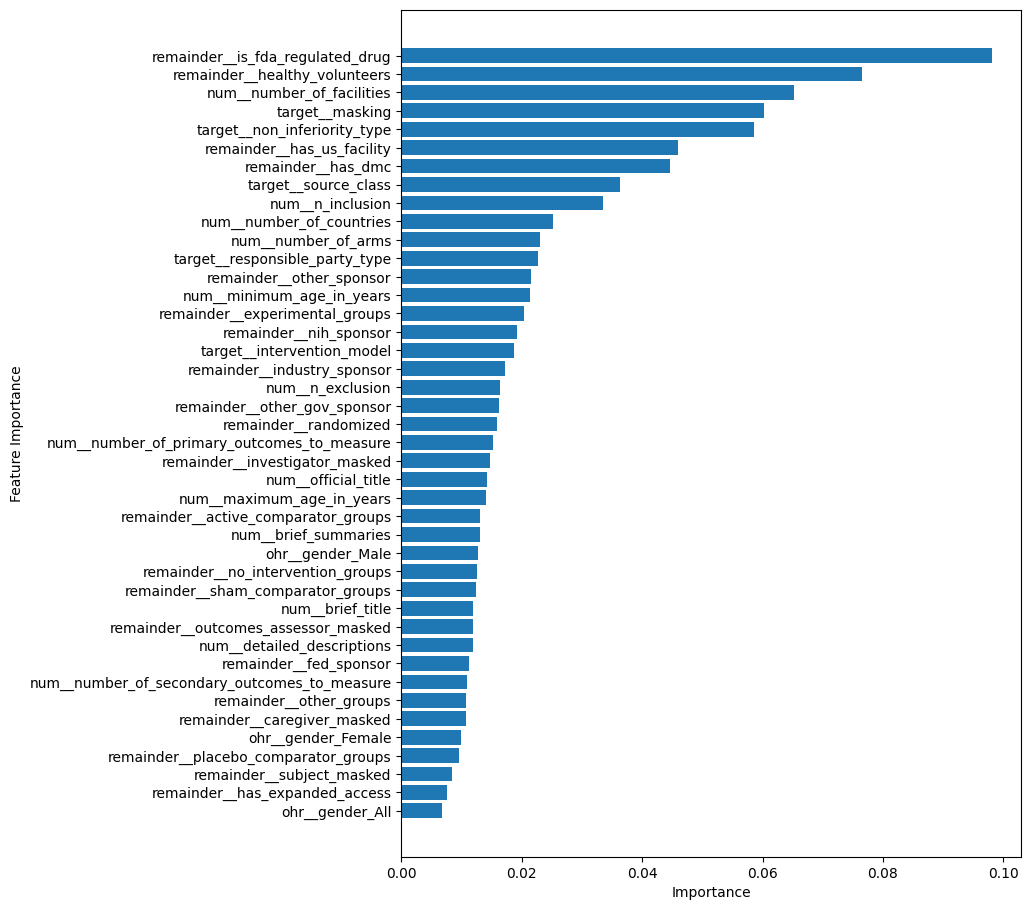

In [1090]:
# визуализация важности признаков для предсказания
fig = plt.figure(figsize=(8, 11))
plt.barh(sorted_names, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

 99%|===================| 25973/26200 [01:42<00:00]        

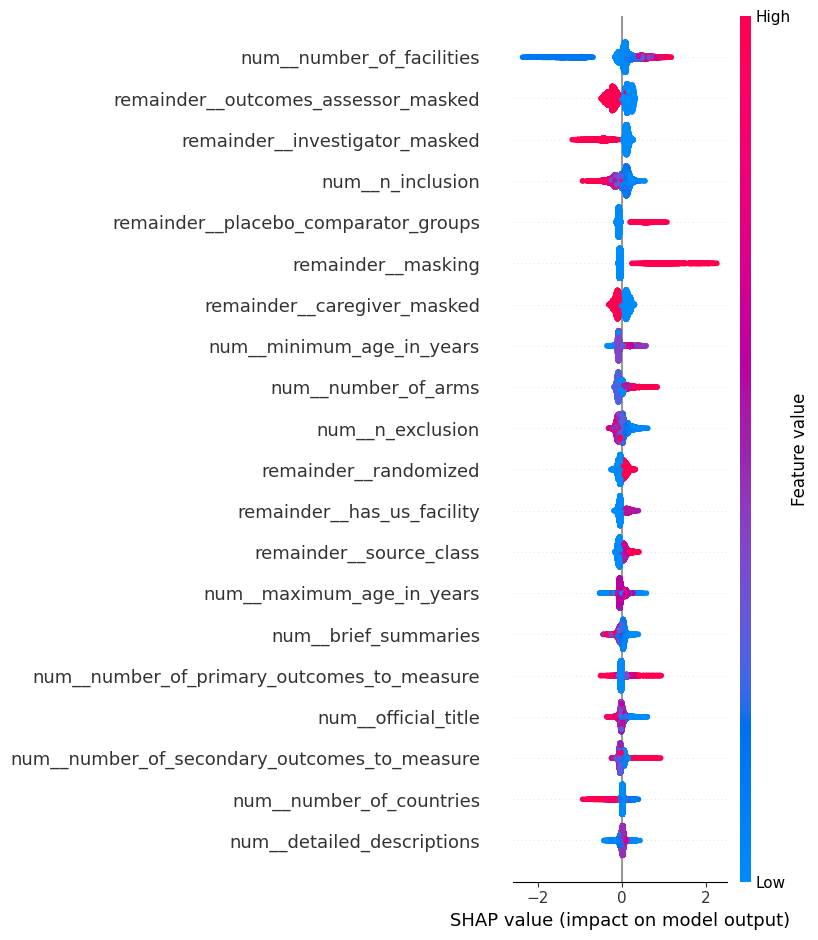

In [1091]:
model = best_xgb_pipeline.named_steps['classifier']
X_train_transformed = best_xgb_pipeline.named_steps['preprocessor'].transform(X_train)

explainer = shap.TreeExplainer(model, X_train_transformed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_transformed[0,:], feature_names=feature_names)

## Транформер, модель, xgb_pipeline_3 (OLD):

In [980]:
random_under_sampler = RandomUnderSampler(sampling_strategy=0.9, random_state=42)


In [984]:
# Pipeline:
xgb_pipeline_3 = ImbPipeline(steps=[
    ('categorical_numeric_transformer_OHE', categorical_numeric_transformer_OHE),
    #('under_sampling', random_under_sampler),
    #('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        objective= 'binary:logistic', #'binary:logistic', binary:hinge
        eval_metric='logloss',#'logloss', aucpr
        #use_label_encoder=False,
        learning_rate = 0.05,
        #gamma = 0,
        n_estimators = 2000,
        max_depth = 3
        #reg_lambda = 1,
        #scale_pos_weight=10/9
    ))
])

## Оценка качества работы модели xgb_pipeline:

In [1049]:
# Настраиваем k-кратную кросс-валидацию
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Применяем кросс-валидацию
scores = cross_val_score(best_xgb_pipeline, X, y, cv=kf, scoring='accuracy')

print("Точность на каждом фолде: ", scores)
print("Средняя точность: ", scores.mean())



Точность на каждом фолде:  [0.84503849 0.84603216]
Средняя точность:  0.8455353272214625


In [1050]:
scores_f1_macro = cross_val_score(best_xgb_pipeline, X, y, cv=kf, scoring='f1_macro')
print("F1-балл (macro) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (macro): ", scores_f1_macro.mean())



F1-балл (macro) на каждом фолде:  [0.54227503 0.55079875]
Средний F1-балл (macro):  0.5465368903037888


In [1051]:
scores_f1_macro = cross_val_score(best_xgb_pipeline, X, y, cv=kf, scoring='f1_weighted')
print("F1-балл (weighted) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (weighted): ", scores_f1_macro.mean())


F1-балл (weighted) на каждом фолде:  [0.79229778 0.79725864]
Средний F1-балл (weighted):  0.7947782133269863


In [1052]:
# Делаем кросс-валидированные предсказания
y_pred = cross_val_predict(best_xgb_pipeline, X, y, cv=kf)

# Вычисляем полноту для неуспешных исследований
recall = recall_score(y, y_pred, pos_label=0)

print(f"Полнота для неуспешных исследований: {recall}")

Полнота для неуспешных исследований: 0.1029292765819712


## Сохранение результатов:

In [1494]:
# Сохранение результатов:
results = {
        'Pipeline_name': xgb_pipeline_3,
        'Model': 'XGBClassifier',
        'Preprocessing': categorical_numeric_transformer_OHE,
        'n_iterations': 2000,
        'n_depth': 3,
        'learning_rate': 0.05,
        'l2_leaf_reg': None,
        'cross_val_recall_Fail_score': 0.696,
        'cross_val_accuracy': 0.68,
        'cross_val_f1_weighted': 0.72,
        'cross_val_f1_macro': 0.60, 
        'Pipeline' : 'xgb_pipeline_3',
    }

add_results_df = pd.DataFrame([results])

In [1495]:
results_df = pd.concat([results_df, add_results_df], ignore_index=True)

In [1496]:
results_df

Pipeline_name               Model  \
0  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
1  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
2  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
3  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
4  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
5  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
6  (ColumnTransformer(remainder='passthrough',\n ...       XGBClassifier   
7  (ColumnTransformer(remainder='passthrough',\n ...       XGBClassifier   
8  (ColumnTransformer(remainder='passthrough',\n ...       XGBClassifier   

                                       Preprocessing n_iterations n_depth  \
0  ColumnTransformer(remainder='passthrough',\n  ...         1000       7   
1  ColumnTransformer(remainder='passthrough',\n  ...         1000       6   
2  ColumnTransformer(remainder='passthrough',\n  ...          600       4   
3  ColumnTransformer(remainder='passthrough',\n  ...          500       4   
4  ColumnTransformer(remainder='passthrough',\n  ...          400       4   
5  ColumnTransformer(remainder='passthrough',\n  ...          500       4   
6  ColumnTransformer(remainder='passthrough',\n  ...         6000       7   
7  ColumnTransformer(remainder='passthrough',\n  ...         6000       5   
8  ColumnTransformer(remainder='passthrough',\n  ...         2000       3   

   learning_rate l2_leaf_reg  cross_val_recall_Fail_score  cross_val_accuracy  \
0           0.10           1                        0.450                0.78   
1           0.10        None                        0.540                0.76   
2           0.05           1                        0.700                0.70   
3           0.05           1                        0.710                0.70   
4           0.05           1                        0.720                0.69   
5           0.05           1                        0.670                0.73   
6           0.10        None                        0.220                0.82   
7           0.10        None                        0.220                0.84   
8           0.05        None                        0.696                0.68   

   cross_val_f1_weighted  cross_val_f1_macro        Pipeline  
0                   0.79                0.64        catboost  
1                   0.78                0.64        catboost  
2                   0.74                0.62        catboost  
3                   0.73                0.62        catboost  
4                   0.73                0.61        catboost  
5                   0.76                0.64  catboost_tfidf  
6                   0.79                0.59         xgboost  
7                   0.81                0.61   xgboost_tfidf  
8                   0.72                0.60  xgb_pipeline_3

<h1 style="color:purple">LightGBM_2_final:</h1>



In [1092]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase2.drop('overall_status', axis=1)
y = data_Phase2['overall_status']

y = y.astype(int)

## Разделение на обучающий и тестовый датасеты:

In [1093]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Транформер, модель, LightGB_pipeline:

In [1094]:
# напоминание про состав списков колонок:
print(f'categorical_features_all: {categorical_features_all}')
print(f'categorical_features_OHE: {categorical_features_OHE}')
print(f'categorical_features_target: {categorical_features_target}')

print(f'numeric_features_all: {numeric_features_all}')

categorical_features_all: ['gender', 'masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
categorical_features_OHE: ['gender']
categorical_features_target: ['masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
numeric_features_all: ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions', 'n_inclusion', 'n_exclusion', 'number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries']


In [1095]:
# Трансформер:
transformer_lgb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_all),
        ('ohr', OneHotEncoder(), categorical_features_OHE),
        ('target', TargetEncoder(), categorical_features_target)
    ],
    remainder='passthrough'
)

In [1096]:
# Model:
lgb_model = LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=3,
        #reg_lambda=1.0,
        verbose=-1,
        #scale_pos_weight=10/9
    )

In [1097]:
# Pipeline:
lgb_pipeline = Pipeline([
    ('preprocessor', transformer_lgb),
    ('classifier', lgb_model) 
])


In [1098]:
lgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['brief_title',
                                                   'official_title',
                                                   'brief_summaries',
                                                   'detailed_descriptions',
                                                   'n_inclusion', 'n_exclusion',
                                                   'number_of_arms',
                                                   'number_of_facilities',
                                                   'minimum_age_in_years',
                                                   'maximum_age_in_years',
                                                   'number_of_primary_outcomes_to_measure',
                                                   'number_of_secondary_outcomes_to_measure',
                                                   'number_of_countries']),
                                                 ('ohr', OneHotEncoder(),
                                                  ['gender']),
                                                 ('target', TargetEncoder(),
                                                  ['masking',
                                                   'responsible_party_type',
                                                   'source_class',
                                                   'intervention_model',
                                                   'non_inferiority_type'])])),
                ('classifier',
                 LGBMClassifier(learning_rate=0.05, max_depth=3,
                                metric='binary_logloss', n_estimators=1000,
                                objective='binary', verbose=-1))])

### Подбор гиперпараметров: 

In [1116]:
param_grid = {
    'classifier__n_estimators' : [1000, 800, 1200], #1100 1000, 1200 , 900, 800 
    'classifier__max_depth' : [3, 4], #3 4
    'classifier__learning_rate': [0.05],
   # 'classifier__num_leaves': [31], #29 30
    'classifier__min_split_gain': [2, 3], #0 3 2
    #'classifier__min_child_samples': [None], #20 16 13 , 14
    #'classifier__reg_alpha': [1], #0
    #'classifier__reg_lambda': [1] #0
}

# num_leaves (int, optional (default=31))
# max_depth (int, optional (default=-1))
# min_split_gain (float, optional (default=0.)
# min_child_weight (float, optional (default=1e-3))
# min_child_samples (int, optional (default=20))
# reg_alpha (float, optional (default=0.)) – L1 regularization term on weights.
# reg_lambda (float, optional (default=0.)) – L2 regularization term on weights.


# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=lgb_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=10
)

# Обучение с поиском по сетке
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший score: {grid_search.best_score_}")

# Получение лучшей модели
best_lgb_pipeline = grid_search.best_estimator_

# Лучшие параметры: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__min_child_samples': 15, 'classifier__min_split_gain': 1, 'classifier__n_estimators': 1200, 'classifier__num_leaves': 30, 'classifier__reg_alpha': 1}
# Лучший score: 0.9152690726225732

# Лучшие параметры: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__min_child_samples': 15, 'classifier__min_split_gain': 1, 'classifier__n_estimators': 1200, 'classifier__num_leaves': 30, 'classifier__reg_alpha': 1}
# Лучший score: 0.9152690726225732

# Лучшие параметры: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__min_child_samples': 15, 'classifier__min_split_gain': 1, 'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'classifier__reg_alpha': 1}
# Лучший score: 0.9152690726225732

# Лучшие параметры: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__min_child_samples': 15, 'classifier__min_split_gain': 1, 'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 1}
# Лучший score: 0.915417106040537

# Лучшие параметры: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__min_child_samples': 15, 'classifier__min_split_gain': 1, 'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 1}
# Лучший score: 0.915417106040537

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_split_gain=2, classifier__n_estimators=1000
[CV 1/3; 1/12] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_split_gain=2, classifier__n_estimators=1000;, score=0.872 total time=   0.6s
[CV 2/3; 1/12] START classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_split_gain=2, classifier__n_estimators=1000
[CV 2/3; 1/12] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_split_gain=2, classifier__n_estimators=1000;, score=0.874 total time=   0.6s
[CV 3/3; 1/12] START classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_split_gain=2, classifier__n_estimators=1000
[CV 3/3; 1/12] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_split_gain=2, classifier__n_estimators=1000;, score=0.874 total time=   0.6s
[CV 1/3; 2/12] STA

### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [1118]:
# Предсказание модели с порогом 0.5:
pred_prob = best_lgb_pipeline.predict_proba(X_train)

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [1119]:
# Предсказания для разных порогов классификкации:
thresholds = [0.7, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_train'] = np.array(y_train)

In [1120]:
#print(df_probs_threshs.to_string())

In [1121]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

For threshold 0.7:
Accuracy Score: 0.75
Recall Score_0: 0.49
Precision Score_0: 0.46
Recall Score_1: 0.82
Precision Score_1: 0.84
F1 Score: 0.83
ROC-AUC: 0.66

For threshold 0.77:
Accuracy Score: 0.67
Recall Score_0: 0.68
Precision Score_0: 0.38
Recall Score_1: 0.67
Precision Score_1: 0.87
F1 Score: 0.76
ROC-AUC: 0.67

For threshold 0.78:
Accuracy Score: 0.65
Recall Score_0: 0.71
Precision Score_0: 0.37
Recall Score_1: 0.63
Precision Score_1: 0.88
F1 Score: 0.74
ROC-AUC: 0.67

For threshold 0.79:
Accuracy Score: 0.63
Recall Score_0: 0.75
Precision Score_0: 0.36
Recall Score_1: 0.6
Precision Score_1: 0.89
F1 Score: 0.71
ROC-AUC: 0.67

For threshold 0.8:
Accuracy Score: 0.61
Recall Score_0: 0.78
Precision Score_0: 0.35
Recall Score_1: 0.56
Precision Score_1: 0.89
F1 Score: 0.69
ROC-AUC: 0.67

For threshold 0.81:
Accuracy Score: 0.58
Recall Score_0: 0.81
Precision Score_0: 0.34
Recall Score_1: 0.51
Precision Score_1: 0.9
F1 Score: 0.65
ROC-AUC: 0.66

For threshold 0.82:
Accuracy Score: 0.

In [1122]:
# Выбранный лучший порог:
best_tresh = 0.77

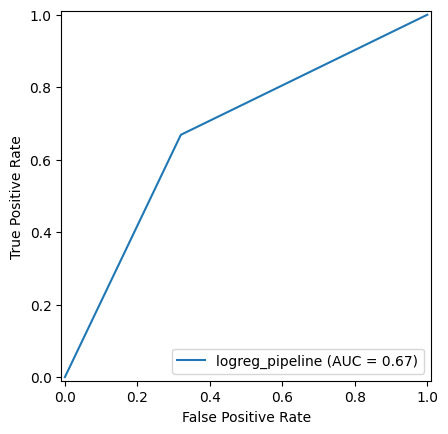

In [1123]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_train, df_probs_threshs[best_tresh])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

## Предсказания с лучшим порогом классификации:

In [1124]:
probs_test = best_lgb_pipeline.predict_proba(X_test)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds = (probs_test >= best_tresh).astype(int)


## Оценка предсказаний (с лучшим порогом классификации):

In [152]:
recall0 = round(recall_score(y_test, preds, pos_label=0), 2)
recall1 = round(recall_score(y_test, preds, pos_label=1), 2)
acc = round(accuracy_score(y_test, preds), 2)
balanced_acc = round(balanced_accuracy_score(y_test, preds), 2)

f1 = round(f1_score(y_test, preds), 2)
rocauc = round(roc_auc_score(y_test, preds), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_test, preds)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

Recall Score0: 0.67
Recall Score1: 0.74

Balanced Accuracy Score: 0.71
F1 Score: 0.82
ROC-AUC: 0.71

Accuracy Score: 0.73
Accuracy for Class 0: 0.67
Accuracy for Class 1: 0.74


#### Оценка для обучающего сета:

In [153]:
probs_train = best_lgb_pipeline.predict_proba(X_train)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds_train = (probs_train >= best_tresh).astype(int)

In [156]:
recall0 = round(recall_score(y_train, preds_train, pos_label=0), 2)
recall1 = round(recall_score(y_train, preds_train, pos_label=1), 2)
acc = round(accuracy_score(y_train, preds_train), 2)
balanced_acc = round(balanced_accuracy_score(y_train, preds_train), 2)

f1 = round(f1_score(y_train, preds_train), 2)
rocauc = round(roc_auc_score(y_train, preds_train), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_train, preds_train)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

Recall Score0: 0.68
Recall Score1: 0.74

Balanced Accuracy Score: 0.71
F1 Score: 0.82
ROC-AUC: 0.71

Accuracy Score: 0.73
Accuracy for Class 0: 0.68
Accuracy for Class 1: 0.74


## crossvalidation:

In [157]:
from sklearn.model_selection import cross_validate

In [1132]:
# Выполнение кросс-валидации
y_probas = cross_val_predict(best_lgb_pipeline, X, y, cv=5, method='predict_proba')
y_scores = y_probas[:, 1]  # Вероятности для класса 1


In [1133]:
# предсказания с учетом порога:
y_pred = (y_scores >= best_tresh).astype(int)


In [1134]:
cm = confusion_matrix(y, y_pred)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')


Accuracy for Class 0: 0.66
Accuracy for Class 1: 0.65


In [1135]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_scores)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()




ROC-AUC: 0.71
F1 Score: 0.74

Balanced Accuracy: 0.65

Recall for Class 0: 0.66

Accuracy for Class 0: 0.66
Accuracy for Class 1: 0.65
Recall for Class 1: 0.65



## Save results:

In [162]:
params = grid_search.best_params_
to_safe = ''
for key, value in params.items():
    name = key.split('__')[-1]
    #print(f'{name}={value}')
    to_safe += f'{name}={value}, '

to_safe = to_safe[:-2]
print(to_safe)

learning_rate=0.05, max_depth=3, min_child_samples=15, min_split_gain=1, n_estimators=1000, num_leaves=31, reg_alpha=1, reg_lambda=1


In [164]:
# Значения, которые нужно добавить:
model_results = {
    "Model": "LightGBM",
    "Hyperparameters": to_safe,
    "Classification threshold": best_tresh,
    "ROC-AUC": round(rocauc, 2),
    "F1 Score": round(f1, 2),
    "Balanced Accuracy": round(balanced_acc, 2),
    "Recall for Class 0": round(recall0, 2),
    "Accuracy for Class 0": round(accuracy_class_0, 2),
    "Accuracy for Class 1": round(accuracy_class_1, 2),
    "Recall for Class 1": round(recall1, 2)
    }

# Вычисление следующего индекса для новой строки
next_index = len(results_df)

model_results
# Добавление новой строки в DataFrame
#results_df.loc[next_index] = model_results

In [427]:
results_df

Model                                    Hyperparameters  \
0  Logistic Regression      C=3.0, max_iter=300, penalty=l2, solver=lbfgs   
1        Random Forest  max_depth=5, max_leaf_nodes=2400, min_samples_...   
2              XGBoost  learning_rate=0.05, max_delta_step=4, max_dept...   
3             LightGBM  learning_rate=0.05, max_depth=3, min_child_sam...   

   Classification threshold  ROC-AUC  F1 Score  Balanced Accuracy  \
0                      0.80     0.74      0.80               0.67   
1                      0.43     0.75      0.82               0.67   
2                      0.79     0.77      0.83               0.69   
3                      0.79     0.77      0.83               0.69   

   Recall for Class 0  Accuracy for Class 0  Accuracy for Class 1  \
0                0.63                  0.63                  0.71   
1                0.60                  0.60                  0.75   
2                0.61                  0.61                  0.76   
3                0.61                  0.61                  0.76   

   Recall for Class 1  
0                0.71  
1                0.75  
2                0.76  
3                0.76

## feature analysis:

In [165]:
# достаем название фичей из трансформированных данных:
name_f_after_trans = best_lgb_pipeline[:-1].get_feature_names_out()
#name_f_after_trans

In [166]:
# достаем важность фичей из обученной модели:
feature_importance = best_lgb_pipeline[-1].feature_importances_

In [167]:
# сортируем их попарно в порядке убывания важности фичи для модели:
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importances = feature_importance[sorted_indices]
sorted_names = name_f_after_trans[sorted_indices]

In [168]:
# importances_names = zip(name_f_after_trans, feature_importance)
# print(sorted(importances_names, key=lambda x: x[1], reverse=True))

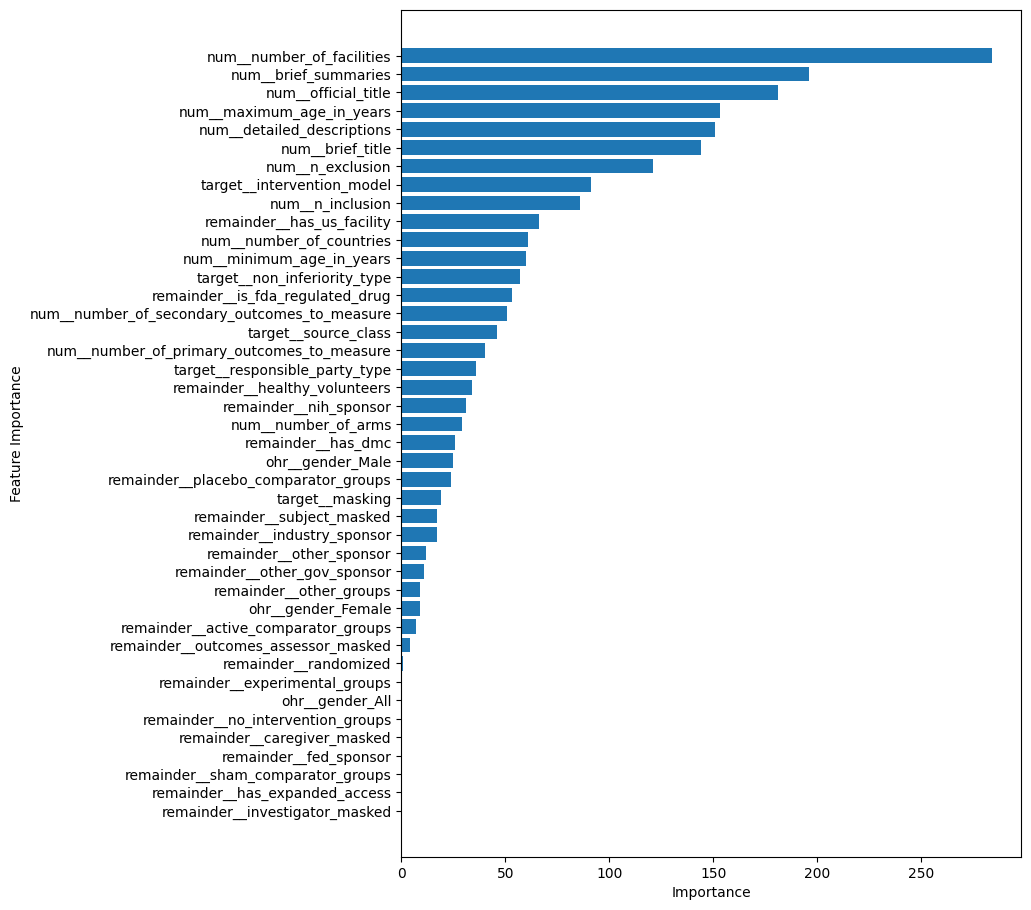

In [169]:
# визуализация важности признаков для предсказания
fig = plt.figure(figsize=(8, 11))
plt.barh(sorted_names, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

100%|===================| 30310/30344 [02:38<00:00]        

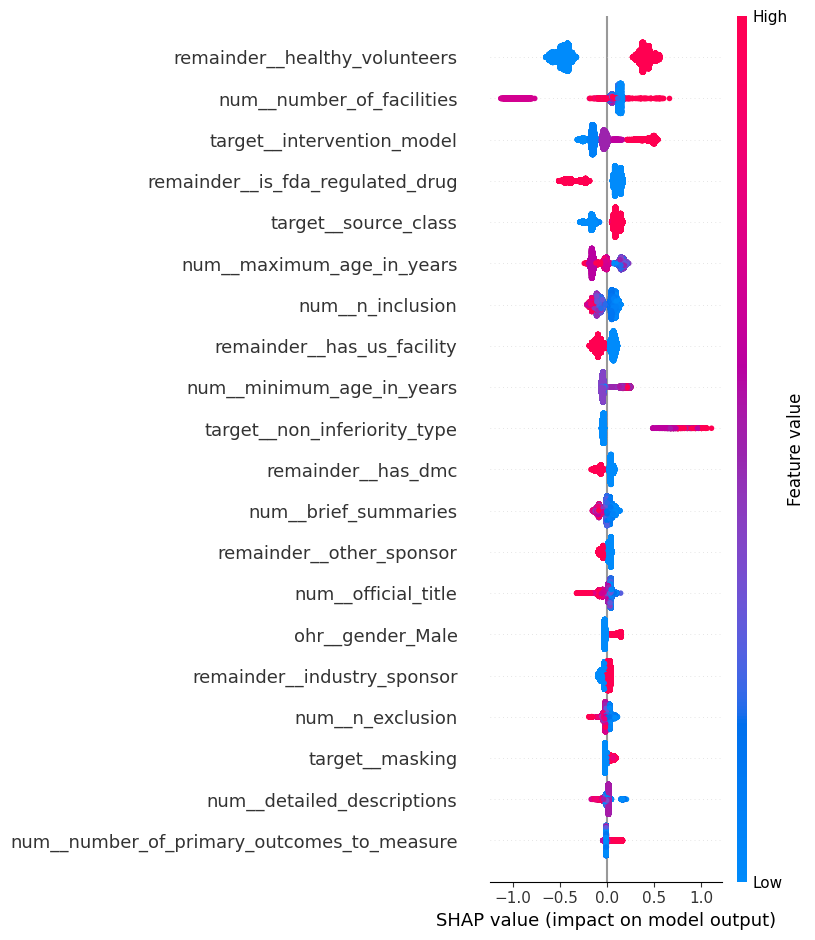

In [1081]:
model = best_lgb_pipeline.named_steps['classifier']
X_train_transformed = best_lgb_pipeline.named_steps['preprocessor'].transform(X_train)

explainer = shap.TreeExplainer(model, X_train_transformed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_transformed[0,:], feature_names=feature_names)

<h1 style="color:red">Catboost (with TFIDF):</h1>



In [780]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase1.drop('overall_status', axis=1)
y = data_Phase1['overall_status']

y = y.astype(int)

## Преобразование текстовых фичей

In [534]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [1105]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

### Текстовые фичи:

In [535]:
text_features = numeric_features_tobe[:-2]

In [536]:
X[text_features].head()

brief_title  \
3   Phase 1/2 Study of KHK7580 for Secondary Hyper...   
8   AME (Absorption, Metabolism, and Excretion) of...   
9   Cancer Immune Therapy for the Treatment of Ref...   
11  Phase 1b/2 Study of AMG 655 With mFOLFOX6 and ...   
14  Trial to Evaluate Safety and Immunogenicity of...   

                                       official_title  \
3   A Dose Escalation, Single and Multiple Dose, P...   
8   A Phase 1 Study to Investigate the Absorption,...   
9   Monocyte-derived Dendritic Cells Loaded With T...   
11  A Phase 1b/2 Study of AMG 655 in Combination W...   
14  Randomized, Placebo-controlled, Double-blind P...   

                                      brief_summaries  \
3   This study is designed to evaluate safety, pha...   
8   To evaluate how the body absorbs, metabolizes ...   
9   This is an un-blinded Phase 1 study in which 2...   
11  This phase 1/2, multi-center, randomized, doub...   
14  The objectives of this first-in-human is to ev...   

                                detailed_descriptions  
3                                                 NaN  
8                                                 NaN  
9   In this phase I trial 21 paediatric patients w...  
11                                                NaN  
14  Hookipa Biotech AG is developing a replication...

### Заполнение missing values:

In [537]:
# Fill missing values in text_features with '':
imputer = SimpleImputer(strategy='constant', fill_value='')
X[text_features] = imputer.fit_transform(X[text_features])

# #2nd option:
# for feature in text_features:
#     X[feature] = X[feature].fillna('')

In [538]:
X[text_features].head()

brief_title  \
3   Phase 1/2 Study of KHK7580 for Secondary Hyper...   
8   AME (Absorption, Metabolism, and Excretion) of...   
9   Cancer Immune Therapy for the Treatment of Ref...   
11  Phase 1b/2 Study of AMG 655 With mFOLFOX6 and ...   
14  Trial to Evaluate Safety and Immunogenicity of...   

                                       official_title  \
3   A Dose Escalation, Single and Multiple Dose, P...   
8   A Phase 1 Study to Investigate the Absorption,...   
9   Monocyte-derived Dendritic Cells Loaded With T...   
11  A Phase 1b/2 Study of AMG 655 in Combination W...   
14  Randomized, Placebo-controlled, Double-blind P...   

                                      brief_summaries  \
3   This study is designed to evaluate safety, pha...   
8   To evaluate how the body absorbs, metabolizes ...   
9   This is an un-blinded Phase 1 study in which 2...   
11  This phase 1/2, multi-center, randomized, doub...   
14  The objectives of this first-in-human is to ev...   

                                detailed_descriptions  
3                                                      
8                                                      
9   In this phase I trial 21 paediatric patients w...  
11                                                     
14  Hookipa Biotech AG is developing a replication...

In [539]:
X[text_features].isna().sum()

brief_title              0
official_title           0
brief_summaries          0
detailed_descriptions    0
dtype: int64

## Разделение на обучающий и тестовый датасеты:

In [548]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обработка текста и модель:

In [580]:
# Функция для преобразования текстовых признаков для последующего применения TfidfVectorizer():

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    # Remove punctuation and digits:
    text = re.sub(r'[\d\W]+', ' ', text)
    # Tokenization:
    words = word_tokenize(text)
    # Remove stop words:
    words = [word for word in words if word not in stopwords.words('english')]
    # Lemmatization:
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a string:
    text = ' '.join(words)
    
    return text

### Обработка датасета один раз и отдельно - tfidf:

In [557]:
numeric_features_total = numeric_features + numeric_features_tobe[4:]
print(numeric_features_total)

['number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries', 'n_inclusion', 'n_exclusion']


In [571]:
set(X.columns.to_list()) == set(numeric_features_total + numeric_features_tobe[:4] + categorical_features_target + categorical_features_OHE + binary_features)

True

In [582]:
preprocessor_tfidf_sep = ColumnTransformer(
    transformers=[
        ('tfidf1', TfidfVectorizer(preprocessor=preprocess_text, max_features=10), 'brief_title'),
        ('tfidf2', TfidfVectorizer(preprocessor=preprocess_text, max_features=10), 'official_title'),
        ('tfidf3', TfidfVectorizer(preprocessor=preprocess_text, max_features=10), 'brief_summaries'),
        ('tfidf4', TfidfVectorizer(preprocessor=preprocess_text, max_features=10), 'detailed_descriptions'),
        ('cat', OneHotEncoder(drop='first'), categorical_features_OHE),
        ('cat_target', TargetEncoder(), categorical_features_target),
        ('num', StandardScaler(), numeric_features_total)
    ],
    remainder='passthrough'
)

In [583]:
preprocessor_tfidf_sep.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf1',
                                 TfidfVectorizer(max_features=10,
                                                 preprocessor=<function preprocess_text at 0x33b1e6710>),
                                 'brief_title'),
                                ('tfidf2',
                                 TfidfVectorizer(max_features=10,
                                                 preprocessor=<function preprocess_text at 0x33b1e6710>),
                                 'official_title'),
                                ('tfidf3',
                                 TfidfVectorizer(max_features=10,
                                                 preprocessor=<function preproc...
                                ('cat_target', TargetEncoder(),
                                 ['masking', 'responsible_party_type',
                                  'source_class', 'intervention_model',
                                  'non_inferiority_type']),
                                ('num', StandardScaler(),
                                 ['number_of_arms', 'number_of_facilities',
                                  'minimum_age_in_years',
                                  'maximum_age_in_years',
                                  'number_of_primary_outcomes_to_measure',
                                  'number_of_secondary_outcomes_to_measure',
                                  'number_of_countries', 'n_inclusion',
                                  'n_exclusion'])])

In [614]:
X_test_trans = preprocessor_tfidf_sep.transform(X_test)

In [586]:
X_train_trans = preprocessor_tfidf_sep.transform(X_train)

In [808]:
X_trans = preprocessor_tfidf_sep.transform(X)

In [639]:
# список названий колонок, в том порядке в котором они будут после трансформации:
text_f = ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions']

# Example to get the transformed feature names
tfidf1_features = preprocessor_tfidf_sep.named_transformers_['tfidf1'].get_feature_names_out('brief_title')
tfidf2_features = preprocessor_tfidf_sep.named_transformers_['tfidf2'].get_feature_names_out('official_title')
tfidf3_features = preprocessor_tfidf_sep.named_transformers_['tfidf3'].get_feature_names_out('brief_summaries')
tfidf4_features = preprocessor_tfidf_sep.named_transformers_['tfidf4'].get_feature_names_out('detailed_descriptions')

# Combine all feature names
final_columns = list(tfidf1_features) + list(tfidf2_features) + list(tfidf3_features) + list(tfidf4_features)
final_columns += ['gender_1', 'gender_2']
final_columns += categorical_features_target
final_columns += numeric_features_total
final_columns += binary_features


In [640]:
# создаем список уникальных названий колонок: 
final_f_columns = []
for c in final_columns:
    if c not in final_f_columns:
        final_f_columns.append(c)
    else:
        while c in final_f_columns:
            c += '_'
            if c not in final_f_columns:
                final_f_columns.append(c)
                break

len(set(final_f_columns)) == len(final_f_columns)

True

In [641]:
# Create DataFrames:
X_train_trans_df_temp = pd.DataFrame(X_train_trans)
X_test_trans_df_temp = pd.DataFrame(X_test_trans)
X_trans_df_temp = pd.DataFrame(X_trans)

In [642]:
# Меняем названия колонок на уникальные:
X_train_trans_df_temp.columns = final_f_columns
X_test_trans_df_temp.columns = final_f_columns
X_trans_df_temp.columns = final_f_columns

In [ ]:
# print(f"X_train_trans_df_temp columns: {list(X_train_trans_df_temp.columns)}")
# print(f"X_test_trans_df_temp columns: {list(X_test_trans_df_temp.columns)}")

In [643]:
# Проверка, что в Х нет mis val:
if X_train_trans_df_temp.isna().sum().sum() == 0 and X_test_trans_df_temp.isna().sum().sum() == 0 and X_trans_df_temp.isna().sum().sum() == 0:
    print('DataFrames transformed successfully.')

DataFrames transformed successfully.


In [874]:
# Model:
cat_model_tfidf = CatBoostClassifier(iterations=900, auto_class_weights='Balanced',learning_rate=0.05, depth=4, l2_leaf_reg=1, verbose=100)

In [715]:
# Fit model:
cat_model_tfidf.fit(X_train_trans_df_temp, y_train)

0:	learn: 0.6293102	total: 8.87ms	remaining: 7.09s
100:	learn: 0.3728378	total: 612ms	remaining: 4.24s
200:	learn: 0.3586586	total: 1.24s	remaining: 3.7s
300:	learn: 0.3479538	total: 1.94s	remaining: 3.22s
400:	learn: 0.3376513	total: 2.58s	remaining: 2.57s
500:	learn: 0.3287001	total: 3.23s	remaining: 1.93s
600:	learn: 0.3201240	total: 3.85s	remaining: 1.27s
700:	learn: 0.3123814	total: 4.48s	remaining: 633ms
799:	learn: 0.3050614	total: 5.09s	remaining: 0us


## Pipeline (обработка текста внутри):

In [ ]:
preprocessor_tfidf_sep = ColumnTransformer(
    transformers=[
        ('tfidf1', TfidfVectorizer(preprocessor=preprocess_text, max_features=10), 'brief_title'),
        ('tfidf2', TfidfVectorizer(preprocessor=preprocess_text, max_features=10), 'official_title'),
        ('tfidf3', TfidfVectorizer(preprocessor=preprocess_text, max_features=10), 'brief_summaries'),
        ('tfidf4', TfidfVectorizer(preprocessor=preprocess_text, max_features=10), 'detailed_descriptions'),
        ('cat', OneHotEncoder(drop='first'), categorical_features_OHE),
        ('cat_target', TargetEncoder(), categorical_features_target),
        ('num', StandardScaler(), numeric_features_total)
    ],
    remainder='passthrough'
)

In [875]:
cat_pipeline_tfidf = Pipeline([
    ('preprocessor', preprocessor_tfidf_sep),
    ('classifier', cat_model_tfidf)
])

In [876]:
cat_pipeline_tfidf.fit(X_train, y_train)

0:	learn: 0.6856941	total: 22.1ms	remaining: 19.9s
100:	learn: 0.5795335	total: 504ms	remaining: 3.99s
200:	learn: 0.5667949	total: 981ms	remaining: 3.41s
300:	learn: 0.5502243	total: 1.48s	remaining: 2.94s
400:	learn: 0.5364367	total: 2.03s	remaining: 2.53s
500:	learn: 0.5246723	total: 2.54s	remaining: 2.02s
600:	learn: 0.5135503	total: 3.04s	remaining: 1.51s
700:	learn: 0.5036031	total: 3.54s	remaining: 1.01s
800:	learn: 0.4942248	total: 4.08s	remaining: 504ms
899:	learn: 0.4850025	total: 4.53s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf1',
                                                  TfidfVectorizer(max_features=10,
                                                                  preprocessor=<function preprocess_text at 0x33b1e6710>),
                                                  'brief_title'),
                                                 ('tfidf2',
                                                  TfidfVectorizer(max_features=10,
                                                                  preprocessor=<function preprocess_text at 0x33b1e6710>),
                                                  'official_title'),
                                                 ('tfidf3',
                                                  TfidfVectorizer(max_features=...
                                                   'intervention_model',
                                                   'non_inferiority_type']),
                                                 ('num', StandardScaler(),
                                                  ['number_of_arms',
                                                   'number_of_facilities',
                                                   'minimum_age_in_years',
                                                   'maximum_age_in_years',
                                                   'number_of_primary_outcomes_to_measure',
                                                   'number_of_secondary_outcomes_to_measure',
                                                   'number_of_countries',
                                                   'n_inclusion',
                                                   'n_exclusion'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x2d66caa40>)])

## GridSearchCV:

In [804]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'iterations': [800, 900], #500,600,800
    'learning_rate': [0.05], #0.05
    'depth': [4], #5
    'l2_leaf_reg': [1], #1
    #'min_data_in_leaf': [None, 100], #100
    'auto_class_weights': ['Balanced']
}

custom_scorer = make_scorer(recall_score, pos_label=0)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model_tfidf,
    param_grid=param_grid,
    cv=3,  # Количество фолдов в кросс-валидации
    scoring='f1',  # Или другая метрика, которую вы хотите оптимизировать
    verbose=40,  # Увеличиваем verbose для большего количества выводимой информации
    n_jobs=1 
)

# Обучение с поиском по сетке
grid_search.fit(X_trans_df_temp, y)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший score: {grid_search.best_score_}")

# Получение лучшей модели
best_cat_model_tfidf = grid_search.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START auto_class_weights=Balanced, depth=4, iterations=800, l2_leaf_reg=1, learning_rate=0.05
0:	learn: 0.6853564	total: 3.85ms	remaining: 3.08s
100:	learn: 0.5724351	total: 426ms	remaining: 2.95s
200:	learn: 0.5581120	total: 840ms	remaining: 2.5s
300:	learn: 0.5398345	total: 1.27s	remaining: 2.11s
400:	learn: 0.5244928	total: 1.69s	remaining: 1.68s
500:	learn: 0.5105302	total: 2.12s	remaining: 1.27s
600:	learn: 0.4978979	total: 2.56s	remaining: 849ms
700:	learn: 0.4868289	total: 3.02s	remaining: 427ms
799:	learn: 0.4763928	total: 3.45s	remaining: 0us
[CV 1/3; 1/2] END auto_class_weights=Balanced, depth=4, iterations=800, l2_leaf_reg=1, learning_rate=0.05;, score=0.796 total time=   3.5s
[CV 2/3; 1/2] START auto_class_weights=Balanced, depth=4, iterations=800, l2_leaf_reg=1, learning_rate=0.05
0:	learn: 0.6865152	total: 4.09ms	remaining: 3.27s
100:	learn: 0.5764586	total: 449ms	remaining: 3.11s
200:	learn: 0.56248

### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [772]:
# Предсказание модели с порогом 0.5:
pred_prob = best_cat_model_tfidf.predict_proba(X_train_trans_df_temp)

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [773]:
# Предсказания для разных порогов классификкации:
thresholds = [0.4, 0.5, 0.6, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.9]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_train'] = np.array(y_train)

In [752]:
#print(df_probs_threshs.to_string())

In [753]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

For threshold 0.4:
Accuracy Score: 0.86
Recall Score_0: 0.18
Precision Score_0: 0.97
Recall Score_1: 1.0
Precision Score_1: 0.86
F1 Score: 0.93
ROC-AUC: 0.59

For threshold 0.5:
Accuracy Score: 0.88
Recall Score_0: 0.3
Precision Score_0: 0.93
Recall Score_1: 1.0
Precision Score_1: 0.88
F1 Score: 0.93
ROC-AUC: 0.65

For threshold 0.6:
Accuracy Score: 0.9
Recall Score_0: 0.46
Precision Score_0: 0.83
Recall Score_1: 0.98
Precision Score_1: 0.9
F1 Score: 0.94
ROC-AUC: 0.72

For threshold 0.7:
Accuracy Score: 0.89
Recall Score_0: 0.64
Precision Score_0: 0.66
Recall Score_1: 0.93
Precision Score_1: 0.93
F1 Score: 0.93
ROC-AUC: 0.79

For threshold 0.71:
Accuracy Score: 0.88
Recall Score_0: 0.66
Precision Score_0: 0.64
Recall Score_1: 0.93
Precision Score_1: 0.93
F1 Score: 0.93
ROC-AUC: 0.79

For threshold 0.72:
Accuracy Score: 0.88
Recall Score_0: 0.68
Precision Score_0: 0.62
Recall Score_1: 0.92
Precision Score_1: 0.94
F1 Score: 0.93
ROC-AUC: 0.8

For threshold 0.73:
Accuracy Score: 0.87
Rec

In [754]:
# Выбранный лучший порог:
best_tresh = 0.73

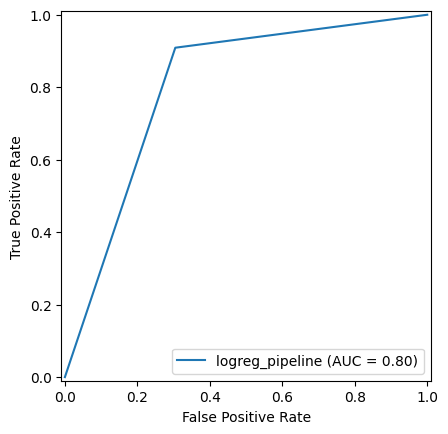

In [755]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_train, df_probs_threshs[best_tresh])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

## crossvalidation:

In [157]:
from sklearn.model_selection import cross_validate

In [774]:
# Выполнение кросс-валидации
y_probas = cross_val_predict(best_cat_model_tfidf, X_trans_df_temp, y, cv=5, method='predict_proba')
y_scores = y_probas[:, 1]  # Вероятности для класса 1

# предсказания с учетом порога:
y_pred = (y_scores >= best_tresh).astype(int)

0:	learn: 0.6780261	total: 6.22ms	remaining: 5.6s
100:	learn: 0.5479921	total: 544ms	remaining: 4.3s
200:	learn: 0.5090120	total: 1.06s	remaining: 3.69s
300:	learn: 0.4781555	total: 1.6s	remaining: 3.19s
400:	learn: 0.4519216	total: 2.15s	remaining: 2.68s
500:	learn: 0.4281072	total: 2.69s	remaining: 2.14s
600:	learn: 0.4065781	total: 3.24s	remaining: 1.61s
700:	learn: 0.3878318	total: 3.79s	remaining: 1.08s
800:	learn: 0.3704410	total: 4.34s	remaining: 536ms
899:	learn: 0.3551506	total: 4.87s	remaining: 0us
0:	learn: 0.6760428	total: 5.33ms	remaining: 4.79s
100:	learn: 0.5489177	total: 532ms	remaining: 4.21s
200:	learn: 0.5093309	total: 1.06s	remaining: 3.67s
300:	learn: 0.4784170	total: 1.59s	remaining: 3.17s
400:	learn: 0.4506516	total: 2.16s	remaining: 2.69s
500:	learn: 0.4280037	total: 2.71s	remaining: 2.15s


KeyboardInterrupt: 

In [805]:

#y_pred = best_cat_model_tfidf.predict(X_test_trans_df_temp)
y_pred = cross_val_predict(best_cat_model_tfidf, X_trans_df_temp, y, cv=5, method='predict')

0:	learn: 0.6855641	total: 5.1ms	remaining: 4.58s
100:	learn: 0.5742071	total: 478ms	remaining: 3.78s
200:	learn: 0.5607982	total: 936ms	remaining: 3.25s
300:	learn: 0.5452042	total: 1.41s	remaining: 2.81s
400:	learn: 0.5318876	total: 1.87s	remaining: 2.33s
500:	learn: 0.5199358	total: 2.36s	remaining: 1.88s
600:	learn: 0.5094762	total: 2.82s	remaining: 1.4s
700:	learn: 0.4997142	total: 3.29s	remaining: 934ms
800:	learn: 0.4904838	total: 3.75s	remaining: 464ms
899:	learn: 0.4816090	total: 4.21s	remaining: 0us
0:	learn: 0.6847143	total: 4.1ms	remaining: 3.68s
100:	learn: 0.5740956	total: 466ms	remaining: 3.69s
200:	learn: 0.5610367	total: 934ms	remaining: 3.25s
300:	learn: 0.5449607	total: 1.42s	remaining: 2.83s
400:	learn: 0.5315056	total: 1.92s	remaining: 2.38s
500:	learn: 0.5197149	total: 2.38s	remaining: 1.9s
600:	learn: 0.5086934	total: 2.83s	remaining: 1.41s
700:	learn: 0.4987706	total: 3.29s	remaining: 934ms
800:	learn: 0.4893278	total: 3.74s	remaining: 462ms
899:	learn: 0.480741

In [806]:
cm = confusion_matrix(y, y_pred)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [807]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_pred)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()

ROC-AUC: 0.70
F1 Score: 0.79

Balanced Accuracy: 0.70

Recall for Class 0: 0.70

Accuracy for Class 0: 0.70
Accuracy for Class 1: 0.70
Recall for Class 1: 0.70



## crossvalidation for pipeline:

In [877]:
# Predictions for pipeline:
y_pred = cross_val_predict(cat_pipeline_tfidf, X, y, cv=3, method='predict')

0:	learn: 0.6858806	total: 7.74ms	remaining: 6.96s
100:	learn: 0.5725361	total: 437ms	remaining: 3.46s
200:	learn: 0.5569218	total: 857ms	remaining: 2.98s
300:	learn: 0.5381203	total: 1.28s	remaining: 2.54s
400:	learn: 0.5224510	total: 1.7s	remaining: 2.11s
500:	learn: 0.5082547	total: 2.12s	remaining: 1.69s
600:	learn: 0.4959284	total: 2.54s	remaining: 1.26s
700:	learn: 0.4838517	total: 2.96s	remaining: 841ms
800:	learn: 0.4728986	total: 3.39s	remaining: 419ms
899:	learn: 0.4622574	total: 3.81s	remaining: 0us
0:	learn: 0.6864897	total: 6.85ms	remaining: 6.16s
100:	learn: 0.5774189	total: 434ms	remaining: 3.44s
200:	learn: 0.5619165	total: 853ms	remaining: 2.97s
300:	learn: 0.5432485	total: 1.28s	remaining: 2.56s
400:	learn: 0.5273355	total: 1.72s	remaining: 2.13s
500:	learn: 0.5130234	total: 2.13s	remaining: 1.7s
600:	learn: 0.5002977	total: 2.57s	remaining: 1.28s
700:	learn: 0.4876155	total: 2.99s	remaining: 850ms
800:	learn: 0.4764500	total: 3.42s	remaining: 422ms
899:	learn: 0.4661

In [878]:
cm = confusion_matrix(y, y_pred)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [879]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_pred)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()

ROC-AUC: 0.70
F1 Score: 0.80

Balanced Accuracy: 0.70

Recall for Class 0: 0.69

Accuracy for Class 0: 0.69
Accuracy for Class 1: 0.71
Recall for Class 1: 0.71



### Обработка датасета в пайплайне - tfidf:

In [542]:
print(f'categorical_features_OHE: {categorical_features_OHE}')
print(f'categorical_features_target: {categorical_features_target}')
print(f'numeric_features: {numeric_features}')

categorical_features_OHE: ['gender']
categorical_features_target: ['masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
numeric_features: ['number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries']


In [544]:
# ColumnTransformer:
preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ('tfidf1', TfidfVectorizer(preprocessor=preprocess_text), 'brief_title'),
        ('tfidf2', TfidfVectorizer(preprocessor=preprocess_text), 'official_title'),
        ('tfidf3', TfidfVectorizer(preprocessor=preprocess_text), 'brief_summaries'),
        ('tfidf4', TfidfVectorizer(preprocessor=preprocess_text), 'detailed_descriptions'),
        ('cat', OneHotEncoder(drop='first'), categorical_features_OHE),
        ('cat_target', TargetEncoder(), categorical_features_target),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

In [545]:
# Pipeline:
catboost_tfidf_pipeline = Pipeline(steps=[
    ('preprocessor_tfidf', preprocessor_tfidf),
    ('catboost', CatBoostClassifier(auto_class_weights='Balanced', iterations=500, learning_rate=0.05, depth=4, l2_leaf_reg=1, verbose=100))
])

## Подбор гиперпараметров GridSearchCV:

In [547]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'catboost__iterations': [500,1000], #500,600,800
    'catboost__learning_rate': [0.1, 0.05], #0.05
    'catboost__depth': [4, 5], #4,5
    'catboost__l2_leaf_reg': [1, None], #2
    'catboost__auto_class_weights': ['Balanced', None]
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_tfidf_pipeline,
    param_grid=param_grid,
    cv=3,  # Количество фолдов в кросс-валидации
    scoring='f1',  # Или другая метрика, которую вы хотите оптимизировать
    verbose=40,  # Увеличиваем verbose для большего количества выводимой информации
    n_jobs=1 
)

# Обучение с поиском по сетке
grid_search.fit(X, y)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-балл (macro): {grid_search.best_score_}")

# Получение лучшей модели
best_catboost_tfidf_pipeline = grid_search.best_estimator_


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3; 1/32] START catboost__auto_class_weights=Balanced, catboost__depth=4, catboost__iterations=500, catboost__l2_leaf_reg=1, catboost__learning_rate=0.1
0:	learn: 0.6792934	total: 255ms	remaining: 2m 7s
100:	learn: 0.5592890	total: 15.4s	remaining: 1m
200:	learn: 0.5102949	total: 30.3s	remaining: 45s
300:	learn: 0.4740215	total: 44.9s	remaining: 29.7s
400:	learn: 0.4423959	total: 1m 4s	remaining: 15.9s
499:	learn: 0.4147466	total: 1m 21s	remaining: 0us
[CV 1/3; 1/32] END catboost__auto_class_weights=Balanced, catboost__depth=4, catboost__iterations=500, catboost__l2_leaf_reg=1, catboost__learning_rate=0.1;, score=0.826 total time=11.7min
[CV 2/3; 1/32] START catboost__auto_class_weights=Balanced, catboost__depth=4, catboost__iterations=500, catboost__l2_leaf_reg=1, catboost__learning_rate=0.1


KeyboardInterrupt: 

## Оценка качества работы модели catboost_tfidf_pipeline:

In [ ]:
# Обучение модели:
catboost_tfidf_pipeline.fit(X_train, y_train)
print('Fitted')

# Оценка модели на тренировочных данных:
predictions = catboost_tfidf_pipeline.predict(X_train)
print(f'Validation Accuracy Score:{accuracy_score(y_train, predictions)}')
print(f'Validation Recall Score:{recall_score(y_train, predictions, pos_label=0)}')

f1 = f1_score(y_train, predictions, average='macro')
print(f'F1 Score: {f1}')
print('-----------------------')

# Оценка модели на валидационных данных:
predictions = catboost_tfidf_pipeline.predict(X_test)
print(f'Validation Accuracy Score:{accuracy_score(y_test, predictions)}')
print(f'Validation Recall Score:{recall_score(y_test, predictions, pos_label=0)}')

f1 = f1_score(y_test, predictions, average='macro')
print(f'F1 Score: {f1}')
print('-----------------------')

# Оценка модели на тренировочных данных
train_preds = catboost_tfidf_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)
print(f'Train Accuracy: {train_accuracy}')


In [1031]:
# Настраиваем k-кратную кросс-валидацию
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Применяем кросс-валидацию
scores = cross_val_score(catboost_tfidf_pipeline, X, y, cv=kf, scoring='accuracy')

print("Точность на каждом фолде: ", scores)
print("Средняя точность: ", scores.mean())


# 0.8 - для catboost_tfidf_pipeline (1000, 0,1, 6)
# 0.72 - для catboost_tfidf_pipeline (500, 0,05, 4)
# 0.73 - для catboost_tfidf_pipeline (500, 0,05, 4, l2_leaf_reg=1)


0:	learn: 0.6844380	total: 188ms	remaining: 1m 33s
100:	learn: 0.5528526	total: 12.4s	remaining: 48.9s
200:	learn: 0.5221993	total: 24.3s	remaining: 36.1s
300:	learn: 0.4797286	total: 36.1s	remaining: 23.8s
400:	learn: 0.4425557	total: 47.9s	remaining: 11.8s
499:	learn: 0.4110790	total: 59.5s	remaining: 0us
0:	learn: 0.6856042	total: 181ms	remaining: 1m 30s
100:	learn: 0.5553199	total: 12.8s	remaining: 50.5s
200:	learn: 0.5247695	total: 24.7s	remaining: 36.8s
300:	learn: 0.4812911	total: 36.8s	remaining: 24.4s
400:	learn: 0.4445029	total: 49.1s	remaining: 12.1s
499:	learn: 0.4131928	total: 1m 1s	remaining: 0us
Точность на каждом фолде:  [0.72039794 0.73513352]
Средняя точность:  0.7277657266811279


In [1035]:
scores_f1_macro = cross_val_score(catboost_tfidf_pipeline, X, y, cv=kf, scoring='f1_macro')
print("F1-балл (macro) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (macro): ", scores_f1_macro.mean())

# 0.64 - для catboost_tfidf_pipeline (500, 0,05, 4, l2_leaf_reg=1)

0:	learn: 0.6844380	total: 188ms	remaining: 1m 33s
100:	learn: 0.5528526	total: 12.7s	remaining: 50.3s
200:	learn: 0.5221993	total: 24.9s	remaining: 37s
300:	learn: 0.4797286	total: 36.9s	remaining: 24.4s
400:	learn: 0.4425557	total: 49.1s	remaining: 12.1s
499:	learn: 0.4110790	total: 1m 1s	remaining: 0us
0:	learn: 0.6856042	total: 191ms	remaining: 1m 35s
100:	learn: 0.5553199	total: 12.7s	remaining: 50s
200:	learn: 0.5247695	total: 24.8s	remaining: 36.9s
300:	learn: 0.4812911	total: 37.1s	remaining: 24.5s
400:	learn: 0.4445029	total: 49.2s	remaining: 12.1s
499:	learn: 0.4131928	total: 1m 1s	remaining: 0us
F1-балл (macro) на каждом фолде:  [0.62975028 0.64143872]
Средний F1-балл (macro):  0.6355944962332003


In [1116]:
scores_f1_macro = cross_val_score(catboost_tfidf_pipeline, X, y, cv=kf, scoring='f1_weighted')
print("F1-балл (weighted) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (weighted): ", scores_f1_macro.mean())

# 0.76 - для catboost_tfidf_pipeline (500, 0,05, 4, l2_leaf_reg=1)

0:	learn: 0.6844380	total: 203ms	remaining: 1m 41s
100:	learn: 0.5528526	total: 12.8s	remaining: 50.5s
200:	learn: 0.5221993	total: 24.9s	remaining: 37s
300:	learn: 0.4797286	total: 37s	remaining: 24.4s
400:	learn: 0.4425557	total: 49.1s	remaining: 12.1s
499:	learn: 0.4110790	total: 1m 1s	remaining: 0us
0:	learn: 0.6856042	total: 208ms	remaining: 1m 43s
100:	learn: 0.5553199	total: 13.1s	remaining: 51.7s
200:	learn: 0.5247695	total: 25.3s	remaining: 37.6s
300:	learn: 0.4812911	total: 37.5s	remaining: 24.8s
400:	learn: 0.4445029	total: 49.7s	remaining: 12.3s
499:	learn: 0.4131928	total: 1m 1s	remaining: 0us
F1-балл (weighted) на каждом фолде:  [0.7525734  0.76306099]
Средний F1-балл (weighted):  0.7578171930083859


In [1117]:
# Делаем кросс-валидированные предсказания
y_pred = cross_val_predict(catboost_tfidf_pipeline, X, y, cv=kf)

# Вычисляем полноту для неуспешных исследований
recall = recall_score(y, y_pred, pos_label=0)

print(f"Полнота для неуспешных исследований: {recall}")

# 0.47 - для catboost_tfidf_pipeline (1000, 0,1, 6)
# 0.69 - для catboost_tfidf_pipeline (500, 0,05, 4)

0:	learn: 0.6844380	total: 201ms	remaining: 1m 40s
100:	learn: 0.5528526	total: 13s	remaining: 51.3s
200:	learn: 0.5221993	total: 25.4s	remaining: 37.8s
300:	learn: 0.4797286	total: 37.7s	remaining: 24.9s
400:	learn: 0.4425557	total: 50.1s	remaining: 12.4s
499:	learn: 0.4110790	total: 1m 2s	remaining: 0us
0:	learn: 0.6856042	total: 191ms	remaining: 1m 35s
100:	learn: 0.5553199	total: 12.9s	remaining: 50.8s
200:	learn: 0.5247695	total: 25s	remaining: 37.2s
300:	learn: 0.4812911	total: 37.2s	remaining: 24.6s
400:	learn: 0.4445029	total: 49.4s	remaining: 12.2s
499:	learn: 0.4131928	total: 1m 1s	remaining: 0us
Полнота для неуспешных исследований: 0.6749775381850853


## Сохранение результатов:

In [1119]:
# Сохранение результатов:
results = {
        'Pipeline_name': catboost_tfidf_pipeline,
        'Model': 'CatBoostClassifier',
        'Preprocessing': preprocessor_tfidf,
        'n_iterations': 500,
        'n_depth': 4,
        'learning_rate': 0.05,
        'l2_leaf_reg': 1,
        'cross_val_recall_Fail_score': 0.67,
        'cross_val_accuracy': 0.73,
        'cross_val_f1_weighted': 0.76,
        'cross_val_f1_macro': 0.64, 
        'Pipeline' : 'catboost_tfidf',
    }

add_results_df = pd.DataFrame([results])

In [1120]:
#results_df = pd.concat([results_df, add_results_df], ignore_index=True)

In [1123]:
results_df

Pipeline_name               Model  \
0  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
1  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
2  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
3  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
4  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
5  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   

                                       Preprocessing n_iterations n_depth  \
0  ColumnTransformer(remainder='passthrough',\n  ...         1000       7   
1  ColumnTransformer(remainder='passthrough',\n  ...         1000       6   
2  ColumnTransformer(remainder='passthrough',\n  ...          600       4   
3  ColumnTransformer(remainder='passthrough',\n  ...          500       4   
4  ColumnTransformer(remainder='passthrough',\n  ...          400       4   
5  ColumnTransformer(remainder='passthrough',\n  ...          500       4   

   learning_rate l2_leaf_reg  cross_val_recall_Fail_score  cross_val_accuracy  \
0           0.10           1                         0.45                0.78   
1           0.10        None                         0.54                0.76   
2           0.05           1                         0.70                0.70   
3           0.05           1                         0.71                0.70   
4           0.05           1                         0.72                0.69   
5           0.05           1                         0.67                0.73   

   cross_val_f1_weighted  cross_val_f1_macro        Pipeline  
0                   0.79                0.64        catboost  
1                   0.78                0.64        catboost  
2                   0.74                0.62        catboost  
3                   0.73                0.62        catboost  
4                   0.73                0.61        catboost  
5                   0.76                0.64  catboost_tfidf

<h1 style="color:red">Catboost_final:</h1>

In [1136]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase2.drop('overall_status', axis=1)
y = data_Phase2['overall_status']

y = y.astype(int)

In [1137]:
# Пробуем без возрастных фичей:
#X = X.drop(['age_gap', 'maximum_age_in_years', 'minimum_age_in_years', 'number_of_facilities'], axis=1)

## Разделение на обучающую и валидационную выборки:

In [1138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Транформер, модель, catboost_pipeline:

In [1139]:
# напоминание про состав списков колонок:
print(f'categorical_features_all: {categorical_features_all}')
print(f'categorical_features_OHE: {categorical_features_OHE}')
print(f'categorical_features_target: {categorical_features_target}')

print(f'numeric_features_all: {numeric_features_all}')

categorical_features_all: ['gender', 'masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
categorical_features_OHE: ['gender']
categorical_features_target: ['masking', 'responsible_party_type', 'source_class', 'intervention_model', 'non_inferiority_type']
numeric_features_all: ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions', 'n_inclusion', 'n_exclusion', 'number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries']


In [1140]:
from sklearn.base import TransformerMixin, BaseEstimator

class ColumnTransformerDf(BaseEstimator, TransformerMixin):
    def __init__(self, transformers, remainder='drop', sparse_threshold=0.3, n_jobs=None):
        self.transformers = transformers
        self.remainder = remainder
        self.sparse_threshold = sparse_threshold
        self.n_jobs = n_jobs
        self.transformer = ColumnTransformer(
            transformers=self.transformers,
            remainder=self.remainder,
            sparse_threshold=self.sparse_threshold,
            n_jobs=self.n_jobs
        )

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        X_transformed = self.transformer.transform(X)
        return pd.DataFrame(X_transformed, columns=self.get_feature_names_out(), index=X.index if hasattr(X, 'index') else None)

    def get_feature_names_out(self, input_features=None):
        # Поддержка входного аргумента, который не используется в текущей реализации
        if hasattr(self.transformer, 'get_feature_names_out'):
            return self.transformer.get_feature_names_out(input_features)
        else:
            # Для совместимости со старыми версиями sklearn
            feature_names = []
            for name, transformer, column in self.transformer.transformers_:
                if transformer != 'drop':
                    feature_names.extend([f"{name}__{col}" for col in column])
            return feature_names


In [1141]:
# Трансформер для catboost_pipeline:
transformer_cat_4 = ColumnTransformerDf(
    transformers=[
        ('num', StandardScaler(), numeric_features_all)
    ],
    remainder='passthrough'
)

In [1142]:
# # обучение трансформера и преобразование X_train, X_test:
# transformer_cat_4.fit(X_train, y_train)
# X_train_trans = transformer_cat_4.transform(X_train)
# X_test_trans = transformer_cat_4.transform(X_test)
# X_trans = transformer_cat_4.transform(X)

In [1143]:
# # список названий колонок, в том порядке в котором они будут после трансформации:
# cols = numeric_features_all + [c for c in X_train.columns if c not in numeric_features_all]

In [1144]:
# # обуч и тестовый датасеты после трансформации:
# X_train_trans = pd.DataFrame(X_train_trans, columns=cols)
# X_test_trans = pd.DataFrame(X_test_trans, columns=cols)
# X_trans = pd.DataFrame(X_trans, columns=cols)


# if X_train_trans.isna().sum().sum() == 0 and X_test_trans.isna().sum().sum() == 0:
#     print('DataFrames transformed successfully.')

In [1145]:
categorical_features_all_trans = []
for f in categorical_features_all:
    f = 'remainder__' + f
    categorical_features_all_trans.append(f)

In [1146]:
# Model:
catboost_4_model = CatBoostClassifier(iterations=300, cat_features=categorical_features_all_trans, learning_rate=0.05, depth=5, l2_leaf_reg=1, verbose=100)

In [1147]:
# Pipeline:
cat_pipeline = Pipeline([
    ('preprocessor', transformer_cat_4),
    ('classifier', catboost_4_model) 
])


In [1148]:
cat_pipeline.fit(X_train, y_train)

0:	learn: 0.6744617	total: 41.2ms	remaining: 12.3s
100:	learn: 0.4840645	total: 1.27s	remaining: 2.51s
200:	learn: 0.4722518	total: 2.33s	remaining: 1.15s
299:	learn: 0.4608721	total: 3.53s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformerDf(remainder='passthrough',
                                     transformers=[('num', StandardScaler(),
                                                    ['brief_title',
                                                     'official_title',
                                                     'brief_summaries',
                                                     'detailed_descriptions',
                                                     'n_inclusion',
                                                     'n_exclusion',
                                                     'number_of_arms',
                                                     'number_of_facilities',
                                                     'minimum_age_in_years',
                                                     'maximum_age_in_years',
                                                     'number_of_primary_outcomes_to_measure',
                                                     'number_of_secondary_outcomes_to_measure',
                                                     'number_of_countries'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x2d55cd600>)])

## Подбор гиперпараметров: 

In [1220]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'classifier__iterations': [300], # 400 300 100
    'classifier__learning_rate': [0.05], #  0.1
    'classifier__depth': [4], # 5 3
    'classifier__auto_class_weights': ['Balanced']
    #'classifier__l2_leaf_reg': [1, None] #0 2
}

# max_depth=None,
# n_estimators=None,
# num_boost_round=None,
# num_trees=None,

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=40
)

# Обучение с поиском по сетке
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший score: {grid_search.best_score_}")

# Получение лучшей модели
best_cat_pipeline = grid_search.best_estimator_



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START classifier__auto_class_weights=Balanced, classifier__depth=4, classifier__iterations=300, classifier__learning_rate=0.05
0:	learn: 0.6897827	total: 10.7ms	remaining: 3.2s
100:	learn: 0.6208618	total: 714ms	remaining: 1.41s
200:	learn: 0.6066728	total: 1.48s	remaining: 728ms
299:	learn: 0.5897302	total: 2.29s	remaining: 0us
[CV 1/3; 1/1] END classifier__auto_class_weights=Balanced, classifier__depth=4, classifier__iterations=300, classifier__learning_rate=0.05;, score=0.760 total time=   2.5s
[CV 2/3; 1/1] START classifier__auto_class_weights=Balanced, classifier__depth=4, classifier__iterations=300, classifier__learning_rate=0.05
0:	learn: 0.6897156	total: 7.83ms	remaining: 2.34s
100:	learn: 0.6216340	total: 778ms	remaining: 1.53s
200:	learn: 0.6060914	total: 1.49s	remaining: 735ms
299:	learn: 0.5882233	total: 2.24s	remaining: 0us
[CV 2/3; 1/1] END classifier__auto_class_weights=Balanced, classifier__depth=4

### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [1187]:
# Предсказание модели с порогом 0.5:
pred_prob = best_cat_pipeline.predict_proba(X_train)

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [1188]:
# Предсказания для разных порогов классификкации:
thresholds = [0.7, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_train'] = np.array(y_train)

In [1189]:
#print(df_probs_threshs.to_string())

In [1190]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

For threshold 0.7:
Accuracy Score: 0.42
Recall Score_0: 0.97
Precision Score_0: 0.28
Recall Score_1: 0.25
Precision Score_1: 0.96
F1 Score: 0.4
ROC-AUC: 0.61

For threshold 0.73:
Accuracy Score: 0.38
Recall Score_0: 0.98
Precision Score_0: 0.27
Recall Score_1: 0.19
Precision Score_1: 0.97
F1 Score: 0.32
ROC-AUC: 0.59

For threshold 0.74:
Accuracy Score: 0.36
Recall Score_0: 0.98
Precision Score_0: 0.27
Recall Score_1: 0.18
Precision Score_1: 0.97
F1 Score: 0.3
ROC-AUC: 0.58

For threshold 0.75:
Accuracy Score: 0.35
Recall Score_0: 0.99
Precision Score_0: 0.26
Recall Score_1: 0.16
Precision Score_1: 0.97
F1 Score: 0.27
ROC-AUC: 0.57

For threshold 0.76:
Accuracy Score: 0.34
Recall Score_0: 0.99
Precision Score_0: 0.26
Recall Score_1: 0.14
Precision Score_1: 0.98
F1 Score: 0.25
ROC-AUC: 0.57

For threshold 0.77:
Accuracy Score: 0.33
Recall Score_0: 0.99
Precision Score_0: 0.26
Recall Score_1: 0.13
Precision Score_1: 0.98
F1 Score: 0.22
ROC-AUC: 0.56

For threshold 0.78:
Accuracy Score: 0

In [1179]:
# Выбранный лучший порог:
best_tresh = 0.75

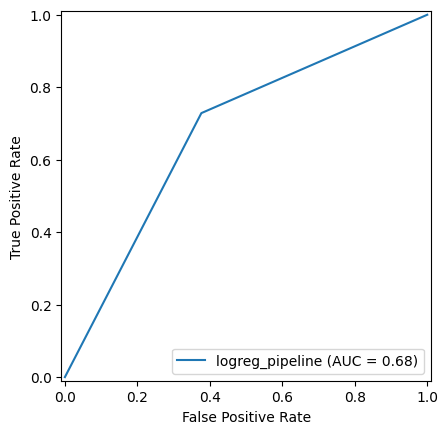

In [1180]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_train, df_probs_threshs[best_tresh])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

## Предсказания с лучшим порогом классификации:

In [190]:
probs_test = best_cat_pipeline.predict_proba(X_test)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds = (probs_test >= best_tresh).astype(int)


## Оценка предсказаний (с лучшим порогом классификации):

In [191]:
recall0 = round(recall_score(y_test, preds, pos_label=0), 2)
recall1 = round(recall_score(y_test, preds, pos_label=1), 2)
acc = round(accuracy_score(y_test, preds), 2)
balanced_acc = round(balanced_accuracy_score(y_test, preds), 2)

f1 = round(f1_score(y_test, preds), 2)
rocauc = round(roc_auc_score(y_test, preds), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_test, preds)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

Recall Score0: 0.72
Recall Score1: 0.69

Balanced Accuracy Score: 0.71
F1 Score: 0.79
ROC-AUC: 0.71

Accuracy Score: 0.7
Accuracy for Class 0: 0.72
Accuracy for Class 1: 0.69


#### Оценка для обучающего сета:

In [192]:
probs_train = best_cat_pipeline.predict_proba(X_train)[:, 1] 

# Apply threshold to probabilities to create binary outcomes
preds_train = (probs_train >= best_tresh).astype(int)

In [193]:
recall0 = round(recall_score(y_train, preds_train, pos_label=0), 2)
recall1 = round(recall_score(y_train, preds_train, pos_label=1), 2)
acc = round(accuracy_score(y_train, preds_train), 2)
balanced_acc = round(balanced_accuracy_score(y_train, preds_train), 2)

f1 = round(f1_score(y_train, preds_train), 2)
rocauc = round(roc_auc_score(y_train, preds_train), 2)

print(f'Recall Score0: {recall0}')
print(f'Recall Score1: {recall1}')
print()
print(f'Balanced Accuracy Score: {balanced_acc}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {rocauc}')
print()
print(f'Accuracy Score: {acc}')

# Generate confusion matrix
cm = confusion_matrix(y_train, preds_train)
# cm is typically a 2x2 matrix in binary classification
# True Negative (TN) = cm[0][0]
# False Positive (FP) = cm[0][1]
# False Negative (FN) = cm[1][0]
# True Positive (TP) = cm[1][1]

# Accuracy for Class 0 (Negative Class)
accuracy_class_0 = cm[0][0] / (cm[0][0] + cm[0][1])

# Accuracy for Class 1 (Positive Class)
accuracy_class_1 = cm[1][1] / (cm[1][0] + cm[1][1])

print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')

Recall Score0: 0.71
Recall Score1: 0.69

Balanced Accuracy Score: 0.7
F1 Score: 0.79
ROC-AUC: 0.7

Accuracy Score: 0.69
Accuracy for Class 0: 0.71
Accuracy for Class 1: 0.69


## crossvalidation:

In [194]:
from sklearn.model_selection import cross_validate

In [1221]:
# Выполнение кросс-валидации
#y_probas = cross_val_predict(best_cat_pipeline, X, y, cv=5, method='predict_proba')
y_scores = y_probas[:, 1]  # Вероятности для класса 1

y_pred = cross_val_predict(best_cat_pipeline, X, y, cv=5, method='predict')

0:	learn: 0.6898787	total: 8.81ms	remaining: 2.63s
100:	learn: 0.6230867	total: 881ms	remaining: 1.74s
200:	learn: 0.6097635	total: 1.74s	remaining: 859ms
299:	learn: 0.5964400	total: 2.67s	remaining: 0us
0:	learn: 0.6904210	total: 9.85ms	remaining: 2.95s
100:	learn: 0.6251996	total: 892ms	remaining: 1.76s
200:	learn: 0.6117505	total: 1.82s	remaining: 898ms
299:	learn: 0.5993920	total: 2.75s	remaining: 0us
0:	learn: 0.6896743	total: 9.59ms	remaining: 2.87s
100:	learn: 0.6244180	total: 900ms	remaining: 1.77s
200:	learn: 0.6122777	total: 1.79s	remaining: 880ms
299:	learn: 0.5993636	total: 2.69s	remaining: 0us
0:	learn: 0.6897475	total: 9.97ms	remaining: 2.98s
100:	learn: 0.6230845	total: 878ms	remaining: 1.73s
200:	learn: 0.6103797	total: 1.77s	remaining: 871ms
299:	learn: 0.5972962	total: 2.7s	remaining: 0us
0:	learn: 0.6898429	total: 10.1ms	remaining: 3.03s
100:	learn: 0.6244609	total: 884ms	remaining: 1.74s
200:	learn: 0.6112093	total: 1.79s	remaining: 883ms
299:	learn: 0.5979133	tota

In [1182]:
# предсказания с учетом порога:
y_pred = (y_scores >= best_tresh).astype(int)


In [1222]:
cm = confusion_matrix(y, y_pred)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])



In [1223]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_scores)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()




ROC-AUC: 0.72
F1 Score: 0.75

Balanced Accuracy: 0.65

Recall for Class 0: 0.64

Accuracy for Class 0: 0.64
Accuracy for Class 1: 0.67
Recall for Class 1: 0.67



## Save results:

In [199]:
params = grid_search.best_params_
to_safe = ''
for key, value in params.items():
    name = key.split('__')[-1]
    #print(f'{name}={value}')
    to_safe += f'{name}={value}, '

to_safe = to_safe[:-2]
print(to_safe)

depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.05


In [201]:
# Значения, которые нужно добавить:
model_results = {
    "Model": "CatBoost",
    "Hyperparameters": to_safe,
    "Classification threshold": best_tresh,
    "ROC-AUC": round(rocauc, 2),
    "F1 Score": round(f1, 2),
    "Balanced Accuracy": round(balanced_acc, 2),
    "Recall for Class 0": round(recall0, 2),
    "Accuracy for Class 0": round(accuracy_class_0, 2),
    "Accuracy for Class 1": round(accuracy_class_1, 2),
    "Recall for Class 1": round(recall1, 2)
    }

# Вычисление следующего индекса для новой строки
next_index = len(results_df)

model_results
# Добавление новой строки в DataFrame
#results_df.loc[next_index] = model_results

In [202]:
results_df

Model                                    Hyperparameters  \
0  Logistic Regression      C=3.0, max_iter=300, penalty=l2, solver=lbfgs   
1        Random Forest  max_depth=5, max_leaf_nodes=2400, min_samples_...   
2             LightGBM  learning_rate=0.05, max_depth=3, min_child_sam...   
3             CatBoost  depth=4, iterations=200, l2_leaf_reg=1, learni...   

   Classification threshold  ROC-AUC  F1 Score  Balanced Accuracy  \
0                      0.84     0.74      0.73               0.68   
1                      0.45     0.75      0.79               0.68   
2                      0.80     0.77      0.82               0.69   
3                      0.82     0.76      0.79               0.69   

   Recall for Class 0  Accuracy for Class 0  Accuracy for Class 1  \
0                0.75                  0.75                  0.60   
1                0.66                  0.66                  0.70   
2                0.64                  0.64                  0.74   
3                0.69                  0.69                  0.69   

   Recall for Class 1  
0                0.60  
1                0.70  
2                0.74  
3                0.69

## feature analysis:

In [203]:
# достаем название фичей из трансформированных данных:
name_f_after_trans = best_cat_pipeline[:-1].get_feature_names_out()
#name_f_after_trans

In [204]:
# достаем важность фичей из обученной модели:
feature_importance = best_cat_pipeline[-1].feature_importances_

In [205]:
# сортируем их попарно в порядке убывания важности фичи для модели:
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importances = feature_importance[sorted_indices]
sorted_names = name_f_after_trans[sorted_indices]

In [206]:
# importances_names = zip(name_f_after_trans, feature_importance)
# print(sorted(importances_names, key=lambda x: x[1], reverse=True))

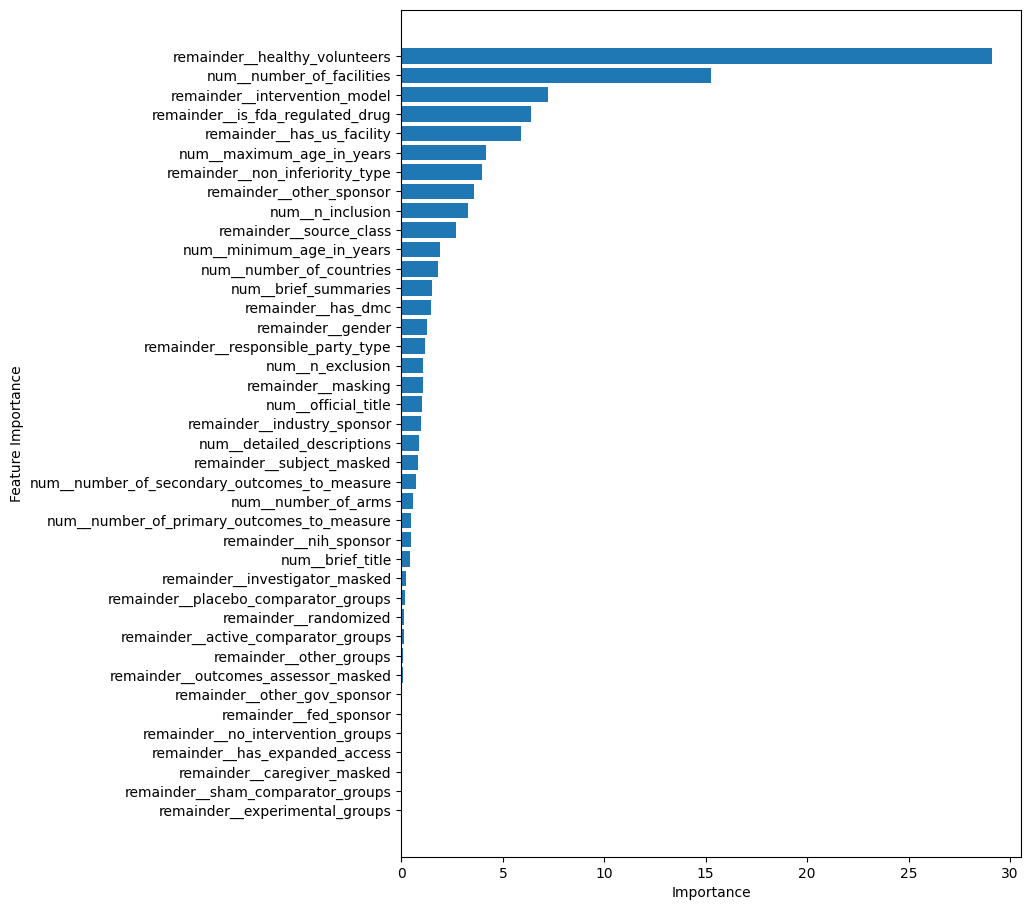

In [207]:
# визуализация важности признаков для предсказания
fig = plt.figure(figsize=(8, 11))
plt.barh(sorted_names, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

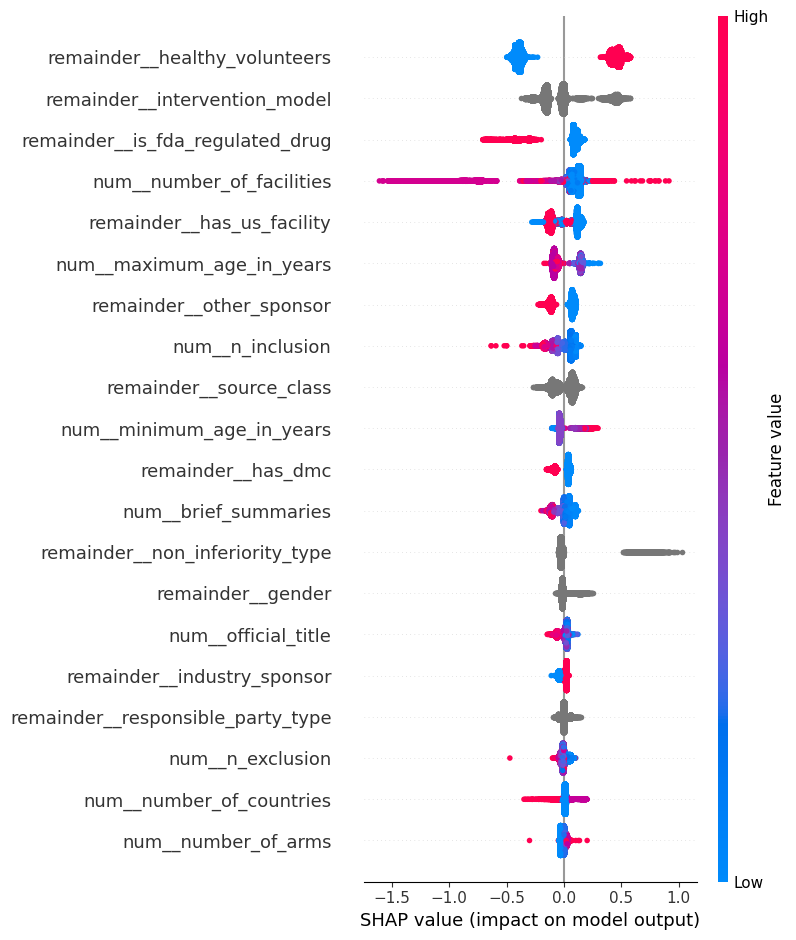

In [389]:
# model и X_train_transformed получены из вашего пайплайна
model = best_cat_pipeline.named_steps['classifier']
X_train_transformed_df = best_cat_pipeline.named_steps['preprocessor'].transform(X_train)

# Конвертация DataFrame в NumPy array, если необходимо
X_train_transformed = X_train_transformed_df.values

# Создание эксплейнера и вычисление SHAP значений
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)

# Использование названий столбцов DataFrame для лучшей интерпретации результатов
feature_names = X_train_transformed_df.columns.tolist()

# Визуализация
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train_transformed[0, :], feature_names=feature_names)


In [488]:
# достаем название фичей из трансформированных данных:
name_f_after_trans = transformer_cat_4.get_feature_names_out()
#name_f_after_trans

In [489]:
# достаем важность фичей из обученной модели:
feature_importance = best_catboost_model.feature_importances_

In [490]:
# сортируем их попарно в порядке убывания важности фичи для модели:
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importances = feature_importance[sorted_indices]
sorted_names = name_f_after_trans[sorted_indices]

In [491]:
# importances_names = zip(name_f_after_trans, feature_importance)
# print(sorted(importances_names, key=lambda x: x[1], reverse=True))

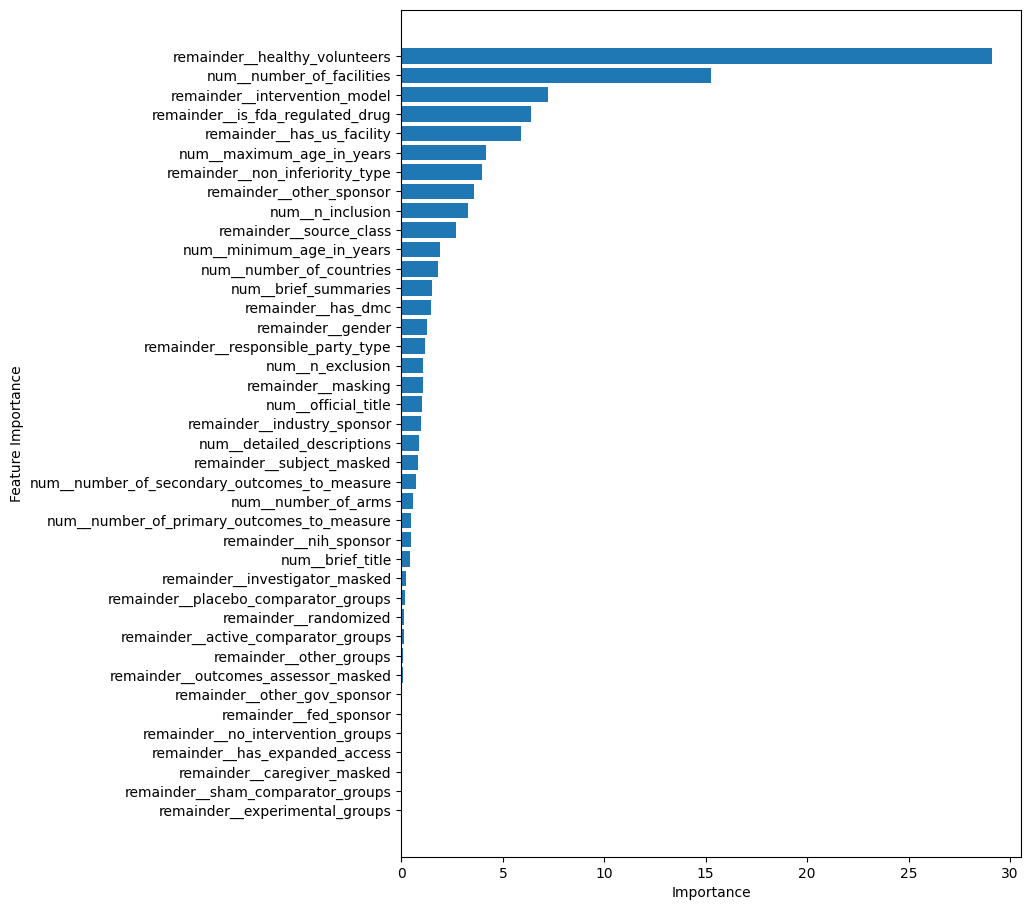

In [492]:
# визуализация важности признаков для предсказания
fig = plt.figure(figsize=(8, 11))
plt.barh(sorted_names, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [493]:
import shap

# Подготовка SHAP значений
explainer = shap.TreeExplainer(best_catboost_model)
shap_values = explainer.shap_values(X_train_trans)

# Визуализация влияния фичей на конкретный пример
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train_trans.iloc[1,:])


<h1 style="color:black">Blending & Stacking:</h1>

In [1224]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase2.drop('overall_status', axis=1)
y = data_Phase2['overall_status']

y = y.astype(int)

## Транформер:

In [210]:
# Трансформер:
transformer_blend = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_all),
        ('ohr', OneHotEncoder(), categorical_features_OHE),
        ('target', TargetEncoder(), categorical_features_target)
    ],
    remainder='passthrough'
)

In [1790]:
#random_under_sampler = RandomUnderSampler(sampling_strategy=0.9, random_state=42)


## Разделение на обучающий и тестовый датасеты:

In [1225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Pipelines: 

In [585]:
# best_logreg_pipeline, best_rf_pipeline, best_xgb_pipeline, best_lgb_pipeline, best_cat_pipeline
# best_catboost_model

## Получение предсказаний:

In [212]:
preds_logreg = best_logreg_pipeline.predict(X_train)

In [213]:
preds_rf = best_rf_pipeline.predict(X_train)

In [227]:
preds_xgb = best_xgb_pipeline.predict(X_train)

In [228]:
preds_lgbm = best_lgb_pipeline.predict(X_train)

In [229]:
preds_cat = best_cat_pipeline.predict(X_train)

In [881]:
# preds_cat_tfidf = cat_pipeline_tfidf.predict(X_train)

In [230]:
preds_logreg_test = best_logreg_pipeline.predict_proba(X_test)
preds_rf_test = best_rf_pipeline.predict_proba(X_test)
preds_xgb_test = best_xgb_pipeline.predict_proba(X_test)
preds_lgbm_test = best_lgb_pipeline.predict_proba(X_test)
preds_cat_test = best_cat_pipeline.predict_proba(X_test)

In [ ]:
preds_logreg_test_class = best_logreg_pipeline.predict(X_test)
preds_rf_test_class = best_rf_pipeline.predict(X_test)
preds_xgb_test_class = best_xgb_pipeline.predict(X_test)
preds_lgbm_test_class = best_lgb_pipeline.predict(X_test)
preds_cat_test_class = best_cat_pipeline.predict(X_test)
preds_cat_tfidf_test_class = cat_pipeline_tfidf.predict(X_test)


## Blending & Stacking предсказаний:

### Округленное среднее:

In [232]:
blended_predictions_average = (preds_logreg_test + preds_rf_test + preds_xgb_test + preds_lgbm_test + preds_cat_test) / 5
# blended_predictions_average = np.where(blended_predictions_average >= 0.5, 1, 0)
# blended_predictions_average

##### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [233]:
pred_prob = blended_predictions_average

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [234]:
# Предсказания для разных порогов классификкации:
thresholds = [0.66, 0.67, 0.68, 0.69, 0.7, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_test'] = np.array(y_test)

In [235]:
#print(df_probs_threshs.to_string())

In [236]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_test'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_test'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_test'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_test'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_test'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_test'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_test'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

For threshold 0.66:
Accuracy Score: 0.81
Recall Score_0: 0.47
Precision Score_0: 0.42
Recall Score_1: 0.88
Precision Score_1: 0.9
F1 Score: 0.89
ROC-AUC: 0.67

For threshold 0.67:
Accuracy Score: 0.8
Recall Score_0: 0.5
Precision Score_0: 0.4
Recall Score_1: 0.86
Precision Score_1: 0.9
F1 Score: 0.88
ROC-AUC: 0.68

For threshold 0.68:
Accuracy Score: 0.79
Recall Score_0: 0.52
Precision Score_0: 0.39
Recall Score_1: 0.85
Precision Score_1: 0.9
F1 Score: 0.87
ROC-AUC: 0.68

For threshold 0.69:
Accuracy Score: 0.78
Recall Score_0: 0.55
Precision Score_0: 0.38
Recall Score_1: 0.83
Precision Score_1: 0.91
F1 Score: 0.87
ROC-AUC: 0.69

For threshold 0.7:
Accuracy Score: 0.77
Recall Score_0: 0.59
Precision Score_0: 0.37
Recall Score_1: 0.81
Precision Score_1: 0.91
F1 Score: 0.86
ROC-AUC: 0.7

For threshold 0.77:
Accuracy Score: 0.66
Recall Score_0: 0.79
Precision Score_0: 0.29
Recall Score_1: 0.64
Precision Score_1: 0.94
F1 Score: 0.76
ROC-AUC: 0.71

For threshold 0.78:
Accuracy Score: 0.65
R

In [237]:
# Выбранный лучший порог:
best_tresh = 0.77

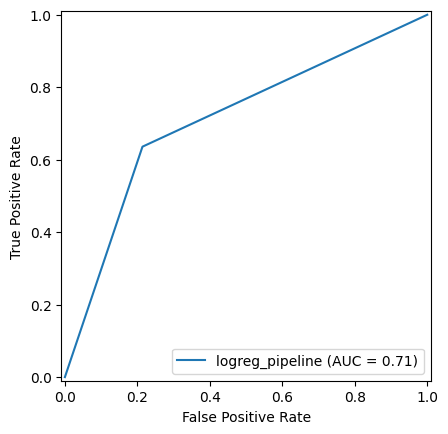

In [238]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_test, df_probs_threshs[best_tresh])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

### Жесткое голосование:

In [240]:
voting_clf_hard = VotingClassifier(estimators=[('logreg', best_logreg_pipeline), ('rf', best_rf_pipeline), ('xgb', best_xgb_pipeline), ('lgb', best_lgb_pipeline), ('cat', best_cat_pipeline)], voting='hard')

In [241]:
voting_clf_hard.fit(X_train, y_train)

0:	learn: 0.6598425	total: 12.3ms	remaining: 2.46s
100:	learn: 0.3825273	total: 972ms	remaining: 953ms
199:	learn: 0.3764286	total: 1.98s	remaining: 0us


VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['brief_title',
                                                                                 'official_title',
                                                                                 'brief_summaries',
                                                                                 'detailed_descriptions',
                                                                                 'n_inclusion',
                                                                                 'n_exclusion',
                                                                                 'number_of_arms',
                                                                                 'number_of_facilities',
                                                                                 'minimum_age_in_years',
                                                                                 'maximum_age_in_years',
                                                                                 'number_of_...
                                                                                   'official_title',
                                                                                   'brief_summaries',
                                                                                   'detailed_descriptions',
                                                                                   'n_inclusion',
                                                                                   'n_exclusion',
                                                                                   'number_of_arms',
                                                                                   'number_of_facilities',
                                                                                   'minimum_age_in_years',
                                                                                   'maximum_age_in_years',
                                                                                   'number_of_primary_outcomes_to_measure',
                                                                                   'number_of_secondary_outcomes_to_measure',
                                                                                   'number_of_countries'])])),
                                              ('classifier',
                                               <catboost.core.CatBoostClassifier object at 0x2c9f974f0>)]))])

In [242]:
hard_voting_predictions = voting_clf_hard.predict(X_test)

#### CROSS VALIDATION:

In [243]:
from sklearn.model_selection import cross_validate

In [244]:
# Выполнение кросс-валидации
preds = cross_val_predict(voting_clf_hard, X, y, cv=5, method='predict')


0:	learn: 0.6588519	total: 20.9ms	remaining: 4.16s
100:	learn: 0.3799333	total: 996ms	remaining: 976ms
199:	learn: 0.3728429	total: 2.05s	remaining: 0us
0:	learn: 0.6589908	total: 11.5ms	remaining: 2.3s
100:	learn: 0.3784231	total: 970ms	remaining: 951ms
199:	learn: 0.3719667	total: 1.94s	remaining: 0us
0:	learn: 0.6596255	total: 9.57ms	remaining: 1.9s
100:	learn: 0.3797060	total: 948ms	remaining: 929ms
199:	learn: 0.3736821	total: 1.91s	remaining: 0us
0:	learn: 0.6591725	total: 9.76ms	remaining: 1.94s
100:	learn: 0.3795196	total: 1.04s	remaining: 1.02s
199:	learn: 0.3732178	total: 2s	remaining: 0us
0:	learn: 0.6595309	total: 11.1ms	remaining: 2.2s
100:	learn: 0.3811429	total: 944ms	remaining: 926ms
199:	learn: 0.3740473	total: 1.92s	remaining: 0us


In [245]:
cm = confusion_matrix(y, preds)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [246]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_scores)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()




ROC-AUC: 0.76
F1 Score: 0.79

Balanced Accuracy: 0.69

Recall for Class 0: 0.69

Accuracy for Class 0: 0.09
Accuracy for Class 1: 0.99
Recall for Class 1: 0.69



#### Оценка качества работы модели voting_clf_hard:

In [1723]:
# Настраиваем k-кратную кросс-валидацию
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Применяем кросс-валидацию
scores = cross_val_score(voting_clf_hard, X, y, cv=kf, scoring='accuracy')

print("Точность на каждом фолде: ", scores)
print("Средняя точность: ", scores.mean())


0:	learn: 0.6831648	total: 2.23ms	remaining: 891ms
100:	learn: 0.5634259	total: 248ms	remaining: 734ms
200:	learn: 0.5482389	total: 494ms	remaining: 489ms
300:	learn: 0.5283955	total: 739ms	remaining: 243ms
399:	learn: 0.5132300	total: 980ms	remaining: 0us
0:	learn: 0.6837582	total: 2.63ms	remaining: 1.05s
100:	learn: 0.5687521	total: 245ms	remaining: 726ms
200:	learn: 0.5516771	total: 548ms	remaining: 543ms
300:	learn: 0.5317441	total: 795ms	remaining: 262ms
399:	learn: 0.5168921	total: 1.04s	remaining: 0us
Точность на каждом фолде:  [0.68449398 0.69533997]
Средняя точность:  0.6899169720996334


In [1724]:
scores_f1_macro = cross_val_score(voting_clf_hard, X, y, cv=kf, scoring='f1_macro')
print("F1-балл (macro) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (macro): ", scores_f1_macro.mean())



0:	learn: 0.6831648	total: 2.49ms	remaining: 993ms
100:	learn: 0.5634259	total: 244ms	remaining: 723ms
200:	learn: 0.5482389	total: 496ms	remaining: 491ms
300:	learn: 0.5283955	total: 746ms	remaining: 246ms
399:	learn: 0.5132300	total: 988ms	remaining: 0us
0:	learn: 0.6837582	total: 1.84ms	remaining: 735ms
100:	learn: 0.5687521	total: 235ms	remaining: 696ms
200:	learn: 0.5516771	total: 481ms	remaining: 476ms
300:	learn: 0.5317441	total: 730ms	remaining: 240ms
399:	learn: 0.5168921	total: 978ms	remaining: 0us
F1-балл (macro) на каждом фолде:  [0.60212004 0.61443619]
Средний F1-балл (macro):  0.6082781136381532


In [1725]:
scores_f1_macro = cross_val_score(voting_clf_hard, X, y, cv=kf, scoring='f1_weighted')
print("F1-балл (weighted) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (weighted): ", scores_f1_macro.mean())


0:	learn: 0.6831648	total: 2.5ms	remaining: 999ms
100:	learn: 0.5634259	total: 245ms	remaining: 727ms
200:	learn: 0.5482389	total: 493ms	remaining: 488ms
300:	learn: 0.5283955	total: 736ms	remaining: 242ms
399:	learn: 0.5132300	total: 977ms	remaining: 0us
0:	learn: 0.6837582	total: 2.47ms	remaining: 984ms
100:	learn: 0.5687521	total: 250ms	remaining: 740ms
200:	learn: 0.5516771	total: 494ms	remaining: 489ms
300:	learn: 0.5317441	total: 739ms	remaining: 243ms
399:	learn: 0.5168921	total: 989ms	remaining: 0us
F1-балл (weighted) на каждом фолде:  [0.72349397 0.73163041]
Средний F1-балл (weighted):  0.7275621894883211


In [1726]:
# Делаем кросс-валидированные предсказания
y_pred = cross_val_predict(voting_clf_hard, X, y, cv=kf)

# Вычисляем полноту для неуспешных исследований
recall = recall_score(y, y_pred, pos_label=0)

print(f"Полнота для неуспешных исследований: {recall}")



0:	learn: 0.6831648	total: 2.5ms	remaining: 996ms
100:	learn: 0.5634259	total: 243ms	remaining: 720ms
200:	learn: 0.5482389	total: 488ms	remaining: 483ms
300:	learn: 0.5283955	total: 727ms	remaining: 239ms
399:	learn: 0.5132300	total: 973ms	remaining: 0us
0:	learn: 0.6837582	total: 2.39ms	remaining: 952ms
100:	learn: 0.5687521	total: 244ms	remaining: 723ms
200:	learn: 0.5516771	total: 493ms	remaining: 488ms
300:	learn: 0.5317441	total: 735ms	remaining: 242ms
399:	learn: 0.5168921	total: 980ms	remaining: 0us
Полнота для неуспешных исследований: 0.7008086253369272


### Мягкое голосование:

In [1226]:
voting_clf_soft = VotingClassifier(estimators=[('logreg', best_logreg_pipeline), ('rf', best_rf_pipeline), ('xgb', best_xgb_pipeline), ('lgb', best_lgb_pipeline), ('cat', best_cat_pipeline)], voting='soft')

In [1227]:
voting_clf_soft.fit(X_train, y_train)

0:	learn: 0.6902796	total: 15.9ms	remaining: 4.74s
100:	learn: 0.6211853	total: 1.06s	remaining: 2.09s
200:	learn: 0.6087801	total: 1.98s	remaining: 974ms
299:	learn: 0.5952090	total: 2.92s	remaining: 0us


VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['brief_title',
                                                                                 'official_title',
                                                                                 'brief_summaries',
                                                                                 'detailed_descriptions',
                                                                                 'n_inclusion',
                                                                                 'n_exclusion',
                                                                                 'number_of_arms',
                                                                                 'number_of_facilities',
                                                                                 'minimum_age_in_years',
                                                                                 'maximum_age_in_years',
                                                                                 'number_of_...
                                                                                   'brief_summaries',
                                                                                   'detailed_descriptions',
                                                                                   'n_inclusion',
                                                                                   'n_exclusion',
                                                                                   'number_of_arms',
                                                                                   'number_of_facilities',
                                                                                   'minimum_age_in_years',
                                                                                   'maximum_age_in_years',
                                                                                   'number_of_primary_outcomes_to_measure',
                                                                                   'number_of_secondary_outcomes_to_measure',
                                                                                   'number_of_countries'])])),
                                              ('classifier',
                                               <catboost.core.CatBoostClassifier object at 0x2c52d6500>)]))],
                 voting='soft')

In [1228]:
soft_voting_predictions = voting_clf_soft.predict(X_test)

#### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [1236]:
pred_prob = voting_clf_soft.predict_proba(X_train)

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [1251]:
# Предсказания для разных порогов классификкации:
thresholds = [0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.66, 0.67, 0.68, 0.69, 0.7, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_test'] = np.array(y_train)

In [1252]:
#print(df_probs_threshs.to_string())

In [1253]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_test'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_test'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_test'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_test'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_test'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_test'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_test'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

For threshold 0.56:
Accuracy Score: 0.75
Recall Score_0: 0.46
Precision Score_0: 0.46
Recall Score_1: 0.84
Precision Score_1: 0.84
F1 Score: 0.84
ROC-AUC: 0.65

For threshold 0.57:
Accuracy Score: 0.74
Recall Score_0: 0.5
Precision Score_0: 0.45
Recall Score_1: 0.82
Precision Score_1: 0.84
F1 Score: 0.83
ROC-AUC: 0.66

For threshold 0.58:
Accuracy Score: 0.74
Recall Score_0: 0.53
Precision Score_0: 0.44
Recall Score_1: 0.8
Precision Score_1: 0.85
F1 Score: 0.82
ROC-AUC: 0.66

For threshold 0.59:
Accuracy Score: 0.73
Recall Score_0: 0.56
Precision Score_0: 0.43
Recall Score_1: 0.78
Precision Score_1: 0.85
F1 Score: 0.81
ROC-AUC: 0.67

For threshold 0.6:
Accuracy Score: 0.72
Recall Score_0: 0.59
Precision Score_0: 0.42
Recall Score_1: 0.75
Precision Score_1: 0.86
F1 Score: 0.8
ROC-AUC: 0.67

For threshold 0.61:
Accuracy Score: 0.7
Recall Score_0: 0.62
Precision Score_0: 0.41
Recall Score_1: 0.73
Precision Score_1: 0.86
F1 Score: 0.79
ROC-AUC: 0.67

For threshold 0.66:
Accuracy Score: 0.6

In [1254]:
# Выбранный лучший порог:
best_tresh_blend = 0.59

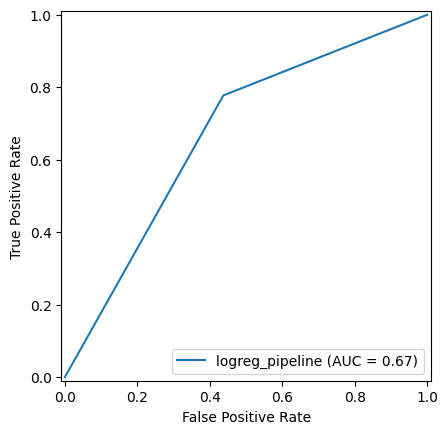

In [1255]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_train, df_probs_threshs[best_tresh_blend])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

#### CROSS VALIDATION:

In [1233]:
y_pred = cross_val_predict(voting_clf_soft, X, y, cv=5, method='predict')

0:	learn: 0.6898787	total: 18.9ms	remaining: 5.64s
100:	learn: 0.6230867	total: 950ms	remaining: 1.87s
200:	learn: 0.6097635	total: 1.89s	remaining: 932ms
299:	learn: 0.5964400	total: 2.84s	remaining: 0us
0:	learn: 0.6904210	total: 9.99ms	remaining: 2.99s
100:	learn: 0.6251996	total: 1.03s	remaining: 2.02s
200:	learn: 0.6117505	total: 2.02s	remaining: 997ms
299:	learn: 0.5993920	total: 2.94s	remaining: 0us
0:	learn: 0.6896743	total: 10ms	remaining: 3s
100:	learn: 0.6244180	total: 963ms	remaining: 1.9s
200:	learn: 0.6122777	total: 1.86s	remaining: 916ms
299:	learn: 0.5993636	total: 2.75s	remaining: 0us
0:	learn: 0.6897475	total: 8.96ms	remaining: 2.68s
100:	learn: 0.6230845	total: 1.02s	remaining: 2.01s
200:	learn: 0.6103797	total: 1.91s	remaining: 940ms
299:	learn: 0.5972962	total: 2.82s	remaining: 0us
0:	learn: 0.6898429	total: 9.92ms	remaining: 2.97s
100:	learn: 0.6244609	total: 851ms	remaining: 1.68s
200:	learn: 0.6112093	total: 1.73s	remaining: 853ms
299:	learn: 0.5979133	total: 2.

In [1234]:
cm = confusion_matrix(y, y_pred)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [1235]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_scores)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()

ROC-AUC: 0.72
F1 Score: 0.86

Balanced Accuracy: 0.60

Recall for Class 0: 0.28

Accuracy for Class 0: 0.28
Accuracy for Class 1: 0.92
Recall for Class 1: 0.92



In [1256]:
# Выполнение кросс-валидации
y_probas = cross_val_predict(voting_clf_soft, X, y, cv=5, method='predict_proba')
y_scores = y_probas[:, 1]  # Вероятности для класса 1


0:	learn: 0.6898787	total: 14.4ms	remaining: 4.31s
100:	learn: 0.6230867	total: 948ms	remaining: 1.87s
200:	learn: 0.6097635	total: 1.88s	remaining: 928ms
299:	learn: 0.5964400	total: 2.84s	remaining: 0us
0:	learn: 0.6904210	total: 10.1ms	remaining: 3.03s
100:	learn: 0.6251996	total: 901ms	remaining: 1.77s
200:	learn: 0.6117505	total: 1.83s	remaining: 902ms
299:	learn: 0.5993920	total: 2.8s	remaining: 0us
0:	learn: 0.6896743	total: 10.4ms	remaining: 3.11s
100:	learn: 0.6244180	total: 919ms	remaining: 1.81s
200:	learn: 0.6122777	total: 1.85s	remaining: 911ms
299:	learn: 0.5993636	total: 2.78s	remaining: 0us
0:	learn: 0.6897475	total: 12.7ms	remaining: 3.78s
100:	learn: 0.6230845	total: 928ms	remaining: 1.83s
200:	learn: 0.6103797	total: 1.85s	remaining: 913ms
299:	learn: 0.5972962	total: 2.81s	remaining: 0us
0:	learn: 0.6898429	total: 9.35ms	remaining: 2.79s
100:	learn: 0.6244609	total: 904ms	remaining: 1.78s
200:	learn: 0.6112093	total: 1.82s	remaining: 899ms
299:	learn: 0.5979133	tota

In [1257]:
# предсказания с учетом порога:
y_pred = (y_scores >= best_tresh_blend).astype(int)


In [1258]:
cm = confusion_matrix(y, y_pred)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [1259]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y, y_pred, pos_label=0)
recall1 = recall_score(y, y_pred, pos_label=1)
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
rocauc = roc_auc_score(y, y_scores)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()




ROC-AUC: 0.71
F1 Score: 0.80

Balanced Accuracy: 0.65

Recall for Class 0: 0.53

Accuracy for Class 0: 0.53
Accuracy for Class 1: 0.76
Recall for Class 1: 0.76



#### Оценка качества работы модели voting_clf_soft:

In [877]:
# Настраиваем k-кратную кросс-валидацию
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Применяем кросс-валидацию
scores = cross_val_score(voting_clf_soft, X, y, cv=kf, scoring='accuracy')

print("Точность на каждом фолде: ", scores)
print("Средняя точность: ", scores.mean())


0:	learn: 0.6597150	total: 9.89ms	remaining: 1.97s
100:	learn: 0.3820748	total: 839ms	remaining: 823ms
199:	learn: 0.3755433	total: 1.7s	remaining: 0us
0:	learn: 0.6593402	total: 8.57ms	remaining: 1.71s
100:	learn: 0.3775006	total: 866ms	remaining: 849ms
199:	learn: 0.3697845	total: 1.74s	remaining: 0us
0:	learn: 0.6585693	total: 17.2ms	remaining: 3.42s
100:	learn: 0.3795455	total: 905ms	remaining: 887ms
199:	learn: 0.3724446	total: 1.77s	remaining: 0us
Точность на каждом фолде:  [0.84767479 0.84221765 0.84948193]
Средняя точность:  0.8464581219531467


In [878]:
scores_f1_macro = cross_val_score(voting_clf_soft, X, y, cv=kf, scoring='f1_macro')
print("F1-балл (macro) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (macro): ", scores_f1_macro.mean())



0:	learn: 0.6597150	total: 9.31ms	remaining: 1.85s
100:	learn: 0.3820748	total: 908ms	remaining: 890ms
199:	learn: 0.3755433	total: 1.83s	remaining: 0us
0:	learn: 0.6593402	total: 12.6ms	remaining: 2.5s
100:	learn: 0.3775006	total: 944ms	remaining: 925ms
199:	learn: 0.3697845	total: 1.88s	remaining: 0us
0:	learn: 0.6585693	total: 28.6ms	remaining: 5.7s
100:	learn: 0.3795455	total: 962ms	remaining: 943ms
199:	learn: 0.3724446	total: 1.92s	remaining: 0us
F1-балл (macro) на каждом фолде:  [0.55601304 0.54362425 0.55804051]
Средний F1-балл (macro):  0.5525592653733806


In [1721]:
scores_f1_macro = cross_val_score(voting_clf_soft, X, y, cv=kf, scoring='f1_weighted')
print("F1-балл (weighted) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (weighted): ", scores_f1_macro.mean())


0:	learn: 0.6831648	total: 3.34ms	remaining: 1.33s
100:	learn: 0.5634259	total: 246ms	remaining: 727ms
200:	learn: 0.5482389	total: 497ms	remaining: 492ms
300:	learn: 0.5283955	total: 745ms	remaining: 245ms
399:	learn: 0.5132300	total: 994ms	remaining: 0us
0:	learn: 0.6837582	total: 4.9ms	remaining: 1.96s
100:	learn: 0.5687521	total: 246ms	remaining: 727ms
200:	learn: 0.5516771	total: 494ms	remaining: 489ms
300:	learn: 0.5317441	total: 737ms	remaining: 243ms
399:	learn: 0.5168921	total: 984ms	remaining: 0us
F1-балл (weighted) на каждом фолде:  [0.72386752 0.73086001]
Средний F1-балл (weighted):  0.727363762879687


In [1722]:
# Делаем кросс-валидированные предсказания
y_pred = cross_val_predict(voting_clf_soft, X, y, cv=kf)

# Вычисляем полноту для неуспешных исследований
recall = recall_score(y, y_pred, pos_label=0)

print(f"Полнота для неуспешных исследований: {recall}")



0:	learn: 0.6831648	total: 3.11ms	remaining: 1.24s
100:	learn: 0.5634259	total: 271ms	remaining: 803ms
200:	learn: 0.5482389	total: 523ms	remaining: 518ms
300:	learn: 0.5283955	total: 765ms	remaining: 252ms
399:	learn: 0.5132300	total: 1.01s	remaining: 0us
0:	learn: 0.6837582	total: 2.59ms	remaining: 1.03s
100:	learn: 0.5687521	total: 247ms	remaining: 731ms
200:	learn: 0.5516771	total: 493ms	remaining: 489ms
300:	learn: 0.5317441	total: 735ms	remaining: 242ms
399:	learn: 0.5168921	total: 974ms	remaining: 0us
Полнота для неуспешных исследований: 0.7055256064690026


### Random forest:

#### Датасет и обучение:

In [262]:
X_blended_train = pd.DataFrame({'preds_logreg' : preds_logreg,
                        'preds_rf' : preds_rf,
                        'preds_xgb' : preds_xgb,
                        'preds_lgbm' : preds_lgbm,
                        'preds_catboost' : preds_cat
                               })

X_blended_test = pd.DataFrame({'preds_logreg' : preds_logreg_test_class,
                        'preds_rf' : preds_rf_test_class,
                        'preds_xgb' : preds_xgb_test_class,
                        'preds_lgbm' : preds_lgbm_test_class,
                        'preds_catboost' : preds_cat_test_class
                               })

In [372]:
# Model:
#rf_model_blend = RandomForestClassifier(
    #     n_estimators=700,
    #     max_depth=5,
    #     min_samples_split=2,
    #     min_samples_leaf=4,
    #     max_leaf_nodes=2400,
    #     verbose=0
    # )

rf_model_blend = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')

In [373]:
rf_model_blend.fit(X_blended_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

#### Grid search log_regr_blending:

In [297]:
param_grid = {
    'n_estimators': [700], #, 1000, 1200 800 600
    'max_depth' : [5], #4
    'class_weight' : [None], # 'balanced'
    'min_samples_split' : [2], #1 3
    'min_samples_leaf' : [4], #5
    'max_leaf_nodes' : [2400] #2300
}

# Grid search of parameters:
grid_search_log_regr_blending = GridSearchCV(
    estimator = rf_model_blend, 
    cv = 3,
    param_grid = param_grid,
    scoring = 'f1',
    verbose=100
)

grid_search_log_regr_blending.fit(X_blended_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search_log_regr_blending.best_params_}")
print(f"Лучший: {grid_search_log_regr_blending.best_score_}")

# Лучшие параметры: {'class_weight': None, 'max_depth': 5, 'max_leaf_nodes': 2400, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 800}
# Лучший: 0.9174749053047663

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START class_weight=None, max_depth=5, max_leaf_nodes=2400, min_samples_leaf=4, min_samples_split=2, n_estimators=700
[CV 1/3; 1/2] END class_weight=None, max_depth=5, max_leaf_nodes=2400, min_samples_leaf=4, min_samples_split=2, n_estimators=700;, score=0.917 total time=   1.4s
[CV 2/3; 1/2] START class_weight=None, max_depth=5, max_leaf_nodes=2400, min_samples_leaf=4, min_samples_split=2, n_estimators=700
[CV 2/3; 1/2] END class_weight=None, max_depth=5, max_leaf_nodes=2400, min_samples_leaf=4, min_samples_split=2, n_estimators=700;, score=0.916 total time=   1.5s
[CV 3/3; 1/2] START class_weight=None, max_depth=5, max_leaf_nodes=2400, min_samples_leaf=4, min_samples_split=2, n_estimators=700
[CV 3/3; 1/2] END class_weight=None, max_depth=5, max_leaf_nodes=2400, min_samples_leaf=4, min_samples_split=2, n_estimators=700;, score=0.918 total time=   1.5s
[CV 1/3; 2/2] START class_weight=None, max_depth=5, max_leaf_n

#### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [300]:
pred_prob = rf_model_blend.predict_proba(X_blended_train)

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [301]:
# Предсказания для разных порогов классификкации:
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9 ]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_train'] = np.array(y_train)

In [302]:
#print(df_probs_threshs.to_string())

In [303]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

For threshold 0.4:
Accuracy Score: 0.85
Recall Score_0: 0.1
Precision Score_0: 0.85
Recall Score_1: 1.0
Precision Score_1: 0.85
F1 Score: 0.92
ROC-AUC: 0.55

For threshold 0.5:
Accuracy Score: 0.85
Recall Score_0: 0.11
Precision Score_0: 0.83
Recall Score_1: 1.0
Precision Score_1: 0.85
F1 Score: 0.92
ROC-AUC: 0.55

For threshold 0.6:
Accuracy Score: 0.85
Recall Score_0: 0.11
Precision Score_0: 0.83
Recall Score_1: 1.0
Precision Score_1: 0.85
F1 Score: 0.92
ROC-AUC: 0.55

For threshold 0.7:
Accuracy Score: 0.85
Recall Score_0: 0.11
Precision Score_0: 0.75
Recall Score_1: 0.99
Precision Score_1: 0.85
F1 Score: 0.92
ROC-AUC: 0.55

For threshold 0.8:
Accuracy Score: 0.64
Recall Score_0: 0.78
Precision Score_0: 0.28
Recall Score_1: 0.61
Precision Score_1: 0.93
F1 Score: 0.74
ROC-AUC: 0.69

For threshold 0.85:
Accuracy Score: 0.64
Recall Score_0: 0.78
Precision Score_0: 0.28
Recall Score_1: 0.61
Precision Score_1: 0.93
F1 Score: 0.74
ROC-AUC: 0.69

For threshold 0.9:
Accuracy Score: 0.64
Rec

In [304]:
# Выбранный лучший порог:
best_tresh_blend = 0.7

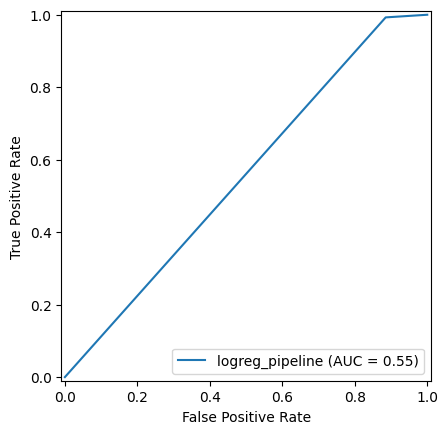

In [305]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_train, df_probs_threshs[best_tresh_blend])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

#### Оценка:

In [374]:
blended_predictions_rf = rf_model_blend.predict(X_blended_test)

In [375]:
cm = confusion_matrix(y_test, blended_predictions_rf)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [376]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y_test, blended_predictions_rf, pos_label=0)
recall1 = recall_score(y_test, blended_predictions_rf, pos_label=1)
accuracy = accuracy_score(y_test, blended_predictions_rf)
balanced_acc = balanced_accuracy_score(y_test, blended_predictions_rf)
f1 = f1_score(y_test, blended_predictions_rf)
rocauc = roc_auc_score(y_test, blended_predictions_rf)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()




ROC-AUC: 0.70
F1 Score: 0.74

Balanced Accuracy: 0.70

Recall for Class 0: 0.78

Accuracy for Class 0: 0.78
Accuracy for Class 1: 0.62
Recall for Class 1: 0.62



### Лог регресиия:

#### Датасет и обучение:

In [321]:
X_blended_train = pd.DataFrame({'preds_logreg' : preds_logreg,
                        'preds_rf' : preds_rf,
                        'preds_xgb' : preds_xgb,
                        'preds_lgbm' : preds_lgbm,
                        'preds_catboost' : preds_cat
                               })

X_blended_test = pd.DataFrame({'preds_logreg' : preds_logreg_test_class,
                        'preds_rf' : preds_rf_test_class,
                        'preds_xgb' : preds_xgb_test_class,
                        'preds_lgbm' : preds_lgbm_test_class,
                        'preds_catboost' : preds_cat_test_class
                               })

In [366]:
# Model:

log_regr_blending = LogisticRegression(
    #penalty='l2',         # Specifies the norm used in the penalization (l2 is the standard Ridge regression)             # Inverse of regularization strength; smaller values specify stronger regularization
    #max_iter=20, 
    #C=1,
    #solver='lbfgs',
    class_weight='balanced',
    # Maximum number of iterations taken for the solvers to converge
    random_state=None,    # Seed of the pseudo random number generator to use when shuffling the data
    verbose=0            # For liblinear and lbfgs solvers, set verbose to any positive number for verbosity
)

In [367]:
log_regr_blending.fit(X_blended_train, y_train)

LogisticRegression(class_weight='balanced')

#### Grid search log_regr_blending:

In [355]:
param_grid = {
    'max_iter': [ 30],
    #'penalty' : [None, 'l2'],
    #'C' : [0, 1.0],
    #'solver' : [None,'lbfgs']
    #'l1_ratio' : [1,2]
}

# Grid search of parameters:
grid_search_log_regr_blending = GridSearchCV(
    estimator = log_regr_blending, 
    cv = 5,
    param_grid = param_grid,
    scoring = 'f1',
    verbose=100
)

grid_search_log_regr_blending.fit(X_blended_train, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search_log_regr_blending.best_params_}")
print(f"Лучший: {grid_search_log_regr_blending.best_score_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START max_iter=30.................................................
[CV 1/5; 1/1] END ..................max_iter=30;, score=0.737 total time=   0.1s
[CV 2/5; 1/1] START max_iter=30.................................................
[CV 2/5; 1/1] END ..................max_iter=30;, score=0.740 total time=   0.0s
[CV 3/5; 1/1] START max_iter=30.................................................
[CV 3/5; 1/1] END ..................max_iter=30;, score=0.732 total time=   0.0s
[CV 4/5; 1/1] START max_iter=30.................................................
[CV 4/5; 1/1] END ..................max_iter=30;, score=0.734 total time=   0.0s
[CV 5/5; 1/1] START max_iter=30.................................................
[CV 5/5; 1/1] END ..................max_iter=30;, score=0.739 total time=   0.0s
Лучшие параметры: {'max_iter': 30}
Лучший: 0.7363494348011732


#### ПОДБОР ЛУЧШЕГО ПОРОГА ДЛЯ КЛАССИФИКАЦИИ:

In [277]:
pred_prob = log_regr_blending.predict_proba(X_blended_train)

# Создание словаря с предсказаниями вероятностей классов:
d = {'0_class_probs' : pred_prob[:, 0],
    '1_class_probs': pred_prob[:, 1]}

# Создание датафрейма с предсказаниями
df_probs_threshs = pd.DataFrame(data = d)

In [281]:
# Предсказания для разных порогов классификкации:
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9 ]

for t in thresholds:
    df_probs_threshs[t] = df_probs_threshs['1_class_probs'].map(lambda x: 1 if x>=t else 0)


# Добавление колонки с эталонными значенями классов:
df_probs_threshs['y_train'] = np.array(y_train)

In [279]:
#print(df_probs_threshs.to_string())

In [282]:
# Оценка метрик для предсказаний по каждому порогу:
for t in thresholds:
    recall0 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    precision0 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=0), 2)
    recall1 = round(recall_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    precision1 = round(precision_score(df_probs_threshs['y_train'], df_probs_threshs[t], pos_label=1), 2)
    acc = round(accuracy_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    f1 = round(f1_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    rocauc = round(roc_auc_score(df_probs_threshs['y_train'], df_probs_threshs[t]), 2)
    
    
    print(f'For threshold {t}:')
    print(f'Accuracy Score: {acc}')
    print(f'Recall Score_0: {recall0}')
    print(f'Precision Score_0: {precision0}')
    print(f'Recall Score_1: {recall1}')
    print(f'Precision Score_1: {precision1}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {rocauc}')
    print()
    

For threshold 0.4:
Accuracy Score: 0.85
Recall Score_0: 0.1
Precision Score_0: 0.85
Recall Score_1: 1.0
Precision Score_1: 0.85
F1 Score: 0.92
ROC-AUC: 0.55

For threshold 0.5:
Accuracy Score: 0.85
Recall Score_0: 0.1
Precision Score_0: 0.85
Recall Score_1: 1.0
Precision Score_1: 0.85
F1 Score: 0.92
ROC-AUC: 0.55

For threshold 0.6:
Accuracy Score: 0.85
Recall Score_0: 0.1
Precision Score_0: 0.84
Recall Score_1: 1.0
Precision Score_1: 0.85
F1 Score: 0.92
ROC-AUC: 0.55

For threshold 0.7:
Accuracy Score: 0.85
Recall Score_0: 0.11
Precision Score_0: 0.82
Recall Score_1: 1.0
Precision Score_1: 0.85
F1 Score: 0.92
ROC-AUC: 0.55

For threshold 0.8:
Accuracy Score: 0.64
Recall Score_0: 0.78
Precision Score_0: 0.28
Recall Score_1: 0.61
Precision Score_1: 0.93
F1 Score: 0.74
ROC-AUC: 0.69

For threshold 0.85:
Accuracy Score: 0.64
Recall Score_0: 0.78
Precision Score_0: 0.28
Recall Score_1: 0.61
Precision Score_1: 0.93
F1 Score: 0.74
ROC-AUC: 0.69

For threshold 0.9:
Accuracy Score: 0.64
Recall

In [285]:
# Выбранный лучший порог:
best_tresh_blend = 0.8

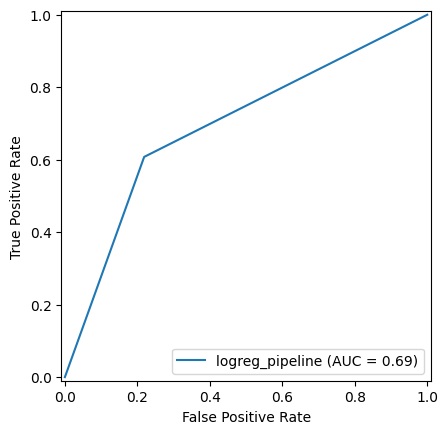

In [286]:
# Построение ROC-кривой для оценки AUC:
fpr, tpr, thresholds = metrics.roc_curve(y_train, df_probs_threshs[best_tresh_blend])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logreg_pipeline')
display.plot()
plt.show()

#### Оценка:

In [368]:
blended_predictions_log_reg = log_regr_blending.predict(X_blended_test)

In [369]:
cm = confusion_matrix(y_test, blended_predictions_log_reg)

# Accuracy для класса 0 (отрицательного)
accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Accuracy для класса 1 (положительного)
accuracy_class_1 = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [370]:
# Создаем специальные скореры, если это необходимо
recall0 = recall_score(y_test, blended_predictions_log_reg, pos_label=0)
recall1 = recall_score(y_test, blended_predictions_log_reg, pos_label=1)
accuracy = accuracy_score(y_test, blended_predictions_log_reg)
balanced_acc = balanced_accuracy_score(y_test, blended_predictions_log_reg)
f1 = f1_score(y_test, blended_predictions_log_reg)
rocauc = roc_auc_score(y_test, blended_predictions_log_reg)  # Используем оценки вероятностей для ROC AUC

# Вывод результатов
print(f'ROC-AUC: {rocauc:.2f}')
print(f'F1 Score: {f1:.2f}')
print()
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print()
print(f'Recall for Class 0: {recall0:.2f}') 
print()
#print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy for Class 0: {accuracy_class_0:.2f}')
print(f'Accuracy for Class 1: {accuracy_class_1:.2f}')
print(f'Recall for Class 1: {recall1:.2f}')
print()




ROC-AUC: 0.70
F1 Score: 0.74

Balanced Accuracy: 0.70

Recall for Class 0: 0.78

Accuracy for Class 0: 0.78
Accuracy for Class 1: 0.62
Recall for Class 1: 0.62



<h1 style="color:lightgrey">Работа с колонками(признаками): (ЛИШНЕЕ для 1ой фазы) (skip):</h1>
я реализовала обработку фичей в (Второй вариант исходного датасета - data_new и его ОБРАБОТКА)

## data_Phase1:

In [2480]:
data_Phase1.columns

Index(['nct_id', 'study_type', 'brief_title', 'official_title',
       'overall_status', 'phase', 'number_of_arms', 'number_of_groups',
       'has_expanded_access', 'source_class', 'brief_summaries',
       'detailed_descriptions', 'number_of_facilities',
       'registered_in_calendar_year', 'actual_duration', 'has_us_facility',
       'has_single_facility', 'minimum_age_in_years', 'maximum_age_in_years',
       'number_of_primary_outcomes_to_measure',
       'number_of_secondary_outcomes_to_measure',
       'number_of_other_outcomes_to_measure', 'allocation',
       'intervention_model', 'masking', 'subject_masked', 'caregiver_masked',
       'investigator_masked', 'outcomes_assessor_masked', 'sampling_method',
       'gender', 'healthy_volunteers', 'criteria', 'gender_based',
       'non_inferiority_type', 'responsible_party_type'],
      dtype='object')

In [2481]:
data_Phase1.isna().mean()

nct_id                                     0.000000
study_type                                 0.000000
brief_title                                0.000000
official_title                             0.012620
overall_status                             0.000000
phase                                      0.000000
number_of_arms                             0.010724
number_of_groups                           1.000000
has_expanded_access                        0.014099
source_class                               0.000000
brief_summaries                            0.000000
detailed_descriptions                      0.479083
number_of_facilities                       0.081172
registered_in_calendar_year                0.000000
actual_duration                            0.036010
has_us_facility                            0.081172
has_single_facility                        0.000000
minimum_age_in_years                       0.009800
maximum_age_in_years                       0.270651
number_of_pr

In [2482]:
# Переименование колонки (чтобы использовать ее как бинарный признак):

data_Phase1 = data_Phase1.rename(columns={'allocation': 'randomized'})

In [2483]:
#--------------Не имеют значения: 
not_informative_columns = ['nct_id', 'study_type', 'phase', 'sampling_method', 'number_of_groups', 'registered_in_calendar_year', 
                    'actual_duration']

"(NAN): 'sampling_method', 'number_of_groups'"


#--------------Бинарные: 
#to be
#is
binary_features = ['has_expanded_access', 'randomized', 'has_us_facility', 'has_single_facility', 'healthy_volunteers']
# 'subject_masked', 'caregiver_masked', 'investigator_masked', 'outcomes_assessor_masked' - исключила, так как по feture analysis они были на 0

#--------------Категориальные: 
#to be
#is
categorical_features = ['source_class', 'intervention_model', 'masking', 
                        'gender', 'responsible_party_type']


#--------------Числовые:
#to be
numeric_features_tobe = ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions', 'criteria']
#is
numeric_features = ['number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 
                    'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure']
numeric_features_all = numeric_features_tobe + numeric_features


#--------------Мало данных:
drop_as_Nan = ['gender_based', 'non_inferiority_type', 'number_of_other_outcomes_to_measure']




#--------------Таргетная переменная: 
'overall_status'

None

### Drop ненужных колонок:

In [2484]:
was_allready_dropped = []
is_dropped = []

for column in not_informative_columns:
    try:
        data_Phase1.drop(column, axis=1, inplace=True)
        is_dropped.append(column)
        #print(f'{column} is dropped.')
    except KeyError:
        was_allready_dropped.append(column)
        #print(f'{column} was allready dropped.')
        
for column in drop_as_Nan:
    try:
        data_Phase1.drop(column, axis=1, inplace=True)
        is_dropped.append(column)
        #print(f'{column} is dropped.')
    except KeyError:
        was_allready_dropped.append(column)
        #print(f'{column} was allready dropped.')
        
print(f'\033[1mWere allready dropped:\033[0m {was_allready_dropped}.')
print(f'\033[1mWere dropped just now:\033[0m {is_dropped}.')



Were allready dropped: [].
Were dropped just now: ['nct_id', 'study_type', 'phase', 'sampling_method', 'number_of_groups', 'registered_in_calendar_year', 'actual_duration', 'gender_based', 'non_inferiority_type', 'number_of_other_outcomes_to_measure'].


### Подготовка бинарных признаков:

In [2486]:
# Проверка, какие значения принимают бинарные переменные:

bin_f_values = {}
for f in binary_features:
    print(f'\033[1m{f}:\033[0m')
    for item in data_Phase1.value_counts(f).to_dict().items():
        print(item)
        bin_f_values[item[0]] = item[1]
    print()

has_expanded_access:
(False, 21247)
(True, 81)

randomized:
('Randomized', 11724)
('Non-Randomized', 3939)

has_us_facility:
(True, 10044)
(False, 9833)

has_single_facility:
(True, 14507)
(False, 7126)

healthy_volunteers:
('Accepts Healthy Volunteers', 12660)
('No', 8950)



In [2487]:
# Replace with 0 and 1 values all binary_features:

bin_f_values = {}
for feature in binary_features:
    data_Phase1.loc[:, feature] = data_Phase1[feature].map({
        True:1, 
        False:0, 
        'Accepts Healthy Volunteers':1, 
        'No':0,
        'Randomized':1,
        'Non-Randomized':0
    }).astype('Int64')
    #print(data_Phase1[feature].value_counts())

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_9938/1780117075.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
 ...
 1, 1, 1, 1, 0, 0, 0, 1, 0, 1]
Length: 21633, dtype: Int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data_Phase1.loc[:, feature] = data_Phase1[feature].map({


In [2488]:
# Replace missing values with mode:

for feature in binary_features:
    mode_value = data_Phase1[feature].mode()[0] if not data_Phase1[feature].mode().empty else None
    data_Phase1[feature] = data_Phase1[feature].fillna(mode_value)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_9938/2455714590.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_Phase1[feature] = data_Phase1[feature].fillna(mode_value)


In [2489]:
# Check if any missing values left in binary_features:

if data_Phase1[binary_features].isna().sum().sum() == 0:
    print(f'No missing values in binary_features: \033[1m{data_Phase1[binary_features].isna().sum().sum() == 0}.\033[0m')
else:
    print('!Some missing values in binary_features:')
    print(data_Phase1[binary_features].isna().sum())
    

No missing values in binary_features: True.


In [2490]:
data_Phase1[binary_features].head()

has_expanded_access  randomized  has_us_facility  has_single_facility  \
8                     0           1                1                    1   
14                    0           1                1                    0   
18                    0           1                0                    0   
23                    0           1                0                    1   
24                    0           1                1                    1   

    healthy_volunteers  
8                    0  
14                   0  
18                   1  
23                   1  
24                   1

### Анализ категориальных признаков:

In [2491]:
# Проверка, какие значения принимают категориальные переменные:

cat_f_values = {}
for f in categorical_features:
    print()
    for item in data_Phase1.value_counts(f).to_dict().items():
        print(item)
        cat_f_values[item[0]] = item[1]


('INDUSTRY', 15434)
('OTHER', 5396)
('NIH', 505)
('OTHER_GOV', 100)
('FED', 85)
('NETWORK', 75)
('UNKNOWN', 28)
('INDIV', 10)

('Parallel Assignment', 7471)
('Single Group Assignment', 6988)
('Crossover Assignment', 4850)
('Sequential Assignment', 2071)
('Factorial Assignment', 127)

('None (Open Label)', 14213)
('Double', 2911)
('Quadruple', 2139)
('Triple', 1265)
('Single', 1017)

('All', 17252)
('Male', 3435)
('Female', 926)

('Sponsor', 18730)
('Principal Investigator', 2048)
('Sponsor-Investigator', 626)


In [2492]:
# Хи-квадрат для оценки информативности признаков, (насколько от них зависит таргетная переменная):

for feature in categorical_features:
    contingency_table=pd.crosstab(data_Phase1[feature], data_Phase1['overall_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f'\033[1m{feature}:\033[0m')
    print(f"Chi-squared Test Statistic: {chi2}")
    print(f"p-value: {p}")
    print()

source_class:
Chi-squared Test Statistic: 595.7706570853663
p-value: 1.982622288313438e-124

intervention_model:
Chi-squared Test Statistic: 646.666933493379
p-value: 1.2275843452407681e-138

masking:
Chi-squared Test Statistic: 138.18134437087517
p-value: 6.917713058792849e-29

gender:
Chi-squared Test Statistic: 228.534620069598
p-value: 2.3677606022854657e-50

responsible_party_type:
Chi-squared Test Statistic: 134.4119545585634
p-value: 6.498526835612236e-30



In [2493]:
categorical_features_target = ['masking', 'responsible_party_type', 'source_class']
categorical_features_OHE = ['gender', 'intervention_model']

# при включении 'intervention_model' в categorical_features_target стало хуже

In [2494]:
# Filling missing values with 'unknown':

for feature in categorical_features:
    data_Phase1[feature] = data_Phase1[feature].astype(str).fillna('unknown')

for feature in categorical_features:
    data_Phase1[feature] = data_Phase1[feature].map(lambda x: 'unknown' if x == 'nan' else x)


### Проверка missing values:

In [2495]:
data_Phase1.isna().mean()

brief_title                                0.000000
official_title                             0.012620
overall_status                             0.000000
number_of_arms                             0.010724
has_expanded_access                        0.000000
source_class                               0.000000
brief_summaries                            0.000000
detailed_descriptions                      0.479083
number_of_facilities                       0.081172
has_us_facility                            0.000000
has_single_facility                        0.000000
minimum_age_in_years                       0.009800
maximum_age_in_years                       0.270651
number_of_primary_outcomes_to_measure      0.001109
number_of_secondary_outcomes_to_measure    0.190034
randomized                                 0.000000
intervention_model                         0.000000
masking                                    0.000000
subject_masked                             0.688069
caregiver_ma

## data_Phase3:

In [2415]:
data_Phase3.columns

Index(['nct_id', 'study_type', 'brief_title', 'official_title',
       'overall_status', 'phase', 'number_of_arms', 'number_of_groups',
       'has_expanded_access', 'source_class', 'brief_summaries',
       'detailed_descriptions', 'number_of_facilities',
       'registered_in_calendar_year', 'actual_duration', 'has_us_facility',
       'has_single_facility', 'minimum_age_in_years', 'maximum_age_in_years',
       'number_of_primary_outcomes_to_measure',
       'number_of_secondary_outcomes_to_measure',
       'number_of_other_outcomes_to_measure', 'allocation',
       'intervention_model', 'masking', 'subject_masked', 'caregiver_masked',
       'investigator_masked', 'outcomes_assessor_masked', 'sampling_method',
       'gender', 'healthy_volunteers', 'criteria', 'gender_based',
       'non_inferiority_type', 'responsible_party_type'],
      dtype='object')

In [2416]:
data_Phase3.isna().mean()

nct_id                                     0.000000
study_type                                 0.000000
brief_title                                0.000000
official_title                             0.017657
overall_status                             0.000000
phase                                      0.000000
number_of_arms                             0.002129
number_of_groups                           1.000000
has_expanded_access                        0.010394
source_class                               0.000000
brief_summaries                            0.000000
detailed_descriptions                      0.433724
number_of_facilities                       0.089913
registered_in_calendar_year                0.000000
actual_duration                            0.047273
has_us_facility                            0.089913
has_single_facility                        0.000000
minimum_age_in_years                       0.032622
maximum_age_in_years                       0.493582
number_of_pr

In [2419]:
# Переименование колонки (чтобы использовать ее как бинарный признак):

data_Phase3 = data_Phase3.rename(columns={'allocation': 'randomized'})

In [2420]:
#--------------Не имеют значения: 
not_informative_columns = ['nct_id', 'study_type', 'phase', 'sampling_method', 'number_of_groups', 'registered_in_calendar_year', 
                    'actual_duration']

"(NAN): 'sampling_method', 'number_of_groups'"


#--------------Бинарные: 
#to be
#is
binary_features = ['has_expanded_access', 'randomized', 'has_us_facility', 'has_single_facility', 'healthy_volunteers', 'subject_masked', 'caregiver_masked', 'investigator_masked', 'outcomes_assessor_masked']
# для Фазы 1: 'subject_masked', 'caregiver_masked', 'investigator_masked', 'outcomes_assessor_masked' - исключила, так как по feture analysis они были на 0

#--------------Категориальные: 
#to be
#is
categorical_features = ['source_class', 'intervention_model', 'masking', 
                        'gender', 'responsible_party_type']


#--------------Числовые:
#to be
numeric_features_tobe = ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions', 'criteria']
#is
numeric_features = ['number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 
                    'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure']
numeric_features_all = numeric_features_tobe + numeric_features


#--------------Мало данных:
drop_as_Nan = ['gender_based', 'non_inferiority_type', 'number_of_other_outcomes_to_measure']




#--------------Таргетная переменная: 
'overall_status'

None

### Drop ненужных колонок:

In [2421]:
was_allready_dropped = []
is_dropped = []

for column in not_informative_columns:
    try:
        data_Phase3.drop(column, axis=1, inplace=True)
        is_dropped.append(column)
        #print(f'{column} is dropped.')
    except KeyError:
        was_allready_dropped.append(column)
        #print(f'{column} was allready dropped.')
        
for column in drop_as_Nan:
    try:
        data_Phase3.drop(column, axis=1, inplace=True)
        is_dropped.append(column)
        #print(f'{column} is dropped.')
    except KeyError:
        was_allready_dropped.append(column)
        #print(f'{column} was allready dropped.')
        
print(f'\033[1mWere allready dropped:\033[0m {was_allready_dropped}.')
print(f'\033[1mWere dropped just now:\033[0m {is_dropped}.')



Were allready dropped: [].
Were dropped just now: ['nct_id', 'study_type', 'phase', 'sampling_method', 'number_of_groups', 'registered_in_calendar_year', 'actual_duration', 'gender_based', 'non_inferiority_type', 'number_of_other_outcomes_to_measure'].


### Подготовка бинарных признаков:

In [2423]:
# Проверка, какие значения принимают бинарные переменные:

bin_f_values = {}
for f in binary_features:
    print(f'\033[1m{f}:\033[0m')
    for item in data_Phase3.value_counts(f).to_dict().items():
        print(item)
        bin_f_values[item[0]] = item[1]
    print()

has_expanded_access:
(False, 15648)
(True, 157)

randomized:
('Randomized', 13293)
('Non-Randomized', 612)

has_us_facility:
(False, 8173)
(True, 6362)

has_single_facility:
(False, 9951)
(True, 6020)

healthy_volunteers:
('No', 13690)
('Accepts Healthy Volunteers', 2250)

subject_masked:
(True, 9055)

caregiver_masked:
(True, 5475)

investigator_masked:
(True, 8369)

outcomes_assessor_masked:
(True, 5793)



In [2424]:
# Replace with 0 and 1 values all binary_features:

bin_f_values = {}
for feature in binary_features:
    data_Phase3.loc[:, feature] = data_Phase3[feature].map({
        True:1, 
        False:0, 
        'Accepts Healthy Volunteers':1, 
        'No':0,
        'Randomized':1,
        'Non-Randomized':0
    }).astype('Int64')
    #print(data_Phase3[feature].value_counts())

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_9938/25388215.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
 ...
 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]
Length: 15971, dtype: Int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data_Phase3.loc[:, feature] = data_Phase3[feature].map({


In [2425]:
# Replace missing values with mode:

for feature in binary_features:
    mode_value = data_Phase3[feature].mode()[0] if not data_Phase3[feature].mode().empty else None
    data_Phase3[feature] = data_Phase3[feature].fillna(mode_value)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_9938/817515158.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_Phase3[feature] = data_Phase3[feature].fillna(mode_value)


In [2426]:
# Check if any missing values left in binary_features:

if data_Phase3[binary_features].isna().sum().sum() == 0:
    print(f'No missing values in binary_features: \033[1m{data_Phase3[binary_features].isna().sum().sum() == 0}.\033[0m')
else:
    print('!Some missing values in binary_features:')
    print(data_Phase3[binary_features].isna().sum())
    

No missing values in binary_features: True.


In [2427]:
data_Phase3[binary_features].head()

has_expanded_access  randomized  has_us_facility  has_single_facility  \
13                    0           1                0                    1   
33                    0           1                0                    1   
37                    0           1                0                    1   
38                    0           1                1                    0   
54                    0           1                0                    0   

    healthy_volunteers  subject_masked  caregiver_masked  investigator_masked  \
13                   1               1                 1                    1   
33                   0               1                 1                    1   
37                   0               1                 1                    1   
38                   0               1                 1                    1   
54                   0               1                 1                    1   

    outcomes_assessor_masked  
13                         1  
33                         1  
37                         1  
38                         1  
54                         1

### Анализ категориальных признаков:

In [2428]:
# Проверка, какие значения принимают категориальные переменные:

cat_f_values = {}
for f in categorical_features:
    print()
    for item in data_Phase3.value_counts(f).to_dict().items():
        print(item)
        cat_f_values[item[0]] = item[1]


('INDUSTRY', 8979)
('OTHER', 6418)
('OTHER_GOV', 319)
('NETWORK', 120)
('FED', 69)
('NIH', 49)
('UNKNOWN', 10)
('INDIV', 7)

('Parallel Assignment', 12710)
('Single Group Assignment', 2358)
('Crossover Assignment', 612)
('Factorial Assignment', 156)
('Sequential Assignment', 76)

('None (Open Label)', 5750)
('Quadruple', 4013)
('Double', 3038)
('Triple', 1827)
('Single', 1289)

('All', 14055)
('Female', 1439)
('Male', 471)

('Sponsor', 11804)
('Principal Investigator', 3566)
('Sponsor-Investigator', 494)


In [2429]:
# Хи-квадрат для оценки информативности признаков, (насколько от них зависит таргетная переменная):

for feature in categorical_features:
    contingency_table=pd.crosstab(data_Phase3[feature], data_Phase3['overall_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f'\033[1m{feature}:\033[0m')
    print(f"Chi-squared Test Statistic: {chi2}")
    print(f"p-value: {p}")
    print()

source_class:
Chi-squared Test Statistic: 25.279385108658033
p-value: 0.0006769296318029085

intervention_model:
Chi-squared Test Statistic: 8.969424033908766
p-value: 0.06186829495360298

masking:
Chi-squared Test Statistic: 22.57859952735903
p-value: 0.00015369033097424465

gender:
Chi-squared Test Statistic: 2.2930495429306688
p-value: 0.31773906877689223

responsible_party_type:
Chi-squared Test Statistic: 29.7409991279205
p-value: 3.481962553561873e-07



In [2430]:
categorical_features_target = ['masking', 'responsible_party_type', 'source_class']
categorical_features_OHE = ['gender', 'intervention_model']

# при включении 'intervention_model' в categorical_features_target стало хуже

In [2431]:
# Filling missing values with 'unknown':

for feature in categorical_features:
    data_Phase3[feature] = data_Phase3[feature].astype(str).fillna('unknown')

for feature in categorical_features:
    data_Phase3[feature] = data_Phase3[feature].map(lambda x: 'unknown' if x == 'nan' else x)


### Проверка missing values:

In [2432]:
data_Phase3.isna().mean()

brief_title                                0.000000
official_title                             0.017657
overall_status                             0.000000
number_of_arms                             0.002129
has_expanded_access                        0.000000
source_class                               0.000000
brief_summaries                            0.000000
detailed_descriptions                      0.433724
number_of_facilities                       0.089913
has_us_facility                            0.000000
has_single_facility                        0.000000
minimum_age_in_years                       0.032622
maximum_age_in_years                       0.493582
number_of_primary_outcomes_to_measure      0.000438
number_of_secondary_outcomes_to_measure    0.140379
randomized                                 0.000000
intervention_model                         0.000000
masking                                    0.000000
subject_masked                             0.000000
caregiver_ma

<h1 style="color:lightgrey">XGBoost_1 (skip):</h1>

- c Mean target encoding для части категориальных фичей (при включении 'intervention_model' в categorical_features_target стало хуже)
- ОНЕ для оставшихся категориальных фичей

In [1209]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase1.drop('overall_status', axis=1)
y = data_Phase1['overall_status']

y = y.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Подготовка числовых признаков:

In [1210]:
for feature in numeric_features_tobe[:4]:
    X.loc[pd.notna(data_Phase1[feature]), feature] = data_Phase1[feature].apply(lambda x: len(str(x)) if pd.notna(x) else x)
    mean_value = X[feature].mean()
    X[feature] = X[feature].fillna(mean_value)

/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_9938/1941264922.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[feature] = X[feature].fillna(mean_value)
/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_9938/1941264922.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[feature] = X[feature].fillna(mean_value)
/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_9938/1941264922.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.in

In [1211]:
first_flag = True 

In [1212]:
if first_flag:
    feature = 'criteria'
    X.loc[pd.notna(data_Phase1[feature]), feature] = X[feature].apply(lambda x: len(str(x).split('\n')) if pd.notna(x) else x)
    mean_value = X[feature].mean()
    X[feature] = X[feature].fillna(mean_value)
    first_flag = False                           


/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_9938/480846017.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[feature] = X[feature].fillna(mean_value)


In [1213]:
X[numeric_features_tobe].head()

brief_title  official_title  brief_summaries  detailed_descriptions  \
8            76           123.0              501             220.000000   
14           82           111.0              161             134.000000   
18           88           125.0             1317            1387.352822   
23           56           214.0              255            1387.352822   
24           90           180.0              124             103.000000   

    criteria  
8         49  
14        24  
18        20  
23         9  
24        13

###### Проверка missing values numeric_features_tobe

In [1214]:
# Check if any missing values left in numeric_features_tobe:

if X[numeric_features_tobe].isna().sum().sum() == 0:
    print(f'No missing values in binary_features: \033[1m{X[numeric_features_tobe].isna().sum().sum() == 0}.\033[0m')
else:
    print('!Some missing values in binary_features:')
    print(X[numeric_features_tobe].isna().sum())

No missing values in binary_features: True.


### Обработка пустых значений для оставшихся числовых признаков (numeric_fatures):

In [1215]:
# Fill missing values in numeric_features with mean_value:

for feature in numeric_features:
    mean_value = X[feature].mean()
    X[feature] = X[feature].fillna(mean_value)

In [1216]:
# Check if any missing values left in numeric_features:

if X[numeric_features].isna().sum().sum() == 0:
    print(f'No missing values in binary_features: \033[1m{X[numeric_features].isna().sum().sum() == 0}.\033[0m')
else:
    print('!Some missing values in binary_features:')
    print(X[numeric_features].isna().sum())

No missing values in binary_features: True.


## Транформер, модель, xgb_pipeline:

In [1188]:
from xgboost import XGBClassifier

In [1189]:
categorical_numeric_transformer_OHE

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(drop='first'),
                                 ['gender', 'intervention_model']),
                                ('cat_target', CategoricalMeanEncoder(),
                                 ['masking', 'responsible_party_type',
                                  'source_class']),
                                ('num', StandardScaler(),
                                 ['brief_title', 'official_title',
                                  'brief_summaries', 'detailed_descriptions',
                                  'criteria', 'number_of_arms',
                                  'number_of_facilities',
                                  'minimum_age_in_years',
                                  'maximum_age_in_years',
                                  'number_of_primary_outcomes_to_measure',
                                  'number_of_secondary_outcomes_to_measure',
                                  'number_of_other_outcomes_to_measure'])])

In [1217]:
# Вычисление веса для класса в меньшинстве
count_class_0, count_class_1 = np.bincount(y_train)
scale_pos_weight = count_class_1 / count_class_0
print(scale_pos_weight)

5.0


In [1243]:
# Pipeline:
xgb_pipeline = Pipeline(steps=[
    ('categorical_numeric_transformer_OHE', categorical_numeric_transformer_OHE),
    #('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        objective= 'binary:logistic', #'binary:logistic', binary:hinge
        eval_metric='logloss',#'logloss', aucpr
        #use_label_encoder=False,
        learning_rate = 0.1,
        #gamma = 0,
        n_estimators = 6000,
        max_depth = 7,
        #reg_lambda = 1,
        scale_pos_weight=5
    ))
])

## Разделение на обучающий и тестовый датасеты:

In [1227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Подбор гиперпараметров GridSearchCV:

In [1102]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'xgb__learning_rate': [0.1], #0.05
    'xgb__max_depth': [5], #4,5,6,8
    'xgb__n_estimators' : [6000] #8000 0.595 = 6000=5000=3000=2000 != 1500 0.23
}

#0.1, 5, 6000+ - 0.23 recall_scorer
#0.1, 7, 1500 - 0.59 'f1_macro'

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=2,
    scoring=recall_scorer, #'f1_macro', 
    verbose=40,  
    n_jobs=1 
)

# Обучение с поиском по сетке
grid_search.fit(X, y)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-балл (macro): {grid_search.best_score_}")

# Получение лучшей модели
best_xgb_pipeline = grid_search.best_estimator_


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=6000
[CV 1/2; 1/1] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=6000;, score=0.243 total time=   4.9s
[CV 2/2; 1/1] START xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=6000
[CV 2/2; 1/1] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=6000;, score=0.222 total time=   4.9s
Лучшие параметры: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 6000}
Лучший F1-балл (macro): 0.2329290206648697


## Оценка качества работы модели xgb_pipeline:

In [1247]:
# Настраиваем k-кратную кросс-валидацию
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Применяем кросс-валидацию
scores = cross_val_score(xgb_pipeline, X, y, cv=kf, scoring='accuracy')

print("Точность на каждом фолде: ", scores)
print("Средняя точность: ", scores.mean())


Точность на каждом фолде:  [0.8316254 0.8312514]
Средняя точность:  0.8314384022739172


In [1246]:
scores_f1_macro = cross_val_score(xgb_pipeline, X, y, cv=kf, scoring='f1_macro')
print("F1-балл (macro) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (macro): ", scores_f1_macro.mean())



F1-балл (macro) на каждом фолде:  [0.58047047 0.58302124]
Средний F1-балл (macro):  0.5817458538233077


In [1245]:
scores_f1_macro = cross_val_score(xgb_pipeline, X, y, cv=kf, scoring='f1_weighted')
print("F1-балл (weighted) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (weighted): ", scores_f1_macro.mean())

F1-балл (weighted) на каждом фолде:  [0.79809437 0.79650159]
Средний F1-балл (weighted):  0.797297979626653


In [1244]:
# Делаем кросс-валидированные предсказания
y_pred = cross_val_predict(xgb_pipeline, X, y, cv=kf)

# Вычисляем полноту для неуспешных исследований
recall = recall_score(y, y_pred, pos_label=0)

print(f"Полнота для неуспешных исследований: {recall}")

Полнота для неуспешных исследований: 0.1765498652291105


## Сохранение результатов:

In [1166]:
# Сохранение результатов:
results = {
        'Pipeline_name': xgb_pipeline,
        'Model': 'XGBClassifier',
        'Preprocessing': categorical_numeric_transformer_OHE,
        'n_iterations': 6000,
        'n_depth': 7,
        'learning_rate': 0.1,
        'l2_leaf_reg': None,
        'cross_val_recall_Fail_score': 0.22,
        'cross_val_accuracy': 0.82,
        'cross_val_f1_weighted': 0.79,
        'cross_val_f1_macro': 0.59, 
        'Pipeline' : 'xgboost',
    }

add_results_df = pd.DataFrame([results])

In [1167]:
results_df = pd.concat([results_df, add_results_df], ignore_index=True)

In [1168]:
results_df

Pipeline_name               Model  \
0  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
1  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
2  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
3  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
4  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
5  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
6  (ColumnTransformer(remainder='passthrough',\n ...       XGBClassifier   

                                       Preprocessing n_iterations n_depth  \
0  ColumnTransformer(remainder='passthrough',\n  ...         1000       7   
1  ColumnTransformer(remainder='passthrough',\n  ...         1000       6   
2  ColumnTransformer(remainder='passthrough',\n  ...          600       4   
3  ColumnTransformer(remainder='passthrough',\n  ...          500       4   
4  ColumnTransformer(remainder='passthrough',\n  ...          400       4   
5  ColumnTransformer(remainder='passthrough',\n  ...          500       4   
6  ColumnTransformer(remainder='passthrough',\n  ...         6000       7   

   learning_rate l2_leaf_reg  cross_val_recall_Fail_score  cross_val_accuracy  \
0           0.10           1                         0.45                0.78   
1           0.10        None                         0.54                0.76   
2           0.05           1                         0.70                0.70   
3           0.05           1                         0.71                0.70   
4           0.05           1                         0.72                0.69   
5           0.05           1                         0.67                0.73   
6           0.10        None                         0.22                0.82   

   cross_val_f1_weighted  cross_val_f1_macro        Pipeline  
0                   0.79                0.64        catboost  
1                   0.78                0.64        catboost  
2                   0.74                0.62        catboost  
3                   0.73                0.62        catboost  
4                   0.73                0.61        catboost  
5                   0.76                0.64  catboost_tfidf  
6                   0.79                0.59         xgboost

<h1 style="color:lightgrey">XGBoost_2 (skip):</h1>

- c Mean target encoding для части категориальных фичей (при включении 'intervention_model' в categorical_features_target стало хуже)
- ОНЕ для оставшихся категориальных фичей
- TFIDF для текстовых признаков (которые ранее были numeric)

In [1152]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase1.drop('overall_status', axis=1)
y = data_Phase1['overall_status']

y = y.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Преобразование текстовых фичей

### Текстовые фичи:

In [1153]:
text_features = numeric_features_tobe

In [1154]:
X[text_features].head()

brief_title  \
8   Lenalidomide Maintenance Therapy in Stage IIIB...   
14  Phase I and Pharmacokinetic Study of Mitoxantr...   
18  Cannabidiol as a Different Type of an Antipsyc...   
23  A Multiple Dose Study Of PF-06678552 In Health...   
24  Pharmacokinetics and Pharmacodynamics of TRV13...   

                                       official_title  \
8   A Pilot Study of Lenalidomide Maintenance Ther...   
14  Phase I and Pharmacokinetic Study of Mitoxantr...   
18  Cannabidiol as a Different Type of an Antipsyc...   
23  A Phase 1, Randomized, Double-Blind, Placebo-C...   
24  A Randomized, Double-Blind, Placebo-Controlled...   

                                      brief_summaries  \
8   The purpose of this study is to investigate th...   
14  The purpose of the study is to examine the tox...   
18  Despite recent advances in the understanding a...   
23  PF-06678552 is a new compound proposed for the...   
24  This study is designed to compare TRV130 to pl...   

                                detailed_descriptions  \
8   For patients with stage IIIB/IV non-small cell...   
14  The trial of the dose escalation method is fro...   
18                                                NaN   
23                                                NaN   
24  This study will explore the pharmacokinetics, ...   

                                             criteria  
8   Inclusion Criteria:\n\nPatients must have hist...  
14  Inclusion criteria:\n\nPatients must complianc...  
18  Inclusion Criteria:\n\nInformed consent given ...  
23  Inclusion Criteria:\n\nHealthy male and/or fem...  
24  Inclusion Criteria:\n\nInformed consent\nHealt...

### Заполнение missing values:

In [1155]:
# Fill missing values in text_features with '':
imputer = SimpleImputer(strategy='constant', fill_value='')
X[text_features] = imputer.fit_transform(X[text_features])

# #2nd option:
# for feature in text_features:
#     X[feature] = X[feature].fillna('')

In [1156]:
X[text_features].head()

brief_title  \
8   Lenalidomide Maintenance Therapy in Stage IIIB...   
14  Phase I and Pharmacokinetic Study of Mitoxantr...   
18  Cannabidiol as a Different Type of an Antipsyc...   
23  A Multiple Dose Study Of PF-06678552 In Health...   
24  Pharmacokinetics and Pharmacodynamics of TRV13...   

                                       official_title  \
8   A Pilot Study of Lenalidomide Maintenance Ther...   
14  Phase I and Pharmacokinetic Study of Mitoxantr...   
18  Cannabidiol as a Different Type of an Antipsyc...   
23  A Phase 1, Randomized, Double-Blind, Placebo-C...   
24  A Randomized, Double-Blind, Placebo-Controlled...   

                                      brief_summaries  \
8   The purpose of this study is to investigate th...   
14  The purpose of the study is to examine the tox...   
18  Despite recent advances in the understanding a...   
23  PF-06678552 is a new compound proposed for the...   
24  This study is designed to compare TRV130 to pl...   

                                detailed_descriptions  \
8   For patients with stage IIIB/IV non-small cell...   
14  The trial of the dose escalation method is fro...   
18                                                      
23                                                      
24  This study will explore the pharmacokinetics, ...   

                                             criteria  
8   Inclusion Criteria:\n\nPatients must have hist...  
14  Inclusion criteria:\n\nPatients must complianc...  
18  Inclusion Criteria:\n\nInformed consent given ...  
23  Inclusion Criteria:\n\nHealthy male and/or fem...  
24  Inclusion Criteria:\n\nInformed consent\nHealt...

In [1157]:
X[text_features].isna().sum()

brief_title              0
official_title           0
brief_summaries          0
detailed_descriptions    0
criteria                 0
dtype: int64

## Обработка текста и модель:

In [1158]:
# Функция для преобразования текстовых признаков для последующего применения TfidfVectorizer():

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    # удаление знаков препинания и цифр:
    text = re.sub(r'[/d/W]+', '',text)
    # Токенизация:
    words = word_tokenize(text)
    # Удаление стоп слов:
    words = [word for word in words if word not in stopwords.words('english')]
    # Лемматизация:
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Склеиваем обратно в строку:
    text = ' '.join(words)

    return text

In [1159]:
# ColumnTransformer:
preprocessor_tfidf = ColumnTransformer(
    transformers=[
        #('imputer', SimpleImputer(strategy='constant', fill_value=''), text_features),
        ('tfidf1', TfidfVectorizer(preprocessor=preprocess_text), 'brief_title'),
        ('tfidf2', TfidfVectorizer(preprocessor=preprocess_text), 'official_title'),
        ('tfidf3', TfidfVectorizer(preprocessor=preprocess_text), 'brief_summaries'),
        ('tfidf4', TfidfVectorizer(preprocessor=preprocess_text), 'detailed_descriptions'),
        ('tfidf5', TfidfVectorizer(preprocessor=preprocess_text), 'criteria'),
        ('cat', OneHotEncoder(drop='first'), categorical_features_OHE),
        ('cat_target', CategoricalMeanEncoder(), categorical_features_target),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

In [1160]:
# Pipeline:
xgb_tfidf_pipeline = Pipeline(steps=[
    ('preprocessor_tfidf', preprocessor_tfidf),
    ('xgb', XGBClassifier(
        objective='binary:logistic', 
        eval_metric='logloss', 
        #use_label_encoder=False,
        learning_rate = 0.1,
        n_estimators = 6000,
        max_depth = 5,
        #reg_lambda = 1,
        #scale_pos_weight = ,
    ))
    ])

## Разделение на обучающий и тестовый датасеты:

In [1161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Подбор гиперпараметров GridSearchCV:

In [1102]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'xgb__learning_rate': [0.1], #0.05
    'xgb__max_depth': [5], #4,5,6,8
    'xgb__n_estimators' : [6000] #8000 0.595 = 6000=5000=3000=2000 != 1500 0.23
}

#0.1, 5, 6000+ - 0.23 recall_scorer
#0.1, 7, 1500 - 0.59 'f1_macro'

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_tfidf_pipeline,
    param_grid=param_grid,
    cv=2,
    scoring=recall_scorer, #'f1_macro', 
    verbose=40,  
    n_jobs=1 
)

# Обучение с поиском по сетке
grid_search.fit(X, y)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-балл (macro): {grid_search.best_score_}")

# Получение лучшей модели
best_xgb_pipeline = grid_search.best_estimator_


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=6000
[CV 1/2; 1/1] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=6000;, score=0.243 total time=   4.9s
[CV 2/2; 1/1] START xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=6000
[CV 2/2; 1/1] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=6000;, score=0.222 total time=   4.9s
Лучшие параметры: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 6000}
Лучший F1-балл (macro): 0.2329290206648697


## Оценка качества работы модели xgb_tfidf_pipeline:

In [1162]:
# Настраиваем k-кратную кросс-валидацию
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Применяем кросс-валидацию
scores = cross_val_score(xgb_tfidf_pipeline, X, y, cv=kf, scoring='accuracy')

print("Точность на каждом фолде: ", scores)
print("Средняя точность: ", scores.mean())


Точность на каждом фолде:  [0.84149899 0.84112499]
Средняя точность:  0.8413119904256114


In [1163]:
scores_f1_macro = cross_val_score(xgb_tfidf_pipeline, X, y, cv=kf, scoring='f1_macro')
print("F1-балл (macro) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (macro): ", scores_f1_macro.mean())



F1-балл (macro) на каждом фолде:  [0.60867787 0.61270877]
Средний F1-балл (macro):  0.6106933231959564


In [1164]:
scores_f1_macro = cross_val_score(xgb_tfidf_pipeline, X, y, cv=kf, scoring='f1_weighted')
print("F1-балл (weighted) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (weighted): ", scores_f1_macro.mean())

F1-балл (weighted) на каждом фолде:  [0.81104169 0.81006733]
Средний F1-балл (weighted):  0.8105545078139067


In [1165]:
# Делаем кросс-валидированные предсказания
y_pred = cross_val_predict(xgb_tfidf_pipeline, X, y, cv=kf)

# Вычисляем полноту для неуспешных исследований
recall = recall_score(y, y_pred, pos_label=0)

print(f"Полнота для неуспешных исследований: {recall}")

Полнота для неуспешных исследований: 0.2151841868823001


## Сохранение результатов:

In [1169]:
# Сохранение результатов:
results = {
        'Pipeline_name': xgb_tfidf_pipeline,
        'Model': 'XGBClassifier',
        'Preprocessing': preprocessor_tfidf,
        'n_iterations': 6000,
        'n_depth': 5,
        'learning_rate': 0.1,
        'l2_leaf_reg': None,
        'cross_val_recall_Fail_score': 0.22,
        'cross_val_accuracy': 0.84,
        'cross_val_f1_weighted': 0.81,
        'cross_val_f1_macro': 0.61, 
        'Pipeline' : 'xgboost_tfidf',
    }

add_results_df = pd.DataFrame([results])

In [1170]:
results_df = pd.concat([results_df, add_results_df], ignore_index=True)

In [1171]:
results_df

Pipeline_name               Model  \
0  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
1  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
2  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
3  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
4  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
5  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
6  (ColumnTransformer(remainder='passthrough',\n ...       XGBClassifier   
7  (ColumnTransformer(remainder='passthrough',\n ...       XGBClassifier   

                                       Preprocessing n_iterations n_depth  \
0  ColumnTransformer(remainder='passthrough',\n  ...         1000       7   
1  ColumnTransformer(remainder='passthrough',\n  ...         1000       6   
2  ColumnTransformer(remainder='passthrough',\n  ...          600       4   
3  ColumnTransformer(remainder='passthrough',\n  ...          500       4   
4  ColumnTransformer(remainder='passthrough',\n  ...          400       4   
5  ColumnTransformer(remainder='passthrough',\n  ...          500       4   
6  ColumnTransformer(remainder='passthrough',\n  ...         6000       7   
7  ColumnTransformer(remainder='passthrough',\n  ...         6000       5   

   learning_rate l2_leaf_reg  cross_val_recall_Fail_score  cross_val_accuracy  \
0           0.10           1                         0.45                0.78   
1           0.10        None                         0.54                0.76   
2           0.05           1                         0.70                0.70   
3           0.05           1                         0.71                0.70   
4           0.05           1                         0.72                0.69   
5           0.05           1                         0.67                0.73   
6           0.10        None                         0.22                0.82   
7           0.10        None                         0.22                0.84   

   cross_val_f1_weighted  cross_val_f1_macro        Pipeline  
0                   0.79                0.64        catboost  
1                   0.78                0.64        catboost  
2                   0.74                0.62        catboost  
3                   0.73                0.62        catboost  
4                   0.73                0.61        catboost  
5                   0.76                0.64  catboost_tfidf  
6                   0.79                0.59         xgboost  
7                   0.81                0.61   xgboost_tfidf

<h1 style="color:lightgrey">LightGBM_1 (skip):</h1>

- c Mean target encoding для части категориальных фичей (при включении 'intervention_model' в categorical_features_target стало хуже)
- ОНЕ для оставшихся категориальных фичей


In [1498]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase1.drop('overall_status', axis=1)
y = data_Phase1['overall_status']

y = y.astype(int)

## Подготовка числовых признаков:

In [1499]:
numeric_features_tobe

['brief_title',
 'official_title',
 'brief_summaries',
 'detailed_descriptions',
 'criteria']

In [1500]:
# убираю все текстовые фичи, оставить только число критериев включения/исключения как фичу:
text_fetures_to_drop = ['brief_title',
 'official_title',
 'brief_summaries',
 'detailed_descriptions']

In [1501]:
was_allready_dropped = []
is_dropped = []

for column in text_fetures_to_drop:
    try:
        X.drop(column, axis=1, inplace=True)
        is_dropped.append(column)
        #print(f'{column} is dropped.')
    except KeyError:
        was_allready_dropped.append(column)
        #print(f'{column} was allready dropped.')

        
print(f'\033[1mWere allready dropped:\033[0m {was_allready_dropped}.')
print(f'\033[1mWere dropped just now:\033[0m {is_dropped}.')



Were allready dropped: [].
Were dropped just now: ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions'].


In [1502]:
first_flag = True

In [1503]:
if first_flag:
    feature = 'criteria'
    X.loc[pd.notna(data_Phase1[feature]), feature] = X[feature].apply(lambda x: len(str(x).split('\n')) if pd.notna(x) else x)
    mean_value = X[feature].mean()
    X[feature] = X[feature].fillna(mean_value)
    first_flag = False                           


/var/folders/yl/m2v47qbd3k96dtbw_ynpqd5m0000gn/T/ipykernel_9938/480846017.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[feature] = X[feature].fillna(mean_value)


In [1504]:
X['criteria'].head()

8     49
14    24
18    20
23     9
24    13
Name: criteria, dtype: int64

###### Проверка missing values numeric_features_tobe

In [1505]:
# Check if any missing values left in criteria:

if X['criteria'].isna().sum().sum() == 0:
    print(f'No missing values in criteria: {X.criteria.isna().sum().sum() == 0}')
else:
    print('!Some missing values in criteria:')
    print(X['criteria'].isna().sum())

No missing values in criteria: True


### Обработка пустых значений для оставшихся числовых признаков (numeric_fatures):

In [1506]:
# Fill missing values in numeric_features with mean_value:

for feature in numeric_features:
    mean_value = X[feature].mean()
    X[feature] = X[feature].fillna(mean_value)

In [1507]:
# Check if any missing values left in numeric_features:

if X[numeric_features].isna().sum().sum() == 0:
    print(f'No missing values in binary_features: \033[1m{X[numeric_features].isna().sum().sum() == 0}.\033[0m')
else:
    print('!Some missing values in binary_features:')
    print(X[numeric_features].isna().sum())

No missing values in binary_features: True.


## Задаем переменную для всех полученных числовых признаков: 

In [1508]:
numeric_features_total = numeric_features.copy()
numeric_features_total.append('criteria')

In [1509]:
print(numeric_features_total)

['number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'criteria', 'criteria']


## Транформер, модель, lgbm_pipeline_1:

In [1518]:
from lightgbm import LGBMClassifier

In [1519]:
# Трансформер:
categorical_numeric_transformer_OHE = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features_OHE),
        ('cat_target', CategoricalMeanEncoder(), categorical_features_target),
        ('num', StandardScaler(), numeric_features_total)
    ],
    remainder='passthrough'
)

In [1520]:
# Вычисление веса для класса в меньшинстве
count_class_0, count_class_1 = np.bincount(y_train)
scale_pos_weight = count_class_1 / count_class_0
print(scale_pos_weight)

5.0


In [1558]:
random_under_sampler = RandomUnderSampler(sampling_strategy=0.9, random_state=42)


In [1572]:
# Pipeline:

lgbm_pipeline_1 = ImbPipeline(steps=[
    ('preprocessing', categorical_numeric_transformer_OHE),
    ('under_sampling', random_under_sampler),
    ('over_sampling', SMOTE(random_state=42)),
    ('lgbm', LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=3,
        #reg_lambda=1.0,
        verbose=-1,
        #scale_pos_weight=10/9
    ))
])

## Разделение на обучающий и тестовый датасеты:

In [1524]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1354]:
#X.head()

## Подбор гиперпараметров GridSearchCV:

In [215]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'lgbm__learning_rate': [0.05], #, 0.1
    'lgbm__max_depth': [3], # 1 5 2 4
    'lgbm__n_estimators' : [1000] #1500 , 500 , 900, 800
}


# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm_pipeline_1,
    param_grid=param_grid,
    cv=2,
    scoring='f1_macro', #'f1_macro', recall_scorer
    verbose=100,  
    n_jobs=1 
)

# Обучение с поиском по сетке
grid_search.fit(X, y)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-балл (macro): {grid_search.best_score_}")

# Получение лучшей модели
lgbm_pipeline_1 = grid_search.best_estimator_


NameError: name 'lgbm_pipeline_1' is not defined

## Оценка качества работы модели:

In [1573]:
# Настраиваем k-кратную кросс-валидацию
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Применяем кросс-валидацию
scores = cross_val_score(lgbm_pipeline_1, X, y, cv=kf, scoring='accuracy')

print("Точность на каждом фолде: ", scores)
print("Средняя точность: ", scores.mean())

# sampling_strategy=0.9, SMOTE, :
#0.05, 1000, 3, reg_lambda=1.0 - 0.68

# sampling_strategy=0.9, scale_pos_weight=10/9 :
#0.05, 1000, 3, - 0.70

Точность на каждом фолде:  [0.68337198 0.69257237]
Средняя точность:  0.6879721744333906


In [1574]:
scores_f1_macro = cross_val_score(lgbm_pipeline_1, X, y, cv=kf, scoring='f1_macro')
print("F1-балл (macro) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (macro): ", scores_f1_macro.mean())

# sampling_strategy=0.9, SMOTE, :
#0.05, 1000, 3, reg_lambda=1.0 - 0.60

# sampling_strategy=0.9, scale_pos_weight=10/9 :
#0.05, 1000, 3, - 0.61

F1-балл (macro) на каждом фолде:  [0.60128613 0.6124406 ]
Средний F1-балл (macro):  0.60686336558326


In [1575]:
scores_f1_macro = cross_val_score(lgbm_pipeline_1, X, y, cv=kf, scoring='f1_weighted')
print("F1-балл (weighted) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (weighted): ", scores_f1_macro.mean())

# sampling_strategy=0.9, SMOTE, :
#0.05, 1000, 3, reg_lambda=1.0 - 0.72

# sampling_strategy=0.9, scale_pos_weight=10/9 :
#0.05, 1000, 3, - 0.736

F1-балл (weighted) на каждом фолде:  [0.72257454 0.72937577]
Средний F1-балл (weighted):  0.7259751548867732


In [1576]:
# Делаем кросс-валидированные предсказания
y_pred = cross_val_predict(lgbm_pipeline_1, X, y, cv=kf)

# Вычисляем полноту для неуспешных исследований
recall = recall_score(y, y_pred, pos_label=0)

print(f"Полнота для неуспешных исследований: {recall}")

# sampling_strategy=0.9, SMOTE, :
#0.05, 1000, 3, reg_lambda=1.0 - 0.71

# sampling_strategy=0.9, scale_pos_weight=10/9 :
#0.05, 1000, 3, - 0.675

Полнота для неуспешных исследований: 0.7019317160826595


## Сохранение результатов:

In [1577]:
# Сохранение результатов:
results = {
        'Pipeline_name': lgbm_pipeline_1,
        'Model': 'LGBMClassifier',
        'Preprocessing': categorical_numeric_transformer_OHE,
        'n_iterations': 1000,
        'n_depth': 3,
        'learning_rate': 0.05,
        'l2_leaf_reg': None,
        'cross_val_recall_Fail_score': 0.71,
        'cross_val_accuracy': 0.68,
        'cross_val_f1_weighted': 0.72,
        'cross_val_f1_macro': 0.60, 
        'Pipeline' : 'lgbm_pipeline_1',
        'undersampling' : 'RandomUnderSampler_0.9',
        'oversampling' : 'smote'
    }

add_results_df = pd.DataFrame([results])

In [1578]:
results_df = pd.concat([results_df, add_results_df], ignore_index=True)

<h1 style="color:lightgrey">Catboost (skip):</h1>

- без SMOTE, - с ним было хуже
- c Mean target encoding для части категориальных фичей (при включении 'intervention_model' в categorical_features_target стало хуже)
- ОНЕ для оставшихся категориальных фичей

In [291]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase1.drop('overall_status', axis=1)
y = data_Phase1['overall_status']

y = y.astype(int)

## Разделение на обучающую и валидационную выборки:

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [293]:
X.head()

brief_title  official_title  number_of_arms  has_expanded_access  has_dmc  \
3            95           140.0             1.0                    0        0   
8            70           145.0             1.0                    0        0   
9            80           123.0             2.0                    0        0   
11          101           157.0             3.0                    0        0   
14           69           159.0             4.0                    0        1   

    is_fda_regulated_drug source_class  brief_summaries  \
3                       0     INDUSTRY              201   
8                       0     INDUSTRY              290   
9                       0     INDUSTRY             1006   
11                      0     INDUSTRY              723   
14                      0     INDUSTRY              206   

    detailed_descriptions  number_of_facilities  ...  other_groups  \
3             1871.889101                   1.0  ...           0.0   
8             1871.889101                   1.0  ...           0.0   
9             1963.000000                   2.0  ...           1.0   
11            1871.889101                  61.0  ...           0.0   
14             836.000000                   1.0  ...           0.0   

    sham_comparator_groups  number_of_countries  other_sponsor  \
3                      0.0                  1.0              0   
8                      0.0                  1.0              0   
9                      0.0                  1.0              0   
11                     0.0                  1.0              0   
14                     0.0                  1.0              0   

    industry_sponsor  nih_sponsor  fed_sponsor other_gov_sponsor n_inclusion  \
3                  1            0            0                 0         4.0   
8                  1            0            0                 0         1.0   
9                  1            0            0                 0        11.0   
11                 1            0            0                 0         5.0   
14                 1            0            0                 0         7.0   

    n_exclusion  
3           9.0  
8           1.0  
9           5.0  
11         10.0  
14         14.0  

[5 rows x 48 columns]

## Транформер, модель, catboost_pipeline:

In [294]:
# Трансформер для категориальных фичей для Mean target encoding:
class CategoricalMeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.category_means = {}

    def fit(self, X, y=None):
        data = X.copy()
        data['overall_status'] = y
        for column in X.columns:
            self.category_means[column] = data.groupby(column)['overall_status'].mean().to_dict()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.category_means:
            X_transformed[column] = X[column].map(self.category_means[column])
        return X_transformed

In [298]:
print(f'categorical_features_target: {categorical_features_target}')
print(f'categorical_features_OHE: {categorical_features_OHE}')

categorical_features_target: ['masking', 'responsible_party_type', 'source_class', 'intervention_model']
categorical_features_OHE: ['gender']


In [299]:
numeric_features_all = numeric_features_tobe + numeric_features
print(f'numeric_features_all: {numeric_features_all}')

numeric_features_all: ['brief_title', 'official_title', 'brief_summaries', 'detailed_descriptions', 'n_inclusion', 'n_exclusion', 'number_of_arms', 'number_of_facilities', 'minimum_age_in_years', 'maximum_age_in_years', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_countries']


In [300]:
# Трансформер для catboost_pipeline:
categorical_numeric_transformer_OHE = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features_OHE),
        ('cat_target', CategoricalMeanEncoder(), categorical_features_target),
        ('num', StandardScaler(), numeric_features_all)
    ],
    remainder='passthrough'
)

In [314]:
categorical_numeric_transformer_OHE.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(drop='first'),
                                 ['gender']),
                                ('cat_target', CategoricalMeanEncoder(),
                                 ['masking', 'responsible_party_type',
                                  'source_class', 'intervention_model']),
                                ('num', StandardScaler(),
                                 ['brief_title', 'official_title',
                                  'brief_summaries', 'detailed_descriptions',
                                  'n_inclusion', 'n_exclusion',
                                  'number_of_arms', 'number_of_facilities',
                                  'minimum_age_in_years',
                                  'maximum_age_in_years',
                                  'number_of_primary_outcomes_to_measure',
                                  'number_of_secondary_outcomes_to_measure',
                                  'number_of_countries'])])

In [305]:
# Pipeline:
catboost_pipeline = Pipeline(steps=[
    ('categorical_numeric_transformer_OHE', categorical_numeric_transformer_OHE),
    #('smote', SMOTE(random_state=42)),
    ('catboost', CatBoostClassifier(auto_class_weights='Balanced', iterations=500, learning_rate=0.05, depth=4, l2_leaf_reg=1, verbose=100))
])

In [306]:
catboost_pipeline.fit(X_train, y_train)

0:	learn: 0.6858134	total: 6.26ms	remaining: 3.12s
100:	learn: 0.5787866	total: 469ms	remaining: 1.85s
200:	learn: 0.5667279	total: 830ms	remaining: 1.23s
300:	learn: 0.5518448	total: 1.2s	remaining: 790ms
400:	learn: 0.5402363	total: 1.56s	remaining: 385ms
499:	learn: 0.5300298	total: 1.91s	remaining: 0us


Pipeline(steps=[('categorical_numeric_transformer_OHE',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender']),
                                                 ('cat_target',
                                                  CategoricalMeanEncoder(),
                                                  ['masking',
                                                   'responsible_party_type',
                                                   'source_class',
                                                   'intervention_model']),
                                                 ('num', StandardScaler(),
                                                  ['brief_title',
                                                   'official_title',
                                                   'brief_summaries',
                                                   'detailed_descriptions',
                                                   'n_inclusion', 'n_exclusion',
                                                   'number_of_arms',
                                                   'number_of_facilities',
                                                   'minimum_age_in_years',
                                                   'maximum_age_in_years',
                                                   'number_of_primary_outcomes_to_measure',
                                                   'number_of_secondary_outcomes_to_measure',
                                                   'number_of_countries'])])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x32027bdc0>)])

## Поиск гиперпараметров для catboost_pipeline:

In [303]:
from sklearn.metrics import recall_score, make_scorer

In [304]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'catboost__iterations': [400, 500, 800], # 500, 800, 900, 1100, 1200
    'catboost__learning_rate': [0.05], #0.01
    'catboost__depth': [4], #4,5,6,8
    'catboost__l2_leaf_reg': [1],
    #3 
}

# Определение собственной метрики для класса 0:
recall_scorer = make_scorer(recall_score, pos_label=0)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_pipeline,
    param_grid=param_grid,
    cv=3,  # Количество фолдов в кросс-валидации
    scoring=recall_scorer,  
    verbose=40,
    n_jobs=1 
)

# Обучение с поиском по сетке
grid_search.fit(X, y)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-балл (macro): {grid_search.best_score_}")

# Лучшие параметры: {'catboost__depth': 6, 'catboost__iterations': 1000, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# Лучший F1-балл (macro): 0.639434004226879

# Лучшие параметры: {'catboost__depth': 7, 'catboost__iterations': 1000, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# Лучший F1-балл (macro): 0.6408332687752963

# Лучшие параметры: {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# Лучший recall_scorer: 0.7151841868823

# Получение лучшей модели
best_catboost_pipeline = grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START catboost__depth=4, catboost__iterations=500, catboost__l2_leaf_reg=1, catboost__learning_rate=0.1
0:	learn: 0.6783148	total: 9.54ms	remaining: 4.76s
100:	learn: 0.5589890	total: 427ms	remaining: 1.69s
200:	learn: 0.5296397	total: 761ms	remaining: 1.13s
300:	learn: 0.5070148	total: 1.1s	remaining: 730ms
400:	learn: 0.4881059	total: 1.43s	remaining: 353ms
499:	learn: 0.4722702	total: 1.75s	remaining: 0us
[CV 1/3; 1/24] END catboost__depth=4, catboost__iterations=500, catboost__l2_leaf_reg=1, catboost__learning_rate=0.1;, score=0.674 total time=   2.0s
[CV 2/3; 1/24] START catboost__depth=4, catboost__iterations=500, catboost__l2_leaf_reg=1, catboost__learning_rate=0.1
0:	learn: 0.6793127	total: 3.21ms	remaining: 1.6s
100:	learn: 0.5643312	total: 335ms	remaining: 1.32s
200:	learn: 0.5334688	total: 670ms	remaining: 997ms
300:	learn: 0.5112647	total: 1.01s	remaining: 669ms
400:	learn: 0.4927159	total: 1.35s	re

## precision_recall_curve:

In [438]:
# Чтобы определить какая колонка соответствует какому классу в predict_proba()
class_labels = catboost_pipeline.named_steps['catboost'].classes_
print(class_labels)

# Вероятности для класса 'Fail(0)'
probs_fail = catboost_pipeline.predict_proba(X_test)[:, 0]
print(probs_fail)

# Вычисление precision и recall для класса 'Fail'
precision, recall, thresholds = precision_recall_curve(y_test, probs_fail, pos_label=0)


None


NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

/Users/svetlana/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


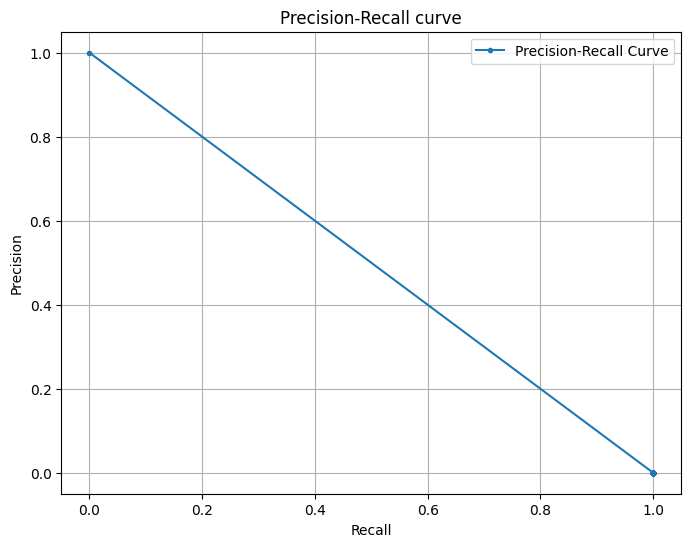

In [426]:
y_test_binary = [1 if y == 'Fail' else 0 for y in y_test]

# Получение значений precision и recall для различных порогов
precision, recall, thresholds = precision_recall_curve(y_test_binary, probs_fail)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

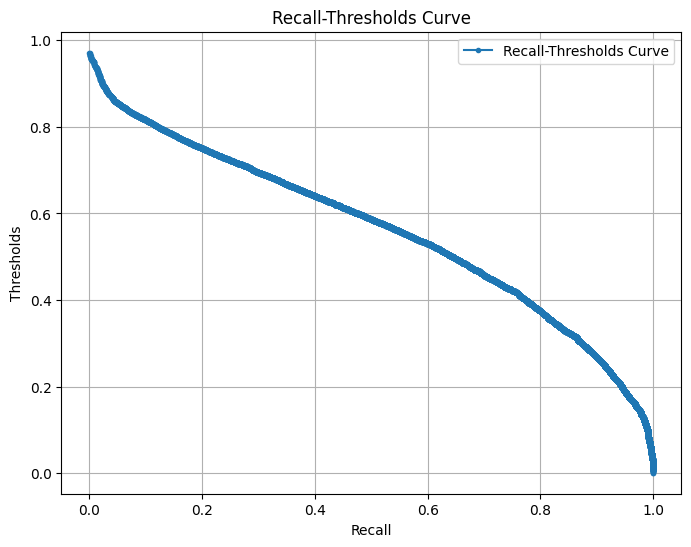

In [277]:
plt.figure(figsize=(8, 6))
plt.plot(recall[1:], thresholds, marker='.', label='Recall-Thresholds Curve')
plt.title('Recall-Thresholds Curve')
plt.xlabel('Recall')
plt.ylabel('Thresholds')
plt.legend()
plt.grid(True)
plt.show()

## catboost_pipeline evaluation:

In [312]:
# catboost_pipeline direct evaluation:
predictions = catboost_pipeline.predict(X_test)
print(f'Accuracy Score:{accuracy_score(y_test, predictions)}')
print(f'Recall Score:{recall_score(y_test, predictions, pos_label=0)}')
print(f'Precision Score:{precision_score(y_test, predictions, pos_label=1)}')


f1 = f1_score(y_test, predictions, average='weighted')
print(f'F1 Score: {f1}')

Accuracy Score:0.6842698211519505
Recall Score:0.7263986013986014
Precision Score:0.9278967979728173
F1 Score: 0.7248428464566804


In [1403]:
# Настраиваем k-кратную кросс-валидацию
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Применяем кросс-валидацию
scores = cross_val_score(catboost_pipeline, X, y, cv=kf, scoring='accuracy')

print("Точность на каждом фолде: ", scores)
print("Средняя точность: ", scores.mean())

# 0.689 - чисто OHE для всех категориальных
# 0.76 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 1000/800, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.73 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.71 - target encoding для части категориальных {'catboost__depth': 5, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.7 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.7 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.7 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 400, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.78 - после GridSearchCV
# 0.7 - {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05} GS, recall_score

0:	learn: 0.6824946	total: 4.13ms	remaining: 1.65s
100:	learn: 0.5654124	total: 287ms	remaining: 850ms
200:	learn: 0.5506788	total: 568ms	remaining: 563ms
300:	learn: 0.5326597	total: 862ms	remaining: 283ms
399:	learn: 0.5173291	total: 1.14s	remaining: 0us
0:	learn: 0.6835707	total: 3.08ms	remaining: 1.23s
100:	learn: 0.5660759	total: 275ms	remaining: 813ms
200:	learn: 0.5495407	total: 572ms	remaining: 566ms
300:	learn: 0.5310387	total: 861ms	remaining: 283ms
399:	learn: 0.5162990	total: 1.15s	remaining: 0us
0:	learn: 0.6833878	total: 3.08ms	remaining: 1.23s
100:	learn: 0.5685273	total: 271ms	remaining: 804ms
200:	learn: 0.5541986	total: 560ms	remaining: 554ms
300:	learn: 0.5354215	total: 842ms	remaining: 277ms
399:	learn: 0.5204794	total: 1.13s	remaining: 0us
Точность на каждом фолде:  [0.68798384 0.689218   0.70062837]
Средняя точность:  0.6926100687522437


In [1404]:
scores_f1_macro = cross_val_score(catboost_pipeline, X, y, cv=kf, scoring='f1_macro')
print("F1-балл (macro) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (macro): ", scores_f1_macro.mean())

# 0.585 - чисто OHE для всех категориальных
# 0.64 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 1000/800, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.63 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.62 - target encoding для части категориальных {'catboost__depth': 5, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.62 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.62 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.61 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 400, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.62 - {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05} GS, recall_score

0:	learn: 0.6824946	total: 3.2ms	remaining: 1.28s
100:	learn: 0.5654124	total: 293ms	remaining: 868ms
200:	learn: 0.5506788	total: 578ms	remaining: 573ms
300:	learn: 0.5326597	total: 877ms	remaining: 288ms
399:	learn: 0.5173291	total: 1.17s	remaining: 0us
0:	learn: 0.6835707	total: 2.72ms	remaining: 1.08s
100:	learn: 0.5660759	total: 280ms	remaining: 828ms
200:	learn: 0.5495407	total: 561ms	remaining: 555ms
300:	learn: 0.5310387	total: 847ms	remaining: 278ms
399:	learn: 0.5162990	total: 1.13s	remaining: 0us
0:	learn: 0.6833878	total: 3.02ms	remaining: 1.21s
100:	learn: 0.5685273	total: 270ms	remaining: 800ms
200:	learn: 0.5541986	total: 552ms	remaining: 547ms
300:	learn: 0.5354215	total: 835ms	remaining: 275ms
399:	learn: 0.5204794	total: 1.12s	remaining: 0us
F1-балл (macro) на каждом фолде:  [0.60700044 0.61176656 0.62163833]
Средний F1-балл (macro):  0.6134684440168153


In [1405]:
scores_f1_macro = cross_val_score(catboost_pipeline, X, y, cv=kf, scoring='f1_weighted')
print("F1-балл (weighted) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (weighted): ", scores_f1_macro.mean())

# 0.73 - чисто OHE для всех категориальных
# 0.78 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 1000/800, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.76 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.75 - target encoding для части категориальных {'catboost__depth': 5, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.74 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.73 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.73 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 400, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.73 - {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05} GS, recall_score

0:	learn: 0.6824946	total: 2.96ms	remaining: 1.18s
100:	learn: 0.5654124	total: 288ms	remaining: 851ms
200:	learn: 0.5506788	total: 572ms	remaining: 567ms
300:	learn: 0.5326597	total: 873ms	remaining: 287ms
399:	learn: 0.5173291	total: 1.16s	remaining: 0us
0:	learn: 0.6835707	total: 3.21ms	remaining: 1.28s
100:	learn: 0.5660759	total: 273ms	remaining: 807ms
200:	learn: 0.5495407	total: 554ms	remaining: 548ms
300:	learn: 0.5310387	total: 849ms	remaining: 279ms
399:	learn: 0.5162990	total: 1.14s	remaining: 0us
0:	learn: 0.6833878	total: 3.31ms	remaining: 1.32s
100:	learn: 0.5685273	total: 277ms	remaining: 819ms
200:	learn: 0.5541986	total: 561ms	remaining: 555ms
300:	learn: 0.5354215	total: 845ms	remaining: 278ms
399:	learn: 0.5204794	total: 1.13s	remaining: 0us
F1-балл (weighted) на каждом фолде:  [0.72703442 0.7268834  0.7364765 ]
Средний F1-балл (weighted):  0.7301314383533252


In [1406]:
# Делаем кросс-валидированные предсказания
y_pred = cross_val_predict(catboost_pipeline, X, y, cv=kf)

# Вычисляем полноту для неуспешных исследований
recall = recall_score(y, y_pred, pos_label=0)

print(f"Полнота для неуспешных исследований: {recall}")

# 0.64 - чисто OHE для всех категориальных
# 0.52 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 800, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.56 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.64 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.68 - target encoding для части категориальных {'catboost__depth': 5, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.7 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.71 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.72 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 400, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.73 - {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05} GS, recall_score

0:	learn: 0.6824946	total: 4.85ms	remaining: 1.93s
100:	learn: 0.5654124	total: 279ms	remaining: 825ms
200:	learn: 0.5506788	total: 577ms	remaining: 571ms
300:	learn: 0.5326597	total: 865ms	remaining: 284ms
399:	learn: 0.5173291	total: 1.14s	remaining: 0us
0:	learn: 0.6835707	total: 2.99ms	remaining: 1.19s
100:	learn: 0.5660759	total: 277ms	remaining: 819ms
200:	learn: 0.5495407	total: 570ms	remaining: 564ms
300:	learn: 0.5310387	total: 865ms	remaining: 284ms
399:	learn: 0.5162990	total: 1.15s	remaining: 0us
0:	learn: 0.6833878	total: 4.02ms	remaining: 1.6s
100:	learn: 0.5685273	total: 281ms	remaining: 832ms
200:	learn: 0.5541986	total: 564ms	remaining: 558ms
300:	learn: 0.5354215	total: 849ms	remaining: 279ms
399:	learn: 0.5204794	total: 1.15s	remaining: 0us
Полнота для неуспешных исследований: 0.7210242587601078


## Сохранение результатов:

In [1015]:
# Сохранение результатов:
results = {
        'Pipeline_name': catboost_pipeline,
        'Model': 'CatBoostClassifier',
        'Preprocessing': categorical_numeric_transformer_OHE,
        'n_iterations': 400,
        'n_depth': 4,
        'learning_rate': 0.05,
        'l2_leaf_reg': 1,
        'cross_val_recall_Fail_score': 0.72,
        'cross_val_accuracy': 0.69,
        'cross_val_f1_weighted': 0.73,
        'cross_val_f1_macro': 0.61,
        'Pipeline' : 'catboost'
    }

add_results_df = pd.DataFrame([results])

In [1016]:
#results_df = pd.concat([results_df, add_results_df], ignore_index=True)

In [1017]:
results_df

Pipeline_name               Model  \
0  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
1  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
2  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
3  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   
4  (ColumnTransformer(remainder='passthrough',\n ...  CatBoostClassifier   

                                       Preprocessing n_iterations n_depth  \
0  ColumnTransformer(remainder='passthrough',\n  ...         1000       7   
1  ColumnTransformer(remainder='passthrough',\n  ...         1000       6   
2  ColumnTransformer(remainder='passthrough',\n  ...          600       4   
3  ColumnTransformer(remainder='passthrough',\n  ...          500       4   
4  ColumnTransformer(remainder='passthrough',\n  ...          400       4   

   learning_rate l2_leaf_reg  cross_val_recall_Fail_score  cross_val_accuracy  \
0           0.10           1                         0.45                0.78   
1           0.10        None                         0.54                0.76   
2           0.05           1                         0.70                0.70   
3           0.05           1                         0.71                0.70   
4           0.05           1                         0.72                0.69   

   cross_val_f1_weighted  cross_val_f1_macro  
0                   0.79                0.64  
1                   0.78                0.64  
2                   0.74                0.62  
3                   0.73                0.62  
4                   0.73                0.61

<h1 style="color:lightgrey">Catboost_3 (skip):</h1>

- без SMOTE, - с ним было хуже
- c Mean target encoding для части категориальных фичей (при включении 'intervention_model' в categorical_features_target стало хуже)
- ОНЕ для оставшихся категориальных фичей
- из текстовых признаков оставляю только критерии включения/исключения

In [461]:
# Инициирование новых, локальных для данной модели X, y:
X = data_Phase1.drop('overall_status', axis=1)
y = data_Phase1['overall_status']

y = y.astype(int)


## Разделение на обучающую и валидационную выборки:

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Транформер, модель, catboost_pipeline:

In [1303]:
# Трансформер для категориальных фичей для Mean target encoding:
class CategoricalMeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.category_means = {}

    def fit(self, X, y=None):
        data = X.copy()
        data['overall_status'] = y
        for column in X.columns:
            self.category_means[column] = data.groupby(column)['overall_status'].mean().to_dict()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.category_means:
            X_transformed[column] = X[column].map(self.category_means[column])
        return X_transformed

In [1655]:
# Трансформер для catboost_pipeline:
categorical_numeric_transformer_OHE = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features_OHE),
        ('cat_target', CategoricalMeanEncoder(), categorical_features_target),
        ('num', StandardScaler(), numeric_features_total)
    ],
    remainder='passthrough'
)

In [1656]:
# Pipeline:
catboost_pipeline_3 = Pipeline(steps=[
    ('categorical_numeric_transformer_OHE', categorical_numeric_transformer_OHE),
    #('smote', SMOTE(random_state=42)),
    ('catboost', CatBoostClassifier(auto_class_weights='Balanced', iterations=400, learning_rate=0.05, depth=4, l2_leaf_reg=1, verbose=100))
])

In [1308]:
catboost_pipeline_3.fit(X_train, y_train)

0:	learn: 0.6838963	total: 5.43ms	remaining: 2.17s
100:	learn: 0.5688133	total: 308ms	remaining: 913ms
200:	learn: 0.5571579	total: 623ms	remaining: 617ms
300:	learn: 0.5430886	total: 924ms	remaining: 304ms
399:	learn: 0.5328276	total: 1.22s	remaining: 0us


Pipeline(steps=[('categorical_numeric_transformer_OHE',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender',
                                                   'intervention_model']),
                                                 ('cat_target',
                                                  CategoricalMeanEncoder(),
                                                  ['masking',
                                                   'responsible_party_type',
                                                   'source_class']),
                                                 ('num', StandardScaler(),
                                                  ['number_of_arms',
                                                   'number_of_facilities',
                                                   'minimum_age_in_years',
                                                   'maximum_age_in_years',
                                                   'number_of_primary_outcomes_to_measure',
                                                   'number_of_secondary_outcomes_to_measure',
                                                   'number_of_other_outcomes_to_measure',
                                                   'criteria'])])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x3b8d6f580>)])

## Поиск гиперпараметров для catboost_pipeline:

In [1314]:
# Определение сетки гиперпараметров для CatBoost
param_grid = {
    'catboost__iterations': [500, 800, 1000], # 500, 800, 900, 1100, 1200
    'catboost__learning_rate': [0.1, 0.05], #0.01
    'catboost__depth': [4,5,6,7], #4,5,6,8
    'catboost__l2_leaf_reg': [1] #3
}

# Определение собственной метрики для класса 0:
recall_scorer = make_scorer(recall_score, pos_label=0)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_pipeline_3,
    param_grid=param_grid,
    cv=3,  # Количество фолдов в кросс-валидации
    scoring=recall_scorer,  
    verbose=40,
    n_jobs=1 
)

# Обучение с поиском по сетке
grid_search.fit(X, y)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-балл (macro): {grid_search.best_score_}")

# Лучшие параметры: {'catboost__depth': 6, 'catboost__iterations': 1000, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# Лучший F1-балл (macro): 0.639434004226879

# Лучшие параметры: {'catboost__depth': 7, 'catboost__iterations': 1000, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# Лучший F1-балл (macro): 0.6408332687752963

# Лучшие параметры: {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# Лучший recall_scorer: 0.7151841868823

# Получение лучшей модели
best_catboost_pipeline = grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START catboost__depth=4, catboost__iterations=500, catboost__l2_leaf_reg=1, catboost__learning_rate=0.1
0:	learn: 0.6759925	total: 4.03ms	remaining: 2.01s
100:	learn: 0.5511746	total: 284ms	remaining: 1.12s
200:	learn: 0.5217063	total: 562ms	remaining: 837ms
300:	learn: 0.5017684	total: 849ms	remaining: 561ms
400:	learn: 0.4859232	total: 1.13s	remaining: 279ms
499:	learn: 0.4718942	total: 1.41s	remaining: 0us
[CV 1/3; 1/24] END catboost__depth=4, catboost__iterations=500, catboost__l2_leaf_reg=1, catboost__learning_rate=0.1;, score=0.677 total time=   1.6s
[CV 2/3; 1/24] START catboost__depth=4, catboost__iterations=500, catboost__l2_leaf_reg=1, catboost__learning_rate=0.1
0:	learn: 0.6752041	total: 3.33ms	remaining: 1.66s
100:	learn: 0.5550900	total: 283ms	remaining: 1.12s
200:	learn: 0.5282167	total: 559ms	remaining: 831ms
300:	learn: 0.5086098	total: 854ms	remaining: 565ms
400:	learn: 0.4925962	total: 1.14s	

## catboost_pipeline evaluation:

In [1309]:
# catboost_pipeline direct evaluation:
predictions = catboost_pipeline_3.predict(X_test)
print(f'Accuracy Score:{accuracy_score(y_test, predictions)}')
print(f'Recall Score:{recall_score(y_test, predictions, pos_label=0)}')


f1 = f1_score(y_test, predictions, average='weighted')
print(f'F1 Score: {f1}')

Accuracy Score:0.6955871353777113
Recall Score:0.7361894024802705
F1 Score: 0.73301753889522


In [1310]:
# Настраиваем k-кратную кросс-валидацию
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Применяем кросс-валидацию
scores = cross_val_score(catboost_pipeline_3, X, y, cv=kf, scoring='accuracy')

print("Точность на каждом фолде: ", scores)
print("Средняя точность: ", scores.mean())

# 0.689 - чисто OHE для всех категориальных
# 0.76 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 1000/800, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.73 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.71 - target encoding для части категориальных {'catboost__depth': 5, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.7 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.7 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.7 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 400, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.78 - после GridSearchCV
# 0.7 - {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05} GS, recall_score

0:	learn: 0.6837125	total: 5.01ms	remaining: 2s
100:	learn: 0.5662187	total: 286ms	remaining: 847ms
200:	learn: 0.5537127	total: 574ms	remaining: 569ms
300:	learn: 0.5383277	total: 868ms	remaining: 286ms
399:	learn: 0.5268241	total: 1.36s	remaining: 0us
0:	learn: 0.6843843	total: 3.13ms	remaining: 1.25s
100:	learn: 0.5667171	total: 298ms	remaining: 881ms
200:	learn: 0.5524127	total: 579ms	remaining: 574ms
300:	learn: 0.5362836	total: 861ms	remaining: 283ms
399:	learn: 0.5247598	total: 1.14s	remaining: 0us
0:	learn: 0.6840061	total: 3.03ms	remaining: 1.21s
100:	learn: 0.5704617	total: 275ms	remaining: 815ms
200:	learn: 0.5580432	total: 559ms	remaining: 553ms
300:	learn: 0.5418260	total: 837ms	remaining: 275ms
399:	learn: 0.5294902	total: 1.12s	remaining: 0us
Точность на каждом фолде:  [0.68820824 0.68809604 0.69950628]
Средняя точность:  0.691936852772492


In [1311]:
scores_f1_macro = cross_val_score(catboost_pipeline_3, X, y, cv=kf, scoring='f1_macro')
print("F1-балл (macro) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (macro): ", scores_f1_macro.mean())

# 0.585 - чисто OHE для всех категориальных
# 0.64 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 1000/800, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.63 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.62 - target encoding для части категориальных {'catboost__depth': 5, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.62 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.62 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.61 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 400, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.62 - {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05} GS, recall_score

0:	learn: 0.6837125	total: 3.03ms	remaining: 1.21s
100:	learn: 0.5662187	total: 290ms	remaining: 859ms
200:	learn: 0.5537127	total: 576ms	remaining: 570ms
300:	learn: 0.5383277	total: 856ms	remaining: 282ms
399:	learn: 0.5268241	total: 1.15s	remaining: 0us
0:	learn: 0.6843843	total: 2.86ms	remaining: 1.14s
100:	learn: 0.5667171	total: 288ms	remaining: 853ms
200:	learn: 0.5524127	total: 573ms	remaining: 567ms
300:	learn: 0.5362836	total: 852ms	remaining: 280ms
399:	learn: 0.5247598	total: 1.13s	remaining: 0us
0:	learn: 0.6840061	total: 4.4ms	remaining: 1.75s
100:	learn: 0.5704617	total: 280ms	remaining: 830ms
200:	learn: 0.5580432	total: 564ms	remaining: 558ms
300:	learn: 0.5418260	total: 849ms	remaining: 279ms
399:	learn: 0.5294902	total: 1.14s	remaining: 0us
F1-балл (macro) на каждом фолде:  [0.60788587 0.61200957 0.62149147]
Средний F1-балл (macro):  0.6137956370308163


In [1312]:
scores_f1_macro = cross_val_score(catboost_pipeline_3, X, y, cv=kf, scoring='f1_weighted')
print("F1-балл (weighted) на каждом фолде: ", scores_f1_macro)
print("Средний F1-балл (weighted): ", scores_f1_macro.mean())

# 0.73 - чисто OHE для всех категориальных
# 0.78 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 1000/800, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.76 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.75 - target encoding для части категориальных {'catboost__depth': 5, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.74 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.73 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.73 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 400, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.73 - {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05} GS, recall_score

0:	learn: 0.6837125	total: 3.05ms	remaining: 1.22s
100:	learn: 0.5662187	total: 508ms	remaining: 1.5s
200:	learn: 0.5537127	total: 990ms	remaining: 980ms
300:	learn: 0.5383277	total: 1.34s	remaining: 441ms
399:	learn: 0.5268241	total: 1.61s	remaining: 0us
0:	learn: 0.6843843	total: 2.94ms	remaining: 1.17s
100:	learn: 0.5667171	total: 289ms	remaining: 855ms
200:	learn: 0.5524127	total: 574ms	remaining: 568ms
300:	learn: 0.5362836	total: 853ms	remaining: 281ms
399:	learn: 0.5247598	total: 1.13s	remaining: 0us
0:	learn: 0.6840061	total: 2.91ms	remaining: 1.16s
100:	learn: 0.5704617	total: 282ms	remaining: 836ms
200:	learn: 0.5580432	total: 564ms	remaining: 558ms
300:	learn: 0.5418260	total: 843ms	remaining: 277ms
399:	learn: 0.5294902	total: 1.12s	remaining: 0us
F1-балл (weighted) на каждом фолде:  [0.7272942  0.72607181 0.73564068]
Средний F1-балл (weighted):  0.729668895864258


In [1313]:
# Делаем кросс-валидированные предсказания
y_pred = cross_val_predict(catboost_pipeline_3, X, y, cv=kf)

# Вычисляем полноту для неуспешных исследований
recall = recall_score(y, y_pred, pos_label=0)

print(f"Полнота для неуспешных исследований: {recall}")

# 0.64 - чисто OHE для всех категориальных
# 0.52 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 800, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.56 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
# 0.64 - target encoding для части категориальных {'catboost__depth': 6, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.68 - target encoding для части категориальных {'catboost__depth': 5, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.7 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 600, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.71 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.72 - target encoding для части категориальных {'catboost__depth': 4, 'catboost__iterations': 400, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05}
# 0.73 - {'catboost__depth': 4, 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.05} GS, recall_score

0:	learn: 0.6837125	total: 2.69ms	remaining: 1.07s
100:	learn: 0.5662187	total: 286ms	remaining: 846ms
200:	learn: 0.5537127	total: 575ms	remaining: 569ms
300:	learn: 0.5383277	total: 855ms	remaining: 281ms
399:	learn: 0.5268241	total: 1.14s	remaining: 0us
0:	learn: 0.6843843	total: 2.86ms	remaining: 1.14s
100:	learn: 0.5667171	total: 274ms	remaining: 813ms
200:	learn: 0.5524127	total: 551ms	remaining: 545ms
300:	learn: 0.5362836	total: 831ms	remaining: 273ms
399:	learn: 0.5247598	total: 1.12s	remaining: 0us
0:	learn: 0.6840061	total: 2.81ms	remaining: 1.12s
100:	learn: 0.5704617	total: 274ms	remaining: 810ms
200:	learn: 0.5580432	total: 557ms	remaining: 551ms
300:	learn: 0.5418260	total: 842ms	remaining: 277ms
399:	learn: 0.5294902	total: 1.14s	remaining: 0us
Полнота для неуспешных исследований: 0.727088948787062
